# Imports

In [1]:
from google.colab import drive
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import BorderlineSMOTE,ADASYN
from graphviz import Source
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import joblib


# Drive Mounting

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Reading Data

In [3]:
# read the dataset
df = pd.read_csv('drive/MyDrive/body_level_classification_train.csv')
df.head()


Gender        Age    Height     Weight H_Cal_Consump  Veg_Consump  \
0  Female  22.547298  1.722461  51.881263           yes     2.663421   
1    Male  19.799054  1.743702  54.927529           yes     2.000000   
2  Female  17.823438  1.708406  50.000000           yes     1.642241   
3  Female  19.007177  1.690727  49.895716           yes     1.212908   
4    Male  19.729250  1.793315  58.195150           yes     2.508835   

   Water_Consump Alcohol_Consump Smoking  Meal_Count Food_Between_Meals  \
0       1.041110              no      no    3.000000         Frequently   
1       2.847264       Sometimes      no    3.289260          Sometimes   
2       1.099231       Sometimes      no    3.452590          Sometimes   
3       1.029703       Sometimes      no    3.207071          Sometimes   
4       2.076933              no      no    3.435905          Sometimes   

  Fam_Hist H_Cal_Burn  Phys_Act  Time_E_Dev              Transport  \
0      yes         no  0.794402    1.391948  Public_Transportation   
1      yes         no  1.680844    2.000000  Public_Transportation   
2       no         no  0.418875    1.000000  Public_Transportation   
3       no         no  2.000000    1.000000  Public_Transportation   
4      yes         no  2.026668    1.443328             Automobile   

     Body_Level  
0  Body Level 1  
1  Body Level 1  
2  Body Level 1  
3  Body Level 1  
4  Body Level 1

# Dataset Analysis and processing

## Features Description

In [4]:
# -   Gender: Male or female.
# -   Age: Numeric value.
# -   Height: Numeric value (in meters).
# -   Weight: Numeric value (in kilograms).
# -   Fam_Hist: Does the family have a history with obesity?
# -   H_Cal_Consump: High caloric food consumption.
# -   Veg_Consump: Frequency of vegetables consumption.
# -   Meal_Count: Average number of meals per day.
# -   Food_Between_Meals: Frequency of eating between meals.
# -   Smoking: Is the person smoking?
# -   Water_Consump: Frequency of water consumption.
# -   H_Cal_Burn: Does the body have high calories burn rate?
# -   Phys_Act: How often does the person do physical activities?
# -   Time_E_Dev: How much time does person spend on electronic devices.
# -   Alcohol_Consump: Frequency of alcohols consumption.
# -   Transport: Which transports does the person usually use?
# -   Body_Level: Class of human body level.

## Distribution Of Classes

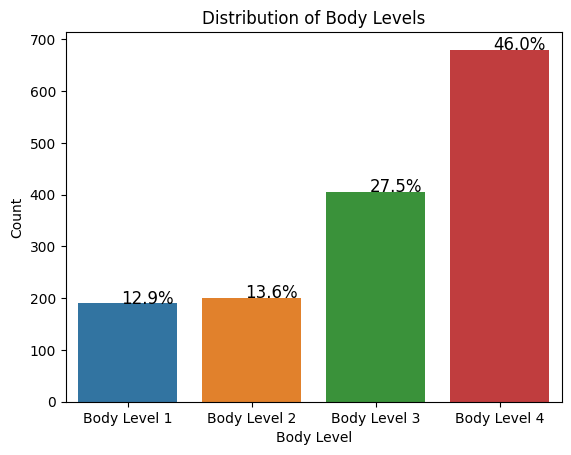

In [5]:

# Create a countplot of the 'Body_Level' column
ax = sns.countplot(x='Body_Level', data=df)

# Calculate the percentages for each category
total = len(df['Body_Level'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size=12)

# Set the title and axis labels
ax.set_title('Distribution of Body Levels')
ax.set_xlabel('Body Level')
ax.set_ylabel('Count')

# Show the plot
plt.show()

## Encodeing Categorical Values

In [6]:
def encode_categorical_features(df):
    code_value={
    "Body_Level":{"Body Level 1":1, "Body Level 2":2, "Body Level 3":3, "Body Level 4":4},
    "Gender":{"Female":0, "Male":1},
    "H_Cal_Consump":{"no":0, "yes":1},
    "Alcohol_Consump":{"no":0, "Sometimes":1, "Frequently":2, "Always":3},
    "Smoking":{"no":0, "yes":1},
    "Food_Between_Meals":{"no":0, "Sometimes":1, "Frequently":2, "Always":3},
    "Fam_Hist":{"no":0, "yes":1},
    "H_Cal_Burn":{"no":0, "yes":1},
    "Transport":{"Public_Transportation":0, "Automobile":1, "Walking":2, "Bike":3, "Motorbike":4}
    }
    for col in df.columns:
        if col in code_value:
            df[col]=df[col].map(code_value[col])
    return df

    # encode the categorical features
df_encoded = encode_categorical_features(df)

df_encoded.head()

Gender        Age    Height     Weight  H_Cal_Consump  Veg_Consump  \
0       0  22.547298  1.722461  51.881263              1     2.663421   
1       1  19.799054  1.743702  54.927529              1     2.000000   
2       0  17.823438  1.708406  50.000000              1     1.642241   
3       0  19.007177  1.690727  49.895716              1     1.212908   
4       1  19.729250  1.793315  58.195150              1     2.508835   

   Water_Consump  Alcohol_Consump  Smoking  Meal_Count  Food_Between_Meals  \
0       1.041110                0        0    3.000000                   2   
1       2.847264                1        0    3.289260                   1   
2       1.099231                1        0    3.452590                   1   
3       1.029703                1        0    3.207071                   1   
4       2.076933                0        0    3.435905                   1   

   Fam_Hist  H_Cal_Burn  Phys_Act  Time_E_Dev  Transport  Body_Level  
0         1           0  0.794402    1.391948          0           1  
1         1           0  1.680844    2.000000          0           1  
2         0           0  0.418875    1.000000          0           1  
3         0           0  2.000000    1.000000          0           1  
4         1           0  2.026668    1.443328          1           1

## Summary Statistics For Encoded Data

In [7]:
# Explore The data  # add the median value of each column to the DataFrame
df_encoded.describe()

Gender          Age       Height       Weight  H_Cal_Consump  \
count  1477.000000  1477.000000  1477.000000  1477.000000    1477.000000   
mean      0.505078    24.290420     1.701602    86.542290       0.884225   
std       0.500144     6.323081     0.094654    26.278277       0.320064   
min       0.000000    15.000000     1.456346    39.000000       0.000000   
25%       0.000000    19.895877     1.629194    65.000000       1.000000   
50%       1.000000    22.720449     1.701284    82.636162       1.000000   
75%       1.000000    26.000000     1.770278   106.690530       1.000000   
max       1.000000    55.246250     1.980000   173.000000       1.000000   

       Veg_Consump  Water_Consump  Alcohol_Consump      Smoking   Meal_Count  \
count  1477.000000    1477.000000      1477.000000  1477.000000  1477.000000   
mean      2.421912       2.005120         0.728504     0.022343     2.682104   
std       0.540711       0.620307         0.518055     0.147845     0.790751   
min       1.000000       1.000000         0.000000     0.000000     1.000000   
25%       2.000000       1.549931         0.000000     0.000000     2.644692   
50%       2.416044       2.000000         1.000000     0.000000     3.000000   
75%       3.000000       2.482933         1.000000     0.000000     3.000000   
max       3.000000       3.000000         3.000000     1.000000     4.000000   

       Food_Between_Meals     Fam_Hist   H_Cal_Burn     Phys_Act   Time_E_Dev  \
count         1477.000000  1477.000000  1477.000000  1477.000000  1477.000000   
mean             1.148274     0.817874     0.047393     1.023106     0.650672   
std              0.474647     0.386079     0.212551     0.844840     0.605199   
min              0.000000     0.000000     0.000000     0.000000     0.000000   
25%              1.000000     1.000000     0.000000     0.145687     0.000000   
50%              1.000000     1.000000     0.000000     1.000000     0.616045   
75%              1.000000     1.000000     0.000000     1.672639     1.000000   
max              3.000000     1.000000     1.000000     3.000000     2.000000   

         Transport   Body_Level  
count  1477.000000  1477.000000  
mean      0.308734     3.067028  
std       0.605540     1.052280  
min       0.000000     1.000000  
25%       0.000000     2.000000  
50%       0.000000     3.000000  
75%       1.000000     4.000000  
max       4.000000     4.000000

## Is there a relationship between weight and height values here?


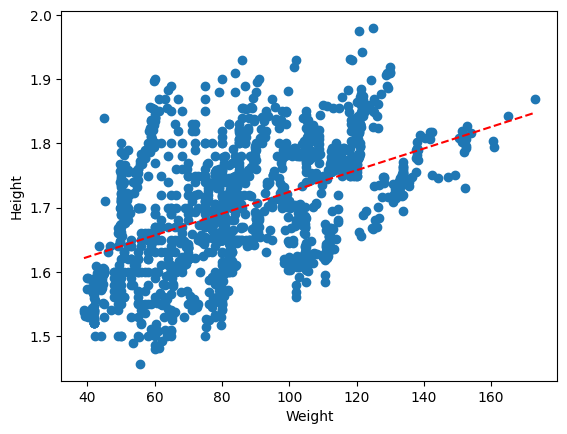

In [8]:
# create a scatter plot to see if there is a relationship between weight and height
plt.scatter(df_encoded['Weight'], df_encoded['Height'])
plt.xlabel('Weight')
plt.ylabel('Height')

# fit a line to the data using polyfit
slope, intercept = np.polyfit(df['Weight'], df['Height'], 1)

# plot reference line
x_vals = [min(df['Weight']), max(df['Weight'])]
y_vals = [slope * x + intercept for x in x_vals]
plt.plot(x_vals, y_vals, '--', color='r')
plt.show()

## Features BoxPlot

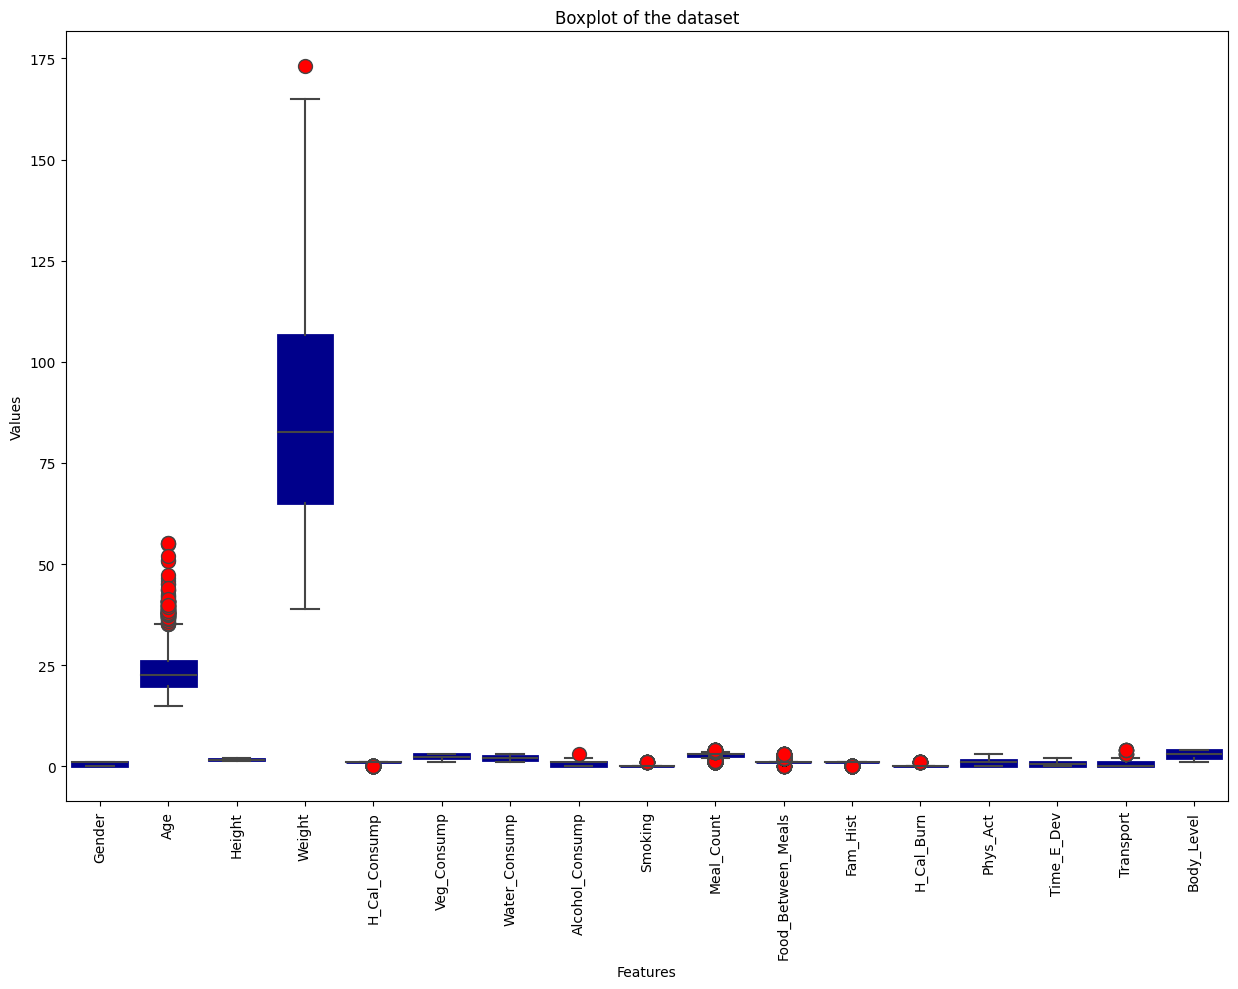

In [9]:
# create a boxplot to see if there are a lot ofoutliers in the data
plt.figure(figsize=(15,10))
plt.title('Boxplot of the dataset')
plt.xlabel('Features')
plt.ylabel('Values')
# transpose xlabel 
plt.xticks(rotation=90)
boxprops = dict(linestyle='-', linewidth=2, color='darkblue')
flierprops = dict(marker='o', markerfacecolor='red', markersize=10, linestyle='none')
sns.boxplot(data=df_encoded, boxprops=boxprops, flierprops=flierprops)
plt.show()


## Covariance Analysis

In [10]:
# Separate the input features from the target variable
X_cov = df.drop('Body_Level', axis=1)

# Compute the covariance matrix of the input features
cov_matrix = X_cov.cov()

# Create a list of column names to use as labels
labels = list(X_cov.columns)

# Create a heatmap figure with hover information
fig = px.imshow(cov_matrix,
                x=labels,
                y=labels,
                color_continuous_scale='RdBu',
                zmax=1.0,
                zmin=-1.0,
                title='Covariance Matrix with Hover Information')
fig.update_layout(
    xaxis=dict(tickangle=90),
    yaxis=dict(tickangle=0),
    height=800,
    width=800,
    font=dict(size=12),
    coloraxis_colorbar=dict(title='Covariance'),
    title=dict(x=0.5, y=0.95, xanchor='center', yanchor='top')
)
fig.update_traces(
    hovertemplate='<b>%{x}</b><br><b>%{y}</b><br>Covariance: %{z:.2f}<extra></extra>'
)
fig.show()

## Explore Age Distribution in the dataset

In [11]:
# bin Age column into intervals and count observations in each interval
age_ranges = pd.cut(df['Age'], bins=[14, 20, 30, 40,50,60])
count_by_age_range = age_ranges.value_counts()

# print result
for i, count in enumerate(count_by_age_range):
    print(f'({count_by_age_range.index[i].left}-{count_by_age_range.index[i].right}) years -> count of {count}')

(20-30) years -> count of 818
(14-20) years -> count of 409
(30-40) years -> count of 212
(40-50) years -> count of 31
(50-60) years -> count of 7


## Mean Weight for each body level

In [12]:
# mean weight of each class
df_encoded.groupby('Body_Level')['Weight'].mean()

Body_Level
1     50.116519
2     61.797512
3     78.021020
4    109.122043
Name: Weight, dtype: float64

## Mean BMI for each body level

In [13]:
temp_df_with_bmi = df_encoded.copy()
temp_df_with_bmi['BMI'] = df_encoded['Weight'] / (df_encoded['Height']) ** 2

print(temp_df_with_bmi.groupby('Body_Level')['BMI'].min(),temp_df_with_bmi.groupby('Body_Level')['BMI'].max())

Body_Level
1    13.291588
2    18.518519
3    22.826739
4    29.911958
Name: BMI, dtype: float64 Body_Level
1    19.082206
2    24.840980
3    30.362877
4    50.811753
Name: BMI, dtype: float64


### Above distribution of values shows that there's a potential strong relationship between BMI and Body_Level

## Skewness of data

In [14]:
df_encoded.skew(numeric_only=True)

Gender               -0.020333
Age                   1.481576
Height               -0.026199
Weight                0.263981
H_Cal_Consump        -2.404184
Veg_Consump          -0.482316
Water_Consump        -0.100632
Alcohol_Consump      -0.208836
Smoking               6.470351
Meal_Count           -1.059333
Food_Between_Meals    1.866960
Fam_Hist             -1.648912
H_Cal_Burn            4.264585
Phys_Act              0.464398
Time_E_Dev            0.635904
Transport             2.588752
Body_Level           -0.797732
dtype: float64

#### Skewness output show that most of the people in the dataset with H_Cal_Consump,low physical activity,not walking regularly, and rarely engaged in H_Cal_Burn which are consistent with a lot of people in this dataset in class4 with high mean value of weight

## visualize the distribution of the features using a histogram


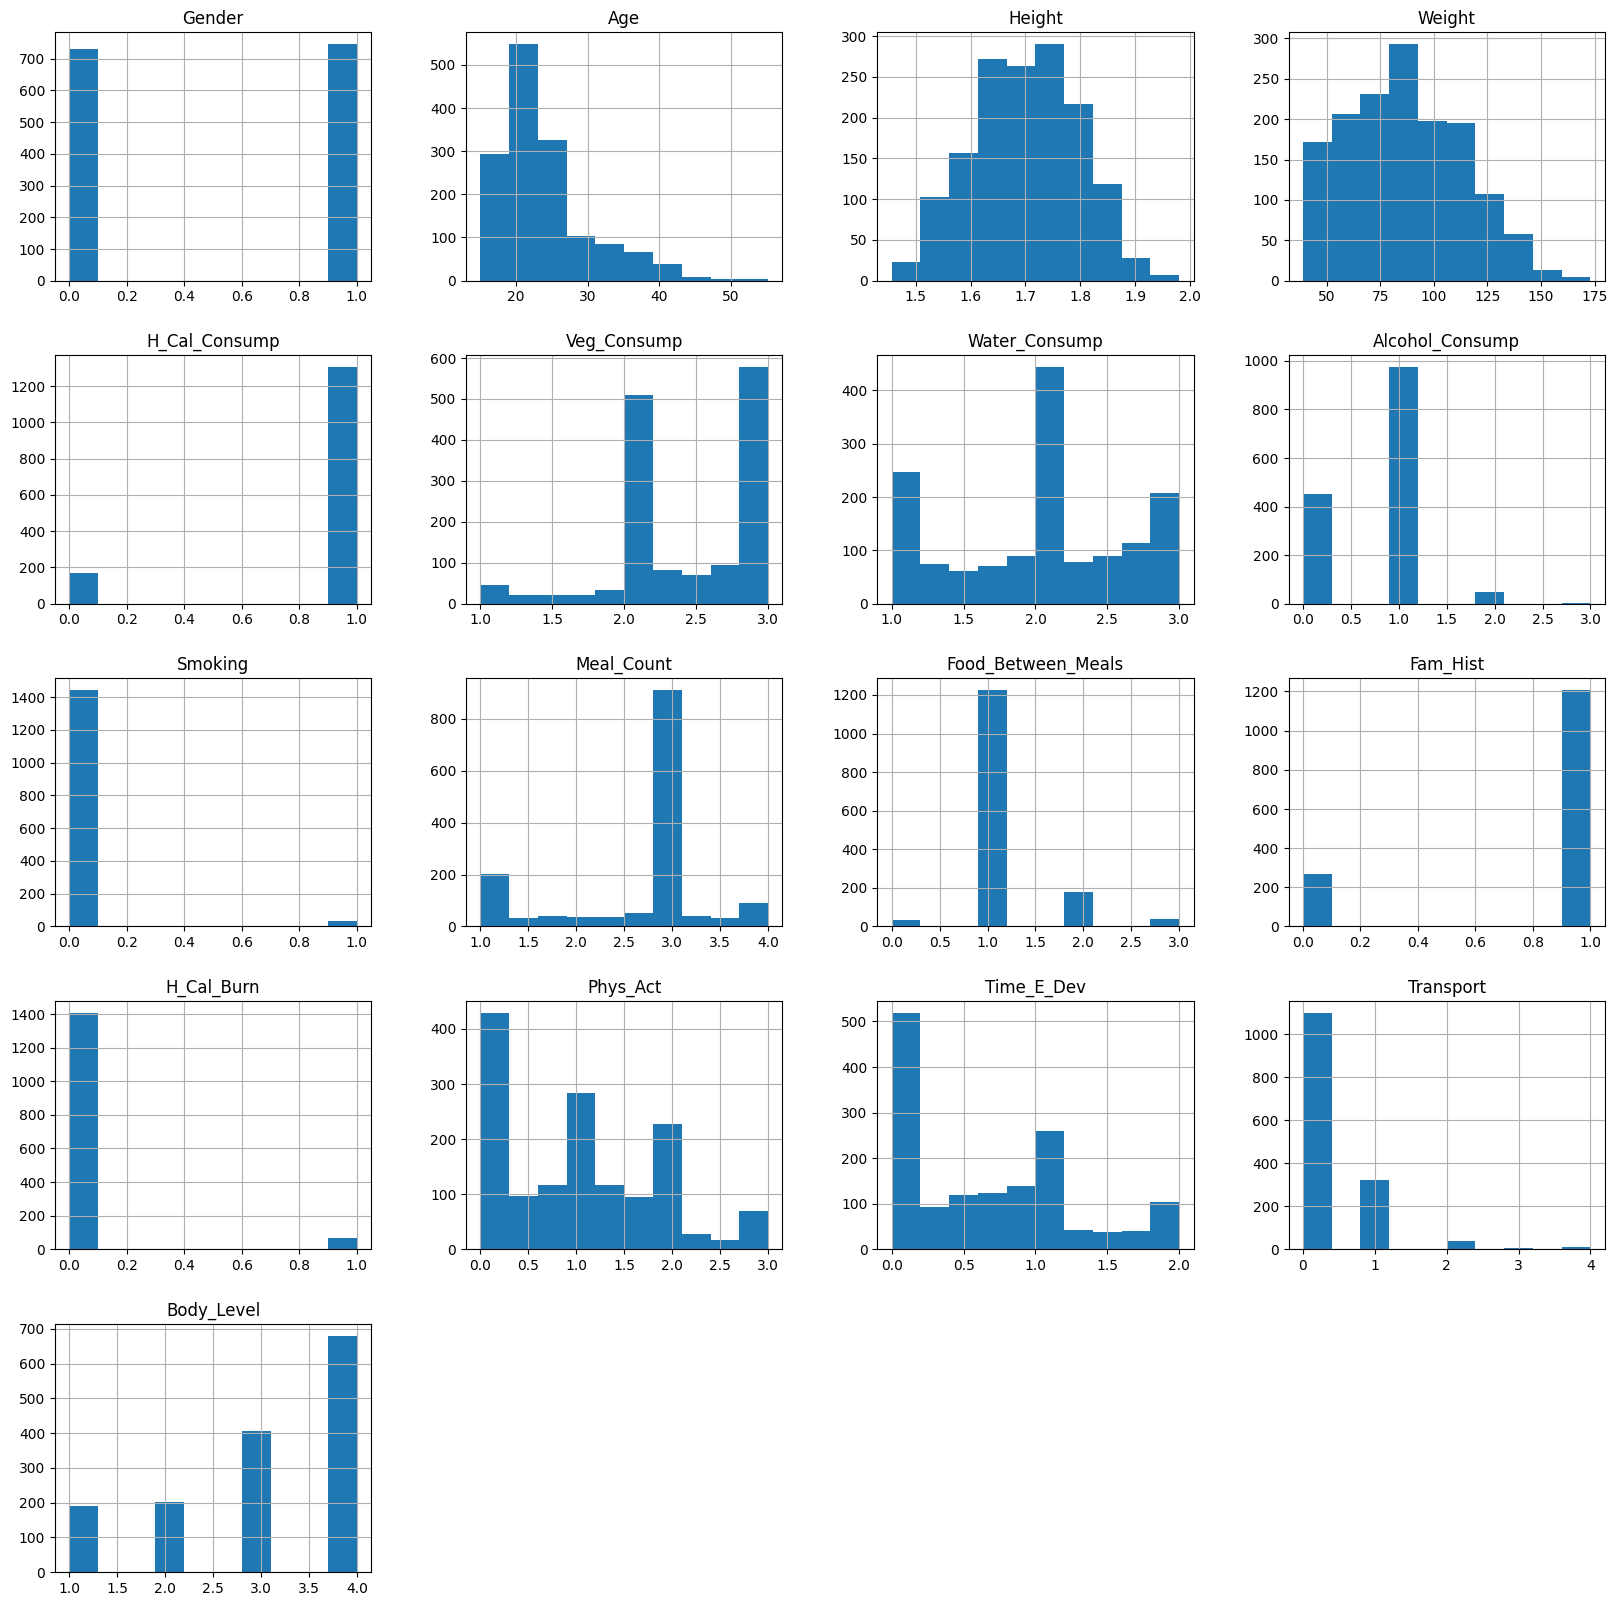

In [15]:
# visualize the distribution of the features using a histogram within each class
df_encoded.hist(figsize=(20, 20))
plt.show()

## Correlation Matrix after adding BMI

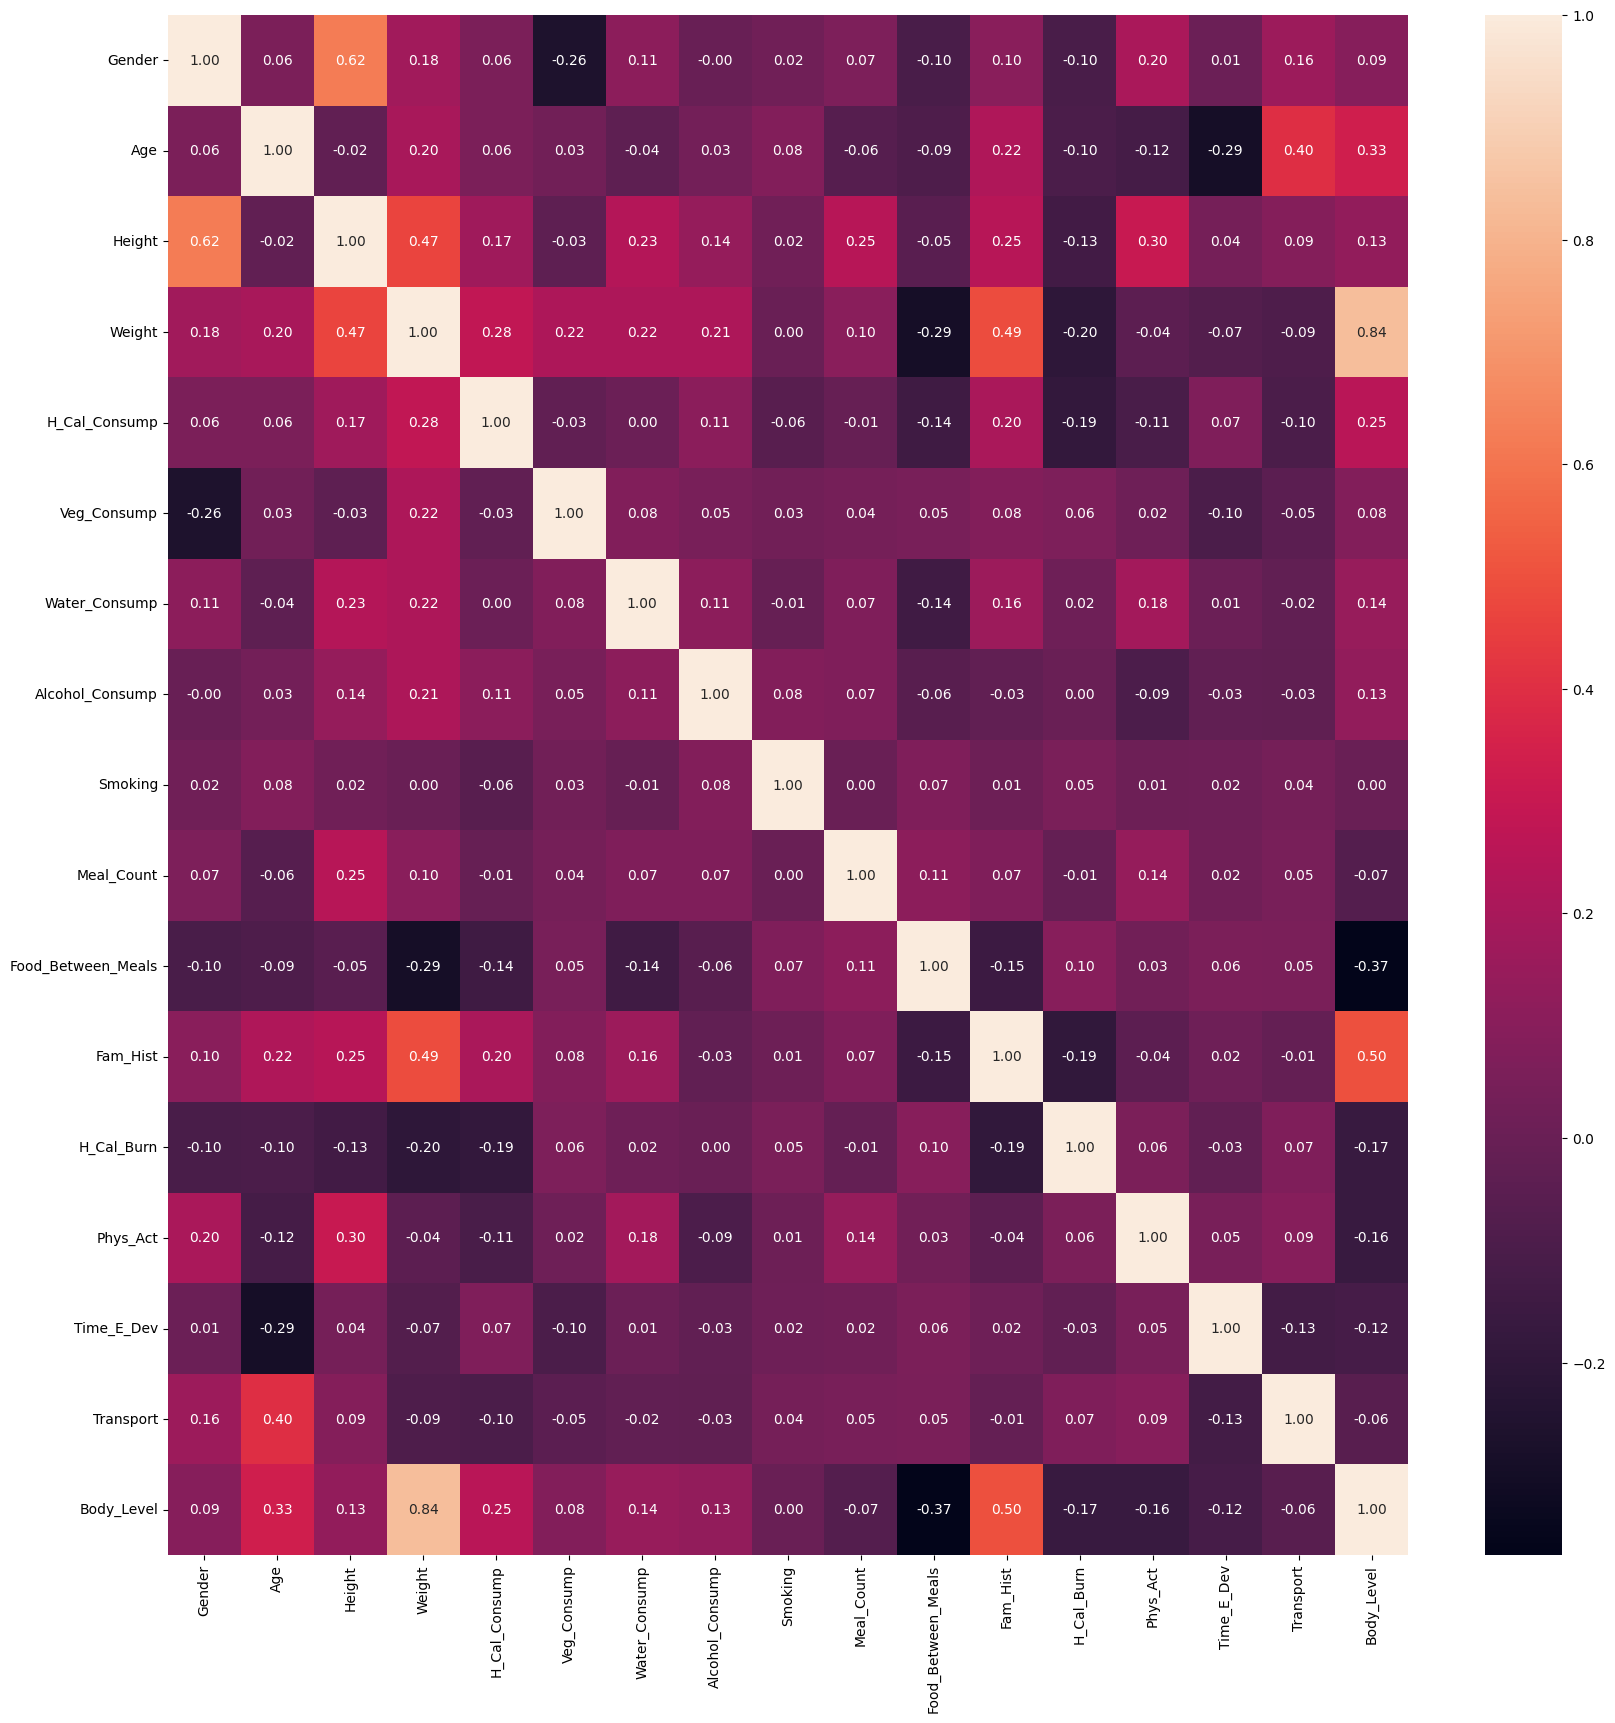

In [16]:
# Exploring the data 
# visualize the correlation between the features

# add BMI to the DataFrame
df_encoded_with_BMI = df_encoded.copy()
df_encoded_with_BMI['BMI'] = df_encoded['Weight'] / (df_encoded['Height']) ** 2


plt.figure(figsize=(20, 20))
sns.heatmap(df_encoded.corr(), annot=True, fmt='.2f')
plt.show()



### Focus on the correlation between the features and the target variable


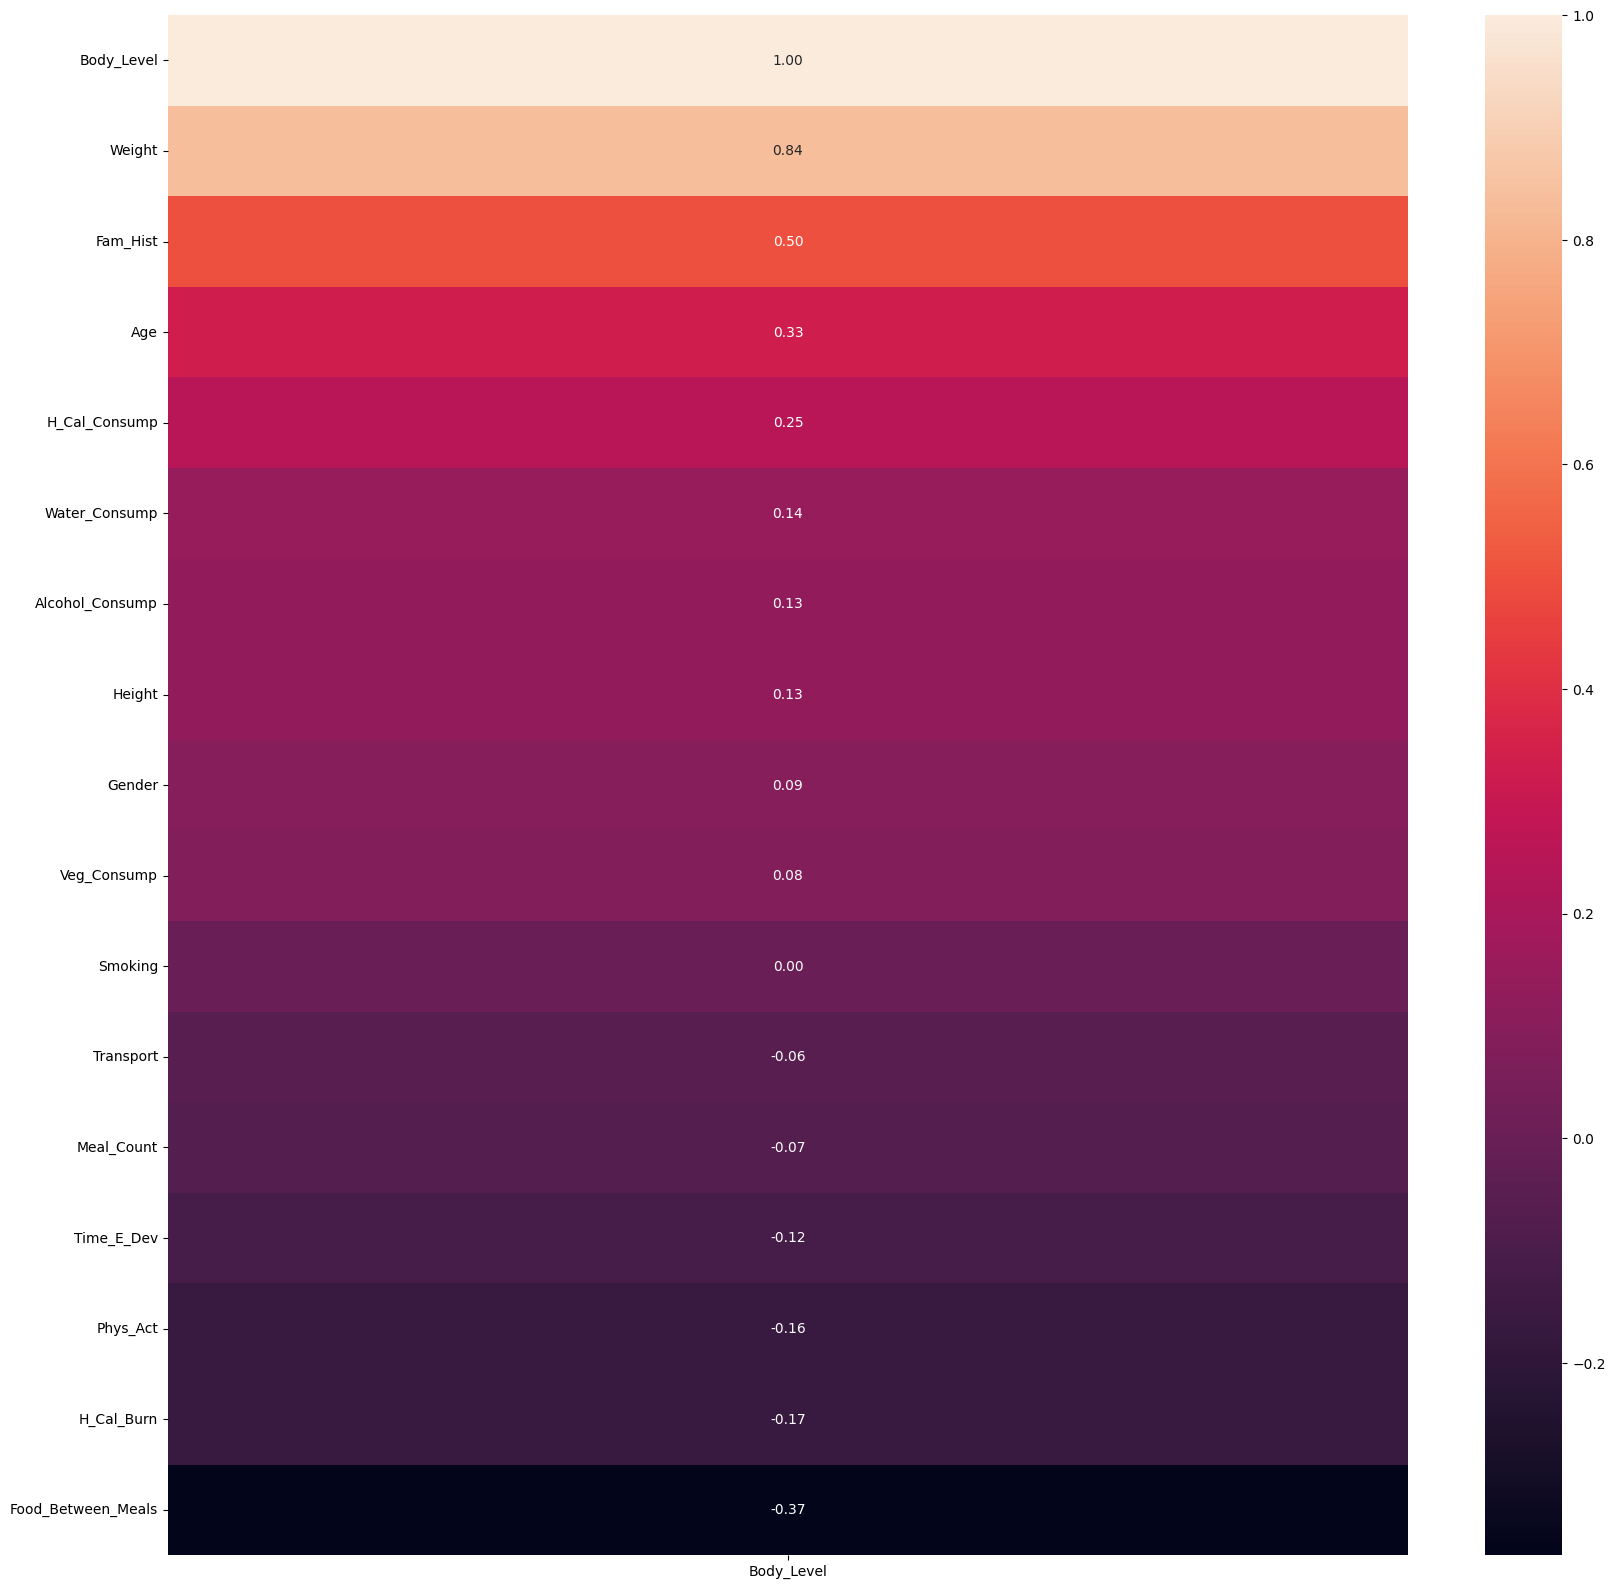

In [17]:
# visualize the correlation between the features and the target variable
plt.figure(figsize=(20, 20))
sns.heatmap(df_encoded.corr()[['Body_Level']].sort_values(by='Body_Level', ascending=False), annot=True, fmt='.2f')
plt.show()

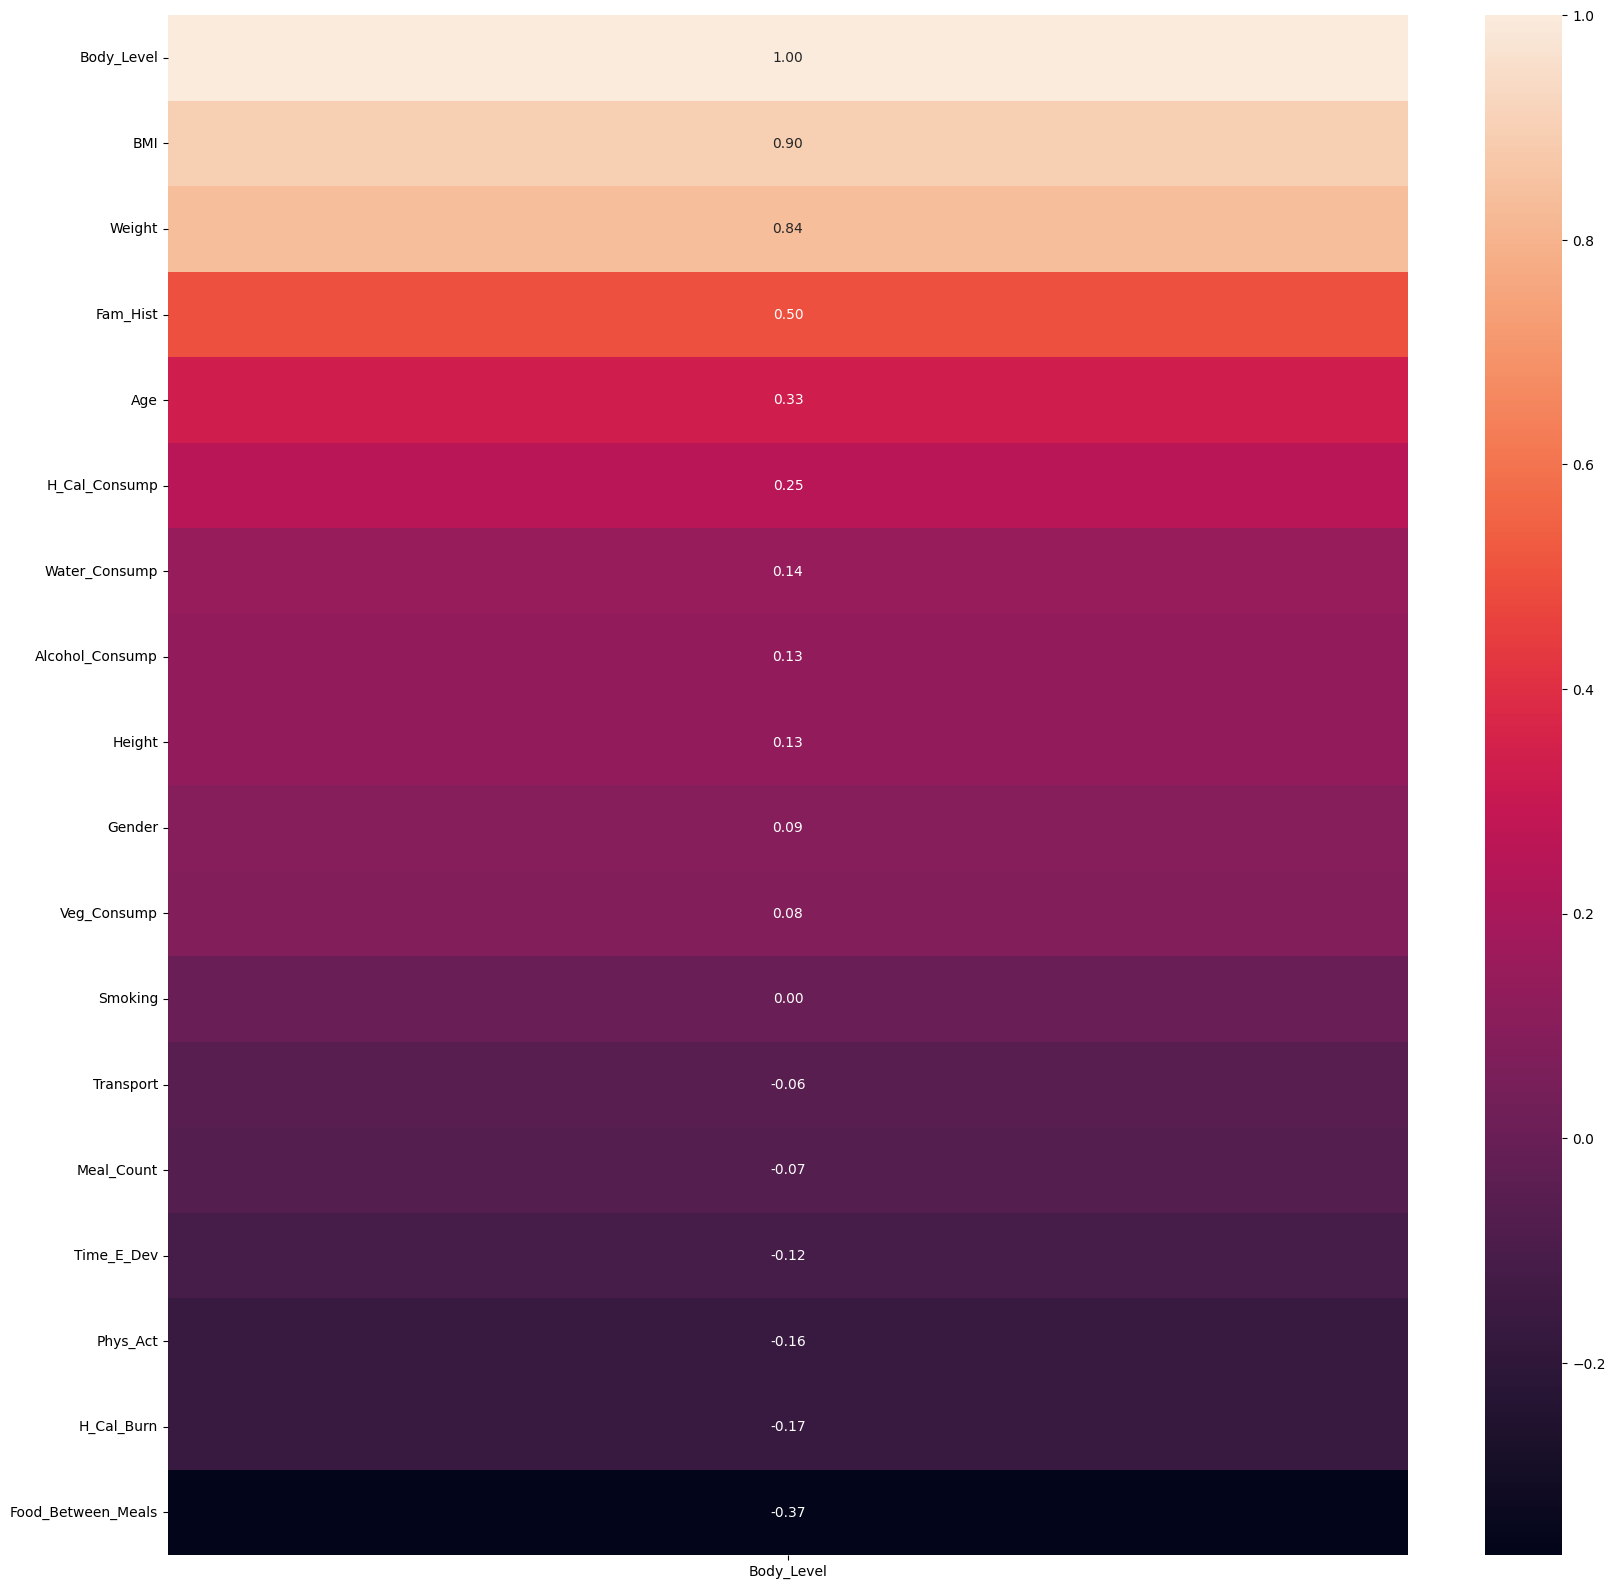

In [18]:
# visualize the correlation between the features and the target variable
plt.figure(figsize=(20, 20))
sns.heatmap(df_encoded_with_BMI.corr()[['Body_Level']].sort_values(by='Body_Level', ascending=False), annot=True, fmt='.2f')
plt.show()

# Core

## Split the dataset (without BMI)

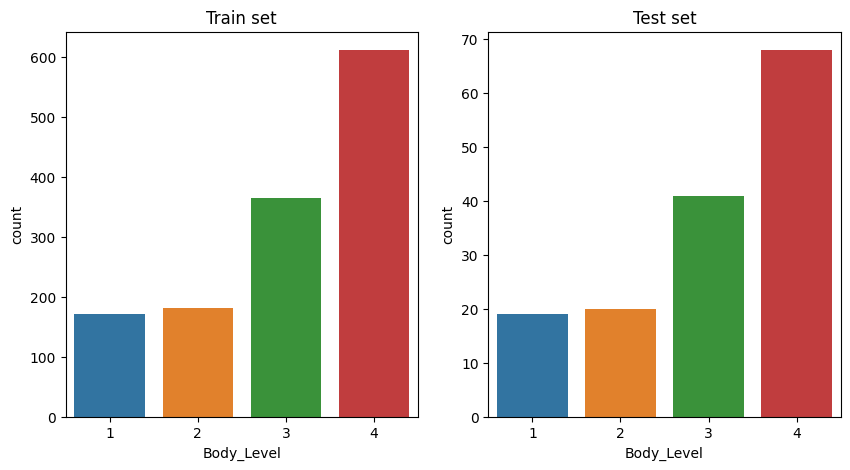

In [19]:
X = df_encoded.drop('Body_Level', axis=1)
y = df_encoded['Body_Level']


# split unbalanced data into train and test sets using stratification sampling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
# check the distribution of the classes in the train and test sets


# Visualize the distribution of the classes in the train and test sets
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title('Train set')
sns.countplot(x=y_test, ax=ax[1])
ax[1].set_title('Test set')
plt.show()
    
    

## Split the dataset (With BMI)

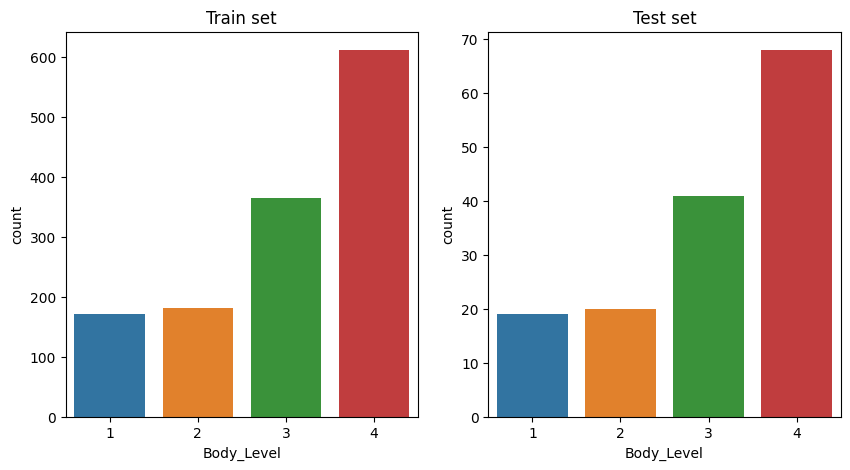

In [20]:
X = df_encoded_with_BMI.drop('Body_Level', axis=1)
y = df_encoded_with_BMI['Body_Level']


# split unbalanced data into train and test sets using stratification sampling

X_train_BMI, X_test_BMI, y_train_BMI, y_test_BMI = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Visualize the distribution of the classes in the train and test sets
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title('Train set')
sns.countplot(x=y_test, ax=ax[1])
ax[1].set_title('Test set')
plt.show()
    
    

## Helper Functions for ML Models Training and testing

In [21]:
def train_model(model, X_train, y_train):
    # train the model
    model.fit(X_train, y_train)

    # return the trained model
    return model

def predict(model, X_test, y_test):
    # make predictions using the trained model
    y_pred = model.predict(X_test)

    # return the predictions
    return y_pred

def evaluate_model(y_test, y_pred):
    # calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    # calculate the precision score
    precision = precision_score(y_test, y_pred, average='weighted')

    # calculate the recall score
    recall = recall_score(y_test, y_pred, average='weighted')

    # calculate the f1 score
    f1 = f1_score(y_test, y_pred, average='weighted')

    # return the evaluation metrics
    return accuracy, precision, recall, f1

def saveModel(model,modelname):
  model_file_name = modelname+'.joblib'
  joblib.dump(model, model_file_name)


def loadModel(path):
  return joblib.load(path)


def complete_pass(model,params,X_train,y_train,saved_model_name):
  best_model, model_params, model_scores,svc_grid = tune_params(X_train, y_train, model, params)
  saveModel(best_model,saved_model_name)
  saveModel(svc_grid,saved_model_name+'_grid_search')
    # create a dictionary of hyperparameters and their values
  hyperparams = {key: svc_grid.cv_results_['param_'+key].data for key in params.keys()}

  # get the mean test scores for each hyperparameter combination
  mean_scores = svc_grid.cv_results_['mean_test_score']

  # create a list of hyperparameters to plot
  param_list = list(params.keys())

  # plot the effect of each hyperparameter on the cross-validation scores
  fig, axs = plt.subplots(1, len(param_list), figsize=(12, 4))
  for idx, param in enumerate(param_list):
      param_values = hyperparams[param]
      for j, val in enumerate(np.unique(hyperparams[param])):
          mask = hyperparams[param] == val
          axs[idx].plot(param_values[mask], mean_scores[mask], 'o-', label=f"{param}={val}")
      axs[idx].set_xlabel(param)
      axs[idx].set_ylabel('Mean Test Score')
      axs[idx].legend()
  plt.tight_layout()
  plt.show()

  return best_model, model_params, model_scores,svc_grid

In [22]:
# Apply OVERSAMPLING to the training data
def blsmote(X_train, y_train):
    # create an instance of BorderlineSMOTE
    sm = BorderlineSMOTE(random_state=42)

    # fit the training data to the SMOTE instance
    X_train_blsmote, y_train_blsmote = sm.fit_resample(X_train, y_train)

    # return the oversampled data
    return X_train_blsmote, y_train_blsmote



def adasyn(X_train, y_train):
    # create an instance of ADASYN
    sm = ADASYN(random_state=42)

    # fit the training data to the ADASYN instance
    X_train_adasyn, y_train_adasyn = sm.fit_resample(X_train, y_train)

    # return the oversampled data
    return X_train_adasyn, y_train_adasyn


def run(X_, y_, X_test, y_test, models):
    # create a list to store the accuracy scores for training and test sets
    accuracy_scores_train = []
    accuracy_scores_test = []

    # create a list to store the precision scores for training and test sets
    precision_scores_train = []
    precision_scores_test = []

    # create a list to store the recall scores for training and test sets
    recall_scores_train = []
    recall_scores_test = []

    # create a list to store the f1 scores for training and test sets
    f1_scores_train = []
    f1_scores_test = []

    # loop over the models
    for model in models:
        # train the model on the oversampled training data
        trained_model = train_model(model, X_, y_)

        # make predictions on the training and test sets
        y_pred_train = predict(trained_model, X_, y_)
        y_pred_test = predict(trained_model, X_test, y_test)

        # evaluate the model on the training set
        accuracy_train, precision_train, recall_train, f1_train = evaluate_model(y_, y_pred_train)

        # evaluate the model on the test set
        accuracy_test, precision_test, recall_test, f1_test = evaluate_model(y_test, y_pred_test)

        # append the accuracy scores to accuracy_scores_train and accuracy_scores_test
        accuracy_scores_train.append(accuracy_train)
        accuracy_scores_test.append(accuracy_test)

        # append the precision scores to precision_scores_train and precision_scores_test
        precision_scores_train.append(precision_train)
        precision_scores_test.append(precision_test)

        # append the recall scores to recall_scores_train and recall_scores_test
        recall_scores_train.append(recall_train)
        recall_scores_test.append(recall_test)

        # append the f1 scores to f1_scores_train and f1_scores_test
        f1_scores_train.append(f1_train)
        f1_scores_test.append(f1_test)

    # create a DataFrame to store the evaluation metrics
    df_scores = pd.DataFrame({
        'Model': models,
        'Train Accuracy': accuracy_scores_train,
        'Test Accuracy': accuracy_scores_test,
        'Train Precision': precision_scores_train,
        'Test Precision': precision_scores_test,
        'Train Recall': recall_scores_train,
        'Test Recall': recall_scores_test,
        'Train F1': f1_scores_train,
        'Test F1': f1_scores_test
    })

    # sort the DataFrame by the test F1 score in descending order
    df_scores = df_scores.sort_values(by='Test F1', ascending=False)

    # return the evaluation DataFrame
    return df_scores
    

# Grid Search for the BaggingClassifier model
def tune_params(X_,y_,model,hyperparameters,cv=5,verbose=1):
  # create a GridSearchCV instance
  grid = GridSearchCV(model, hyperparameters, cv=cv, verbose=verbose,return_train_score=True,scoring='accuracy',n_jobs=-1)

  # train the model
  grid.fit(X_, y_)

  best_model = grid.best_estimator_
  params = grid.cv_results_['params']
  mean_test_scores = grid.cv_results_['mean_test_score']
  return best_model,params,mean_test_scores,grid


def visualize_hyperparams_effect(params, scores, x, y, c):
    scores = np.nan_to_num(scores)
    # Create a DataFrame that includes the hyperparameter values and accuracy scores
    data = pd.DataFrame({
        x: [p[x] for p in params],
        y: [p[y] for p in params],
        c: [p[c] for p in params],
        'Score': scores
    })
    # Determine the range of values for the color parameter
    c_min = min(data[c])
    c_max = max(data[c])
    # Create a color scale that maps the range of values to a specific color
    color_scale = [[i / 10.0, f'rgb({255 - i*255//10}, {i*255//10}, 0)'] for i in range(11)] 
    # Create a scatter plot
    fig = px.scatter(data, x=x, y=y, color='Score', size=c, color_continuous_scale=color_scale, range_color=[0, 1])
    fig.update_layout(
        title='Effect of Hyperparameters on Accuracy',
        xaxis_title=x,
        yaxis_title=y,
        coloraxis_colorbar=dict(title='Accuracy')
    )
    fig.show()



## Oversampling the training dataset using BorderLineSmote and Adasyn

In [23]:
X_train_blsmote, y_train_blsmote = blsmote(X_train, y_train)
X_train_adasyn, y_train_adasyn = adasyn(X_train, y_train)

X_train_blsmote_BMI, y_train_blsmote_BMI = blsmote(X_train_BMI, y_train_BMI)
X_train_adasyn_BMI, y_train_adasyn_BMI = adasyn(X_train_BMI, y_train_BMI)

## Loading Saved Models and use Them

### Grid Searchs Models

In [24]:
best_bagging_classifier_normal_data_grid_search = loadModel('drive/MyDrive/models/best_bagging_classifier_normal_data_grid_search.joblib')
best_bagging_classifier_adasyn_data_grid_search = loadModel('drive/MyDrive/models/best_bagging_classifier_adasyn_data_grid_search.joblib')
best_bagging_classifier_blsmote_data_grid_search = loadModel('drive/MyDrive/models/best_bagging_classifier_blsmote_data_grid_search.joblib')
best_bagging_classifier_adasyn_bmi_data_grid_search = loadModel('drive/MyDrive/models/best_bagging_classifier_adasyn_bmi_data_grid_search.joblib')
best_bagging_classifier_blsmote_bmi_data_grid_search = loadModel('drive/MyDrive/models/best_bagging_classifier_blsmote_bmi_data_grid_search.joblib')
best_bagging_classifier_normal_bmi_data_grid_search = loadModel('drive/MyDrive/models/best_bagging_classifier_normal_bmi_data_grid_search.joblib')

best_logistic_regression_normal_data_grid_search = loadModel('drive/MyDrive/models/best_logistic_regression_normal_data_grid_search.joblib')
best_logistic_regression_blsmote_data_grid_search = loadModel('drive/MyDrive/models/best_logistic_regression_blsmote_data_grid_search.joblib')
best_logistic_regression_adasyn_bmi_data_grid_search = loadModel('drive/MyDrive/models/best_logistic_regression_adasyn_bmi_data_grid_search.joblib')
best_logistic_regression_blsmote_bmi_data_grid_search = loadModel('drive/MyDrive/models/best_logistic_regression_blsmote_bmi_data_grid_search.joblib')
best_logistic_regression_normal_bmi_data_grid_search = loadModel('drive/MyDrive/models/best_logistic_regression_normal_bmi_data_grid_search.joblib')
best_logistic_regression_adasyn_data_grid_search = loadModel('drive/MyDrive/models/best_logistic_regression_adasyn_data_grid_search.joblib')


best_normal_svc_grid_search = loadModel('drive/MyDrive/models/best_normal_svc_grid_search.joblib')
best_blsmote_svc_grid_search = loadModel('drive/MyDrive/models/best_blsmote_svc_grid_search.joblib')
best_blsmote_bmi_svc_grid_search = loadModel('drive/MyDrive/models/best_blsmote_bmi_svc_grid_search.joblib')
best_adasyn_svc_grid_search = loadModel('drive/MyDrive/models/best_adasyn_svc_grid_search.joblib')
best_adasyn_bmi_svc_grid_search = loadModel('drive/MyDrive/models/best_adasyn_bmi_svc_grid_search.joblib')
best_normal_bmi_svc_grid_search = loadModel('drive/MyDrive/models/best_normal_bmi_svc_grid_search.joblib')



### loaded_bg_normal

In [ ]:
loaded_bg_normal = loadModel('drive/MyDrive/best_bagging_classifier_normal_data.joblib')
run(X_train,y_train,X_test,y_test,[loaded_bg_normal])

Model  Train Accuracy  \
0  (DecisionTreeClassifier(random_state=195292617...             1.0   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
0        0.97973              1.0        0.980696           1.0      0.97973   

   Train F1   Test F1  
0       1.0  0.979155



### loaded_bg_normal_bmi

In [ ]:
loaded_bg_normal_bmi = loadModel('drive/MyDrive/best_bagging_classifier_normal_data_with_bmi.joblib')
run(X_train_BMI,y_train_BMI,X_test_BMI,y_test_BMI,[loaded_bg_normal_bmi])

Model  Train Accuracy  \
0  (DecisionTreeClassifier(random_state=195292617...             1.0   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
0            1.0              1.0             1.0           1.0          1.0   

   Train F1  Test F1  
0       1.0      1.0

### loaded_bg_blsmote

In [ ]:
loaded_bg_blsmote = loadModel('drive/MyDrive/best_bagging_classifier_blsmote_data.joblib')
run(X_train_blsmote,y_train_blsmote,X_test,y_test,[loaded_bg_blsmote])

Model  Train Accuracy  \
0  (DecisionTreeClassifier(random_state=195292617...             1.0   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
0       0.972973              1.0        0.972851           1.0     0.972973   

   Train F1   Test F1  
0       1.0  0.972423

### loaded_bg_blsmote_bmi

In [ ]:
loaded_bg_blsmote_bmi = loadModel('drive/MyDrive/best_bagging_classifier_blsmote_data_with_bmi.joblib')
run(X_train_blsmote_BMI,y_train_blsmote_BMI,X_test_BMI,y_test_BMI,[loaded_bg_blsmote_bmi])

Model  Train Accuracy  \
0  (DecisionTreeClassifier(random_state=195292617...             1.0   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
0       0.993243              1.0        0.993404           1.0     0.993243   

   Train F1   Test F1  
0       1.0  0.993259

### loaded_bg_adasyn

In [ ]:
loaded_bg_adasyn = loadModel('drive/MyDrive/best_bagging_classifier_adasyn_data.joblib')
run(X_train_adasyn,y_train_adasyn,X_test,y_test,[loaded_bg_adasyn])

Model  Train Accuracy  \
0  (DecisionTreeClassifier(random_state=195292617...             1.0   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
0       0.986486              1.0        0.986486           1.0     0.986486   

   Train F1   Test F1  
0       1.0  0.986486

### loaded_bg_adasyn_bmi

In [ ]:
loaded_bg_adasyn_bmi = loadModel('drive/MyDrive/best_bagging_classifier_adasyn_data_with_bmi.joblib')
run(X_train_adasyn_BMI,y_train_adasyn_BMI,X_test_BMI,y_test_BMI,[loaded_bg_adasyn_bmi])

Model  Train Accuracy  \
0  (DecisionTreeClassifier(random_state=195292617...             1.0   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
0            1.0              1.0             1.0           1.0          1.0   

   Train F1  Test F1  
0       1.0      1.0

# HyperParameters Tuning

## Normal Data

Fitting 5 folds for each of 125 candidates, totalling 625 fits


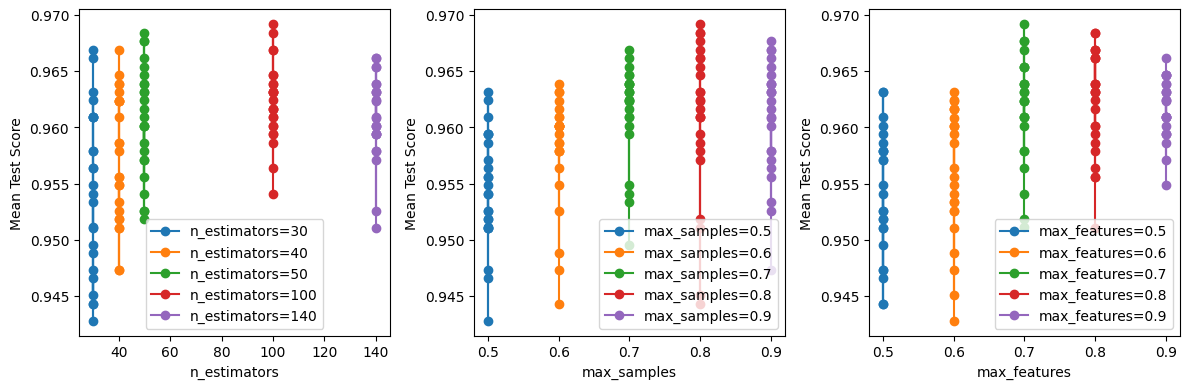

In [ ]:
# create a list of hyperparameters
bg_hyperparameters = {
    'n_estimators': [30, 40, 50,100,140],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9]
}
bagging = BaggingClassifier(random_state=42)
best_bagging_classifier_normal_data,bg_normal_params,bg_normal_scores,bg_grid_normal=complete_pass(bagging,bg_hyperparameters,X_train,y_train,'best_bagging_classifier_normal_data')

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Sol

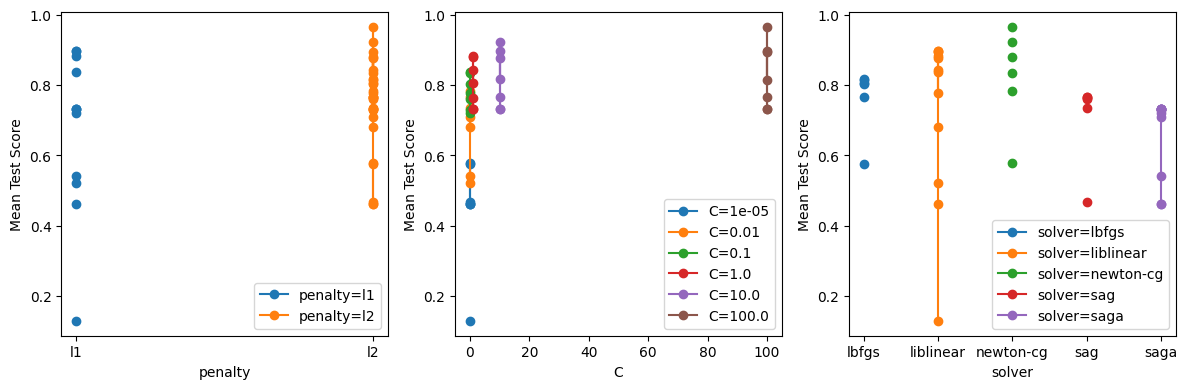

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
lg_hyperparameters = {'penalty': ['l1', 'l2'], 
                   'C': [1e-5,0.01, 0.1, 1.0, 10.0, 100.0],
                   'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lg = LogisticRegression(random_state=42)
best_logistic_regression_normal_data,lg_normal_params,lg_normal_scores,lg_grid_normal = complete_pass(lg,lg_hyperparameters,X_train,y_train,'best_logistic_regression_normal_data')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


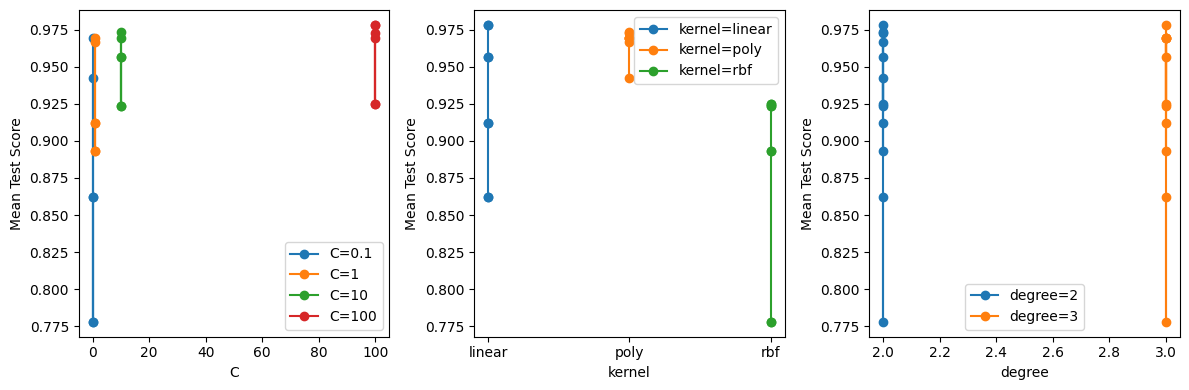

In [ ]:
# create a list of hyperparameters
svc_hyperparameters = {
    'C': [0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3]
}

# create an SVC object
svc = SVC(random_state=42,gamma='auto')

best_normal_svc, svc_normal_params, svc_normal_scores,svc_grid_normal = complete_pass(svc,svc_hyperparameters,X_train,y_train,'best_normal_svc')

In [ ]:
best_normal_svc

SVC(C=100, degree=2, gamma='auto', kernel='linear', random_state=42)

In [ ]:

# create a list of models
models = [
    best_logistic_regression_normal_data,
    best_normal_svc,
    best_bagging_classifier_normal_data,
]
df_scores = run(X_train, y_train, X_test, y_test, models)

# find the index of the Bagging Classifier and Logistic Regression rows in df_scores
bc_index = df_scores[(df_scores['Model'] == best_bagging_classifier_normal_data)].index[0]
best_bg_index = np.argmax(bg_normal_scores)
best_bg_cv_score = bg_normal_scores[best_bg_index]
df_scores.loc[bc_index, ['CV Accuracy']] = best_bg_cv_score


lr_index = df_scores[(df_scores['Model'] == best_logistic_regression_normal_data) ].index[0]
lg_normal_scores = np.nan_to_num(lg_normal_scores)

best_lg_index = np.argmax(lg_normal_scores)
best_lg_cv_score = lg_normal_scores[best_lg_index]
df_scores.loc[lr_index, ['CV Accuracy']] = best_lg_cv_score


svc_index = df_scores[(df_scores['Model'] == best_normal_svc) ].index[0]
best_svc_index = np.argmax(svc_normal_scores)
best_svc_cv_score = svc_normal_scores[best_svc_index]
df_scores.loc[svc_index, ['CV Accuracy']] = best_svc_cv_score


df_scores.head()



Model  Train Accuracy  \
0  LogisticRegression(C=100.0, random_state=42, s...        0.982694   
1  SVC(C=100, degree=2, gamma='auto', kernel='lin...        0.994733   
2  (DecisionTreeClassifier(random_state=195292617...        1.000000   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
0        0.97973         0.982618        0.980661      0.982694      0.97973   
1        0.97973         0.994767        0.980696      0.994733      0.97973   
2        0.97973         1.000000        0.980696      1.000000      0.97973   

   Train F1   Test F1  CV Accuracy  
0  0.982576  0.979766     0.965394  
1  0.994741  0.979597     0.978187  
2  1.000000  0.979155     0.969156

## Blsmote Data

Fitting 5 folds for each of 125 candidates, totalling 625 fits


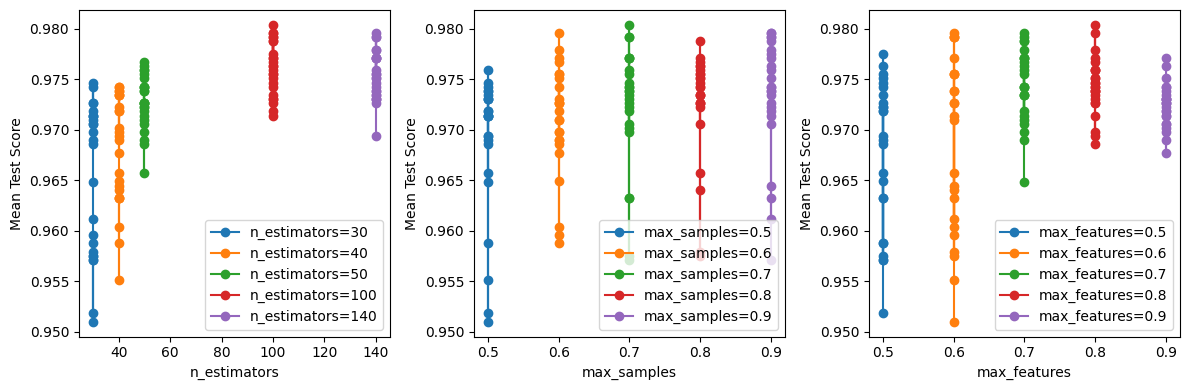

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


75 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Sol

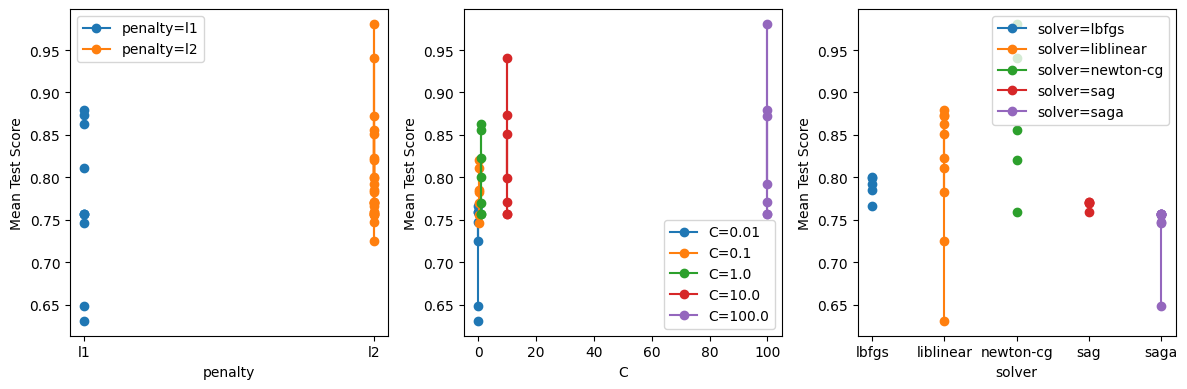

In [ ]:
# create a list of hyperparameters
bg_hyperparameters = {
    'n_estimators': [30, 40, 50,100,140],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9]
}
bagging = BaggingClassifier(random_state=42)
best_bagging_classifier_blsmote_data,bg_blsmote_params,bg_blsmote_scores,bg_grid_blsmote = complete_pass(bagging,bg_hyperparameters,X_train_blsmote,y_train_blsmote,'best_bagging_classifier_blsmote_data')

lg_hyperparameters = {'penalty': ['l1', 'l2'], 
                   'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                   'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lg = LogisticRegression(random_state=42)
best_logistic_regression_blsmote_data,lg_blsmote_params,lg_blsmote_scores,lg_grid_blsmote =  complete_pass(lg,lg_hyperparameters,X_train_blsmote,y_train_blsmote,'best_logistic_regression_blsmote_data')


Fitting 5 folds for each of 24 candidates, totalling 120 fits


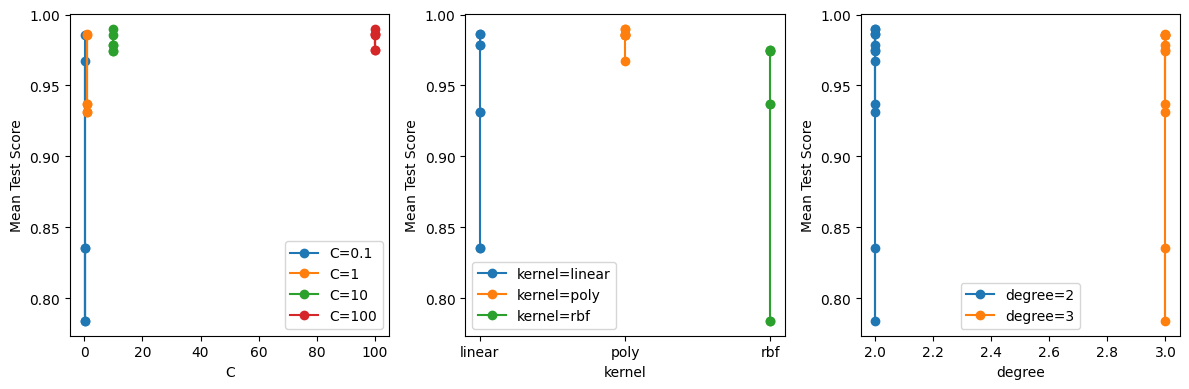

In [ ]:
# create a list of hyperparameters
svc_hyperparameters = {
    'C': [0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3]
}

# create an SVC object
svc = SVC(random_state=42,gamma='auto')

best_blsmote_svc, svc_blsmote_params, svc_blsmote_scores,svc_grid_blsmote = complete_pass(svc,svc_hyperparameters,X_train_blsmote,y_train_blsmote,'best_blsmote_svc')

In [ ]:

# create a list of models
models = [
    best_logistic_regression_blsmote_data,
    best_blsmote_svc,
    best_bagging_classifier_blsmote_data,
]
df_scores = run(X_train_blsmote, y_train_blsmote, X_test, y_test, models)

bc_index = df_scores[(df_scores['Model'] == best_bagging_classifier_blsmote_data)].index[0]
bg_blsmote_scores = bg_grid_blsmote.cv_results_['mean_test_score']
best_bg_index = np.argmax(bg_blsmote_scores)
best_bg_cv_score = bg_blsmote_scores[best_bg_index]
df_scores.loc[bc_index, ['CV Accuracy']] = best_bg_cv_score


lr_index = df_scores[(df_scores['Model'] == best_logistic_regression_blsmote_data) ].index[0]
lg_blsmote_scores = np.nan_to_num(lg_blsmote_scores)
best_lg_index = np.argmax(lg_blsmote_scores)
best_lg_cv_score = lg_blsmote_scores[best_lg_index]
df_scores.loc[lr_index, ['CV Accuracy']] = best_lg_cv_score


svc_index = df_scores[(df_scores['Model'] == best_blsmote_svc) ].index[0]
best_svc_index = np.argmax(svc_blsmote_scores)
best_svc_cv_score = svc_blsmote_scores[best_svc_index]
df_scores.loc[svc_index, ['CV Accuracy']] = best_svc_cv_score


df_scores.head()

Model  Train Accuracy  \
1  SVC(C=10, degree=2, gamma='auto', kernel='poly...        1.000000   
0  LogisticRegression(C=100.0, random_state=42, s...        0.994281   
2  (DecisionTreeClassifier(random_state=195292617...        1.000000   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
1       0.993243         1.000000        0.993581      1.000000     0.993243   
0       0.986486         0.994284        0.986985      0.994281     0.986486   
2       0.972973         1.000000        0.972851      1.000000     0.972973   

   Train F1   Test F1  CV Accuracy  
1  1.000000  0.993243     0.989795  
0  0.994274  0.986502     0.980811  
2  1.000000  0.972423     0.980403

## Adasyn Data

Fitting 5 folds for each of 125 candidates, totalling 625 fits


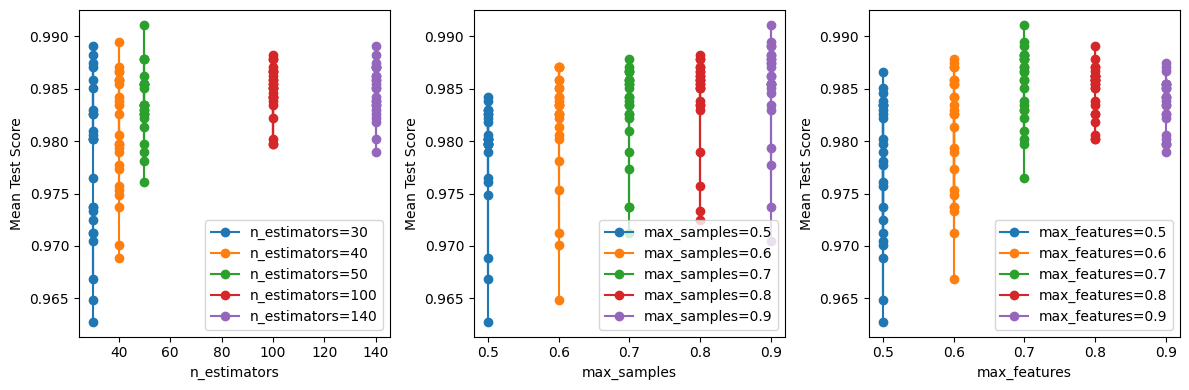

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


200 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: So

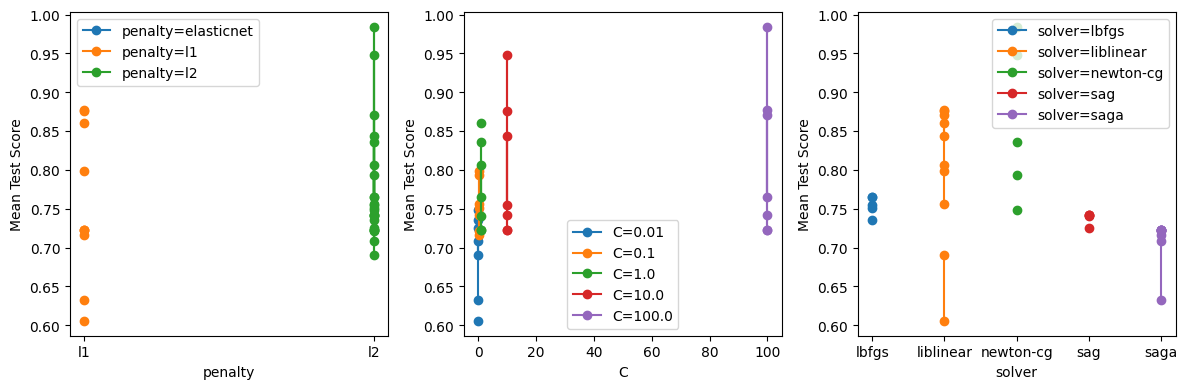

In [ ]:
# create a list of hyperparameters
bg_hyperparameters = {
    'n_estimators': [30, 40, 50,100,140],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9]
}
bagging = BaggingClassifier(random_state=42)
best_bagging_classifier_adasyn_data,bg_adasyn_params,bg_adasyn_scores ,bg_grid_adasyn = complete_pass(bagging,bg_hyperparameters,X_train_adasyn,y_train_adasyn,'best_bagging_classifier_adasyn_data')

lg_hyperparameters = {'penalty': ['l1', 'l2', 'elasticnet'], 
                   'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                   'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lg = LogisticRegression(random_state=42)
best_logistic_regression_adasyn_data,lg_adasyn_params,lg_adasyn_scores ,lg_grid_adasyn = complete_pass(lg,lg_hyperparameters,X_train_adasyn,y_train_adasyn,'best_logistic_regression_adasyn_data')


Fitting 5 folds for each of 24 candidates, totalling 120 fits


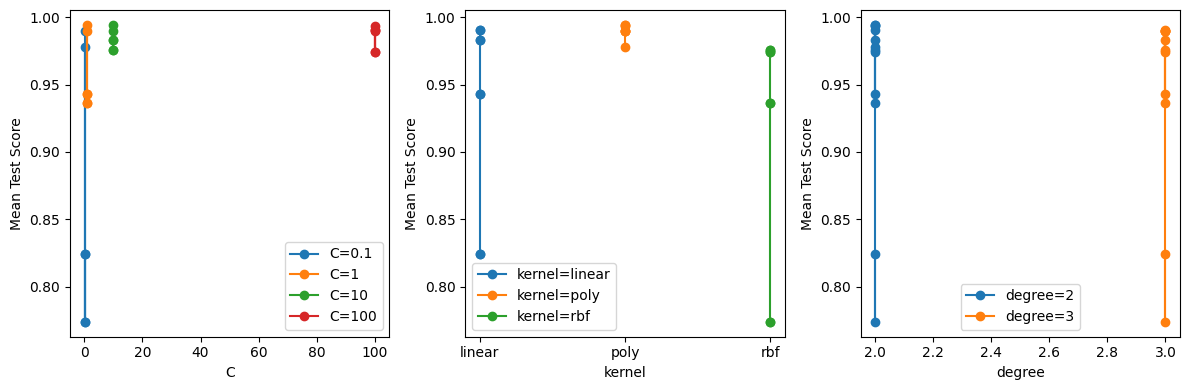

In [ ]:
# create a list of hyperparameters
svc_hyperparameters = {
    'C': [0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3]
}

# create an SVC object
svc = SVC(random_state=42,gamma='auto')

best_adasyn_svc, svc_adasyn_params, svc_adasyn_scores,svc_grid_adasyn = complete_pass(svc,svc_hyperparameters,X_train_adasyn,y_train_adasyn,'best_adasyn_svc')

In [ ]:
# create a list of models
models = [
    best_bagging_classifier_adasyn_data,
    best_adasyn_svc,
    best_logistic_regression_adasyn_data,
]
df_scores = run(X_train_adasyn, y_train_adasyn, X_test, y_test, models)

# find the index of the Bagging Classifier and Logistic Regression rows in df_scores
bc_index = df_scores[(df_scores['Model'] == best_bagging_classifier_adasyn_data)].index[0]
bg_adasyn_scores = bg_grid_adasyn.cv_results_['mean_test_score']
best_bg_index = np.argmax(bg_adasyn_scores)
best_bg_cv_score = bg_adasyn_scores[best_bg_index]
df_scores.loc[bc_index, ['CV Accuracy']] = best_bg_cv_score


lr_index = df_scores[(df_scores['Model'] == best_logistic_regression_adasyn_data) ].index[0]
lg_adasyn_scores = np.nan_to_num(lg_adasyn_scores)
best_lg_index = np.argmax(lg_adasyn_scores)
best_lg_cv_score = lg_adasyn_scores[best_lg_index]
df_scores.loc[lr_index, ['CV Accuracy']] = best_lg_cv_score

svc_index = df_scores[(df_scores['Model'] == best_adasyn_svc) ].index[0]
best_svc_index = np.argmax(svc_adasyn_scores)
best_svc_cv_score = svc_adasyn_scores[best_svc_index]
df_scores.loc[svc_index, ['CV Accuracy']] = best_svc_cv_score


df_scores.head()

Model  Train Accuracy  \
1  SVC(C=10, degree=2, gamma='auto', kernel='poly...        1.000000   
2  LogisticRegression(C=100.0, random_state=42, s...        0.991501   
0  (DecisionTreeClassifier(random_state=195292617...        1.000000   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
1       0.993243         1.000000        0.993581      1.000000     0.993243   
2       0.986486         0.991518        0.986985      0.991501     0.986486   
0       0.986486         1.000000        0.986486      1.000000     0.986486   

   Train F1   Test F1  CV Accuracy  
1  1.000000  0.993243     0.994335  
2  0.991494  0.986502     0.984626  
0  1.000000  0.986486     0.991100

## Normal BMI Data

Fitting 5 folds for each of 125 candidates, totalling 625 fits


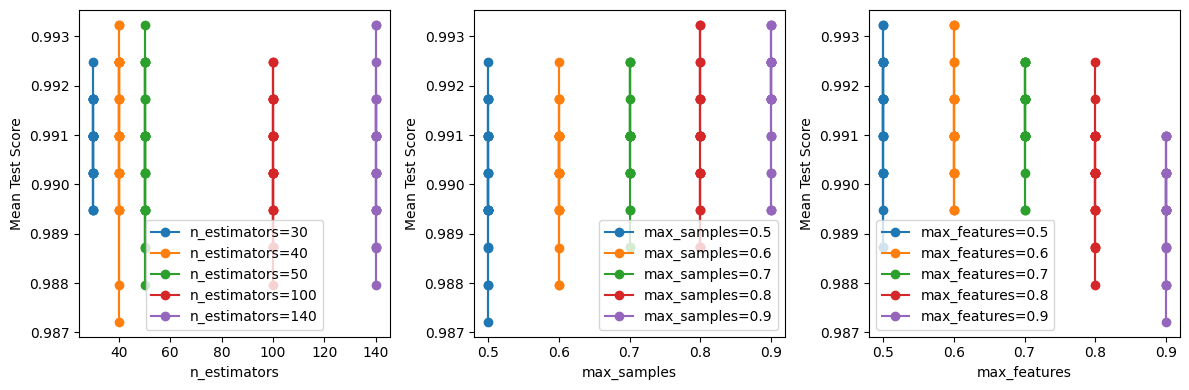

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


200 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: So

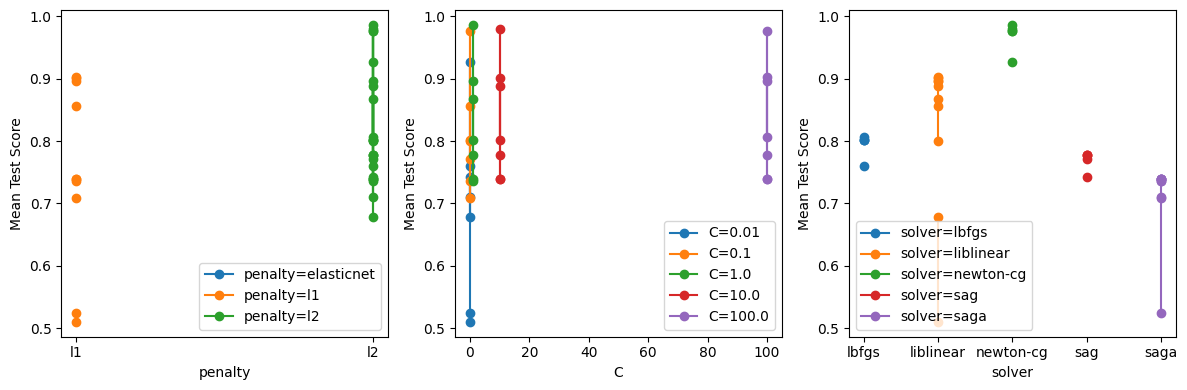

In [ ]:
# create a list of hyperparameters
bg_hyperparameters = {
    'n_estimators': [30, 40, 50,100,140],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9]
}
bagging = BaggingClassifier(random_state=42)
best_bagging_classifier_normal_data_with_bmi,bg_normal_bmi,bg_bmi_scores ,bg_grid_normal_bmi = complete_pass(bagging,bg_hyperparameters,X_train_BMI,y_train_BMI,'best_bagging_classifier_normal_bmi_data')

lg_hyperparameters = {'penalty': ['l1', 'l2', 'elasticnet'], 
                   'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                   'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lg = LogisticRegression(random_state=42)
best_logistic_regression_normal_data_with_bmi,lg_normal_bmi,lg_bmi_scores,lg_grid_normal_bmi = complete_pass(lg,lg_hyperparameters,X_train_BMI,y_train_BMI,'best_logistic_regression_normal_bmi_data')


Fitting 5 folds for each of 36 candidates, totalling 180 fits


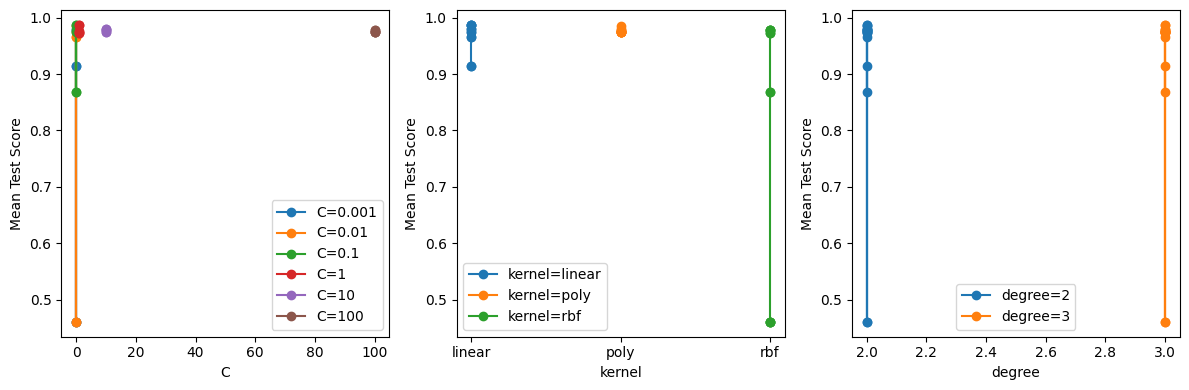

In [31]:
# create a list of hyperparameters
svc_hyperparameters = {
    'C': [1e-3,1e-2,0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3]
}

# create an SVC object
svc = SVC(random_state=42,gamma='auto')

best_normal_bmi_svc, svc_normal_bmi_params, svc_normal_bmi_scores,svc_grid_normal_bmi = complete_pass(svc,svc_hyperparameters,X_train_BMI,y_train_BMI,'best_normal_bmi_svc')

In [ ]:

# create a list of models
models = [
    best_bagging_classifier_normal_data_with_bmi,
    best_normal_bmi_svc,
    best_logistic_regression_normal_data_with_bmi,
]
df_scores_bmi = run(X_train_BMI, y_train_BMI, X_test_BMI, y_test_BMI, models)

# find the index of the Bagging Classifier and Logistic Regression rows in df_scores
bc_index = df_scores_bmi[(df_scores_bmi['Model'] == best_bagging_classifier_normal_data_with_bmi)].index[0]
bg_bmi_scores = bg_grid_normal_bmi.cv_results_['mean_test_score']
best_bg_index = np.argmax(bg_bmi_scores)
best_bg_cv_score = bg_bmi_scores[best_bg_index]
df_scores_bmi.loc[bc_index, ['CV Accuracy']] = best_bg_cv_score

lr_index = df_scores_bmi[(df_scores_bmi['Model'] == best_logistic_regression_normal_data_with_bmi) ].index[0]
lg_bmi_scores = np.nan_to_num(lg_bmi_scores)
best_lg_index = np.argmax(lg_bmi_scores)
best_lg_cv_score = lg_bmi_scores[best_lg_index]
df_scores_bmi.loc[lr_index, ['CV Accuracy']] = best_lg_cv_score

svc_index = df_scores_bmi[(df_scores_bmi['Model'] == best_normal_bmi_svc) ].index[0]
best_svc_index = np.argmax(svc_normal_bmi_scores)
best_svc_cv_score = svc_normal_bmi_scores[best_svc_index]
df_scores_bmi.loc[svc_index, ['CV Accuracy']] = best_svc_cv_score


df_scores_bmi.head()

Model  Train Accuracy  \
0  (DecisionTreeClassifier(random_state=195292617...        1.000000   
2  LogisticRegression(random_state=42, solver='ne...        0.996990   
1  SVC(C=0.1, degree=2, gamma='auto', kernel='lin...        0.992476   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
0       1.000000         1.000000        1.000000      1.000000     1.000000   
2       0.993243         0.996990        0.993581      0.996990     0.993243   
1       0.986486         0.992578        0.986985      0.992476     0.986486   

   Train F1   Test F1  CV Accuracy  
0  1.000000  1.000000     0.993233  
2  0.996984  0.993243     0.986466  
1  0.992491  0.986502     0.987212

## Blsmote BMI Data

Fitting 5 folds for each of 125 candidates, totalling 625 fits


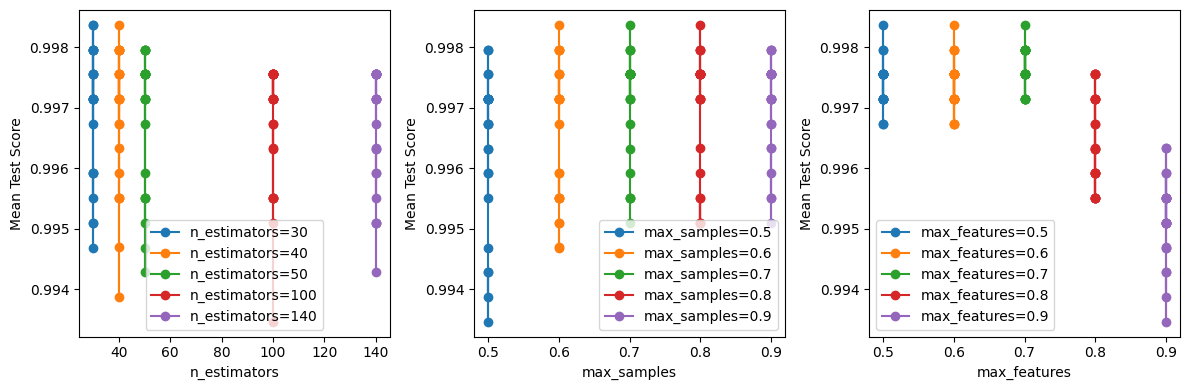

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


200 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: So

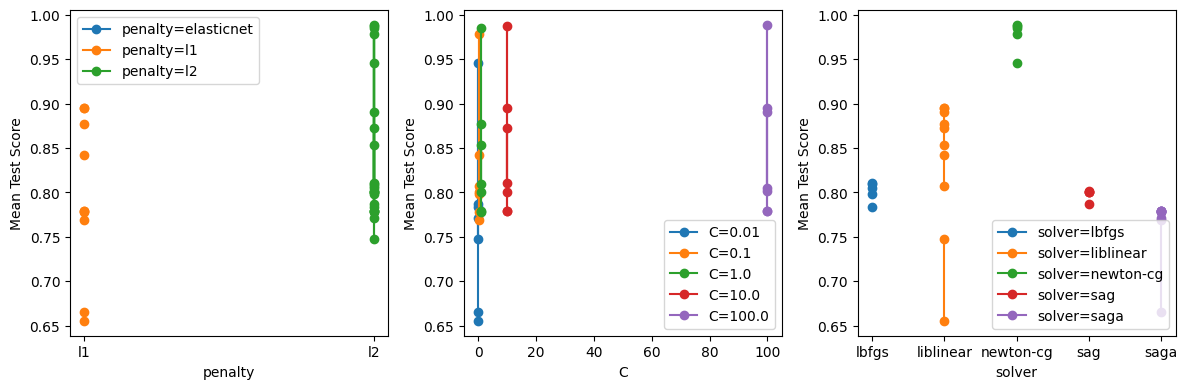

In [ ]:
# create a list of hyperparameters
bg_hyperparameters = {
    'n_estimators': [30, 40, 50,100,140],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9]
}
bagging = BaggingClassifier(random_state=42)
best_bagging_classifier_blsmote_data_with_bmi,bg_bmi_ros_params,bg_bmi_ros_scores,bg_grid_blsmote_bmi = complete_pass(bagging,bg_hyperparameters,X_train_blsmote_BMI,y_train_blsmote_BMI,'best_bagging_classifier_blsmote_bmi_data')

lg_hyperparameters = {'penalty': ['l1', 'l2', 'elasticnet'], 
                   'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                   'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lg = LogisticRegression(random_state=42)
best_logistic_regression_blsmote_data_with_bmi,lg_bmi_ros_params,lg_bmi_ros_scores,lg_grid_blsmote_bmi = complete_pass(lg,lg_hyperparameters,X_train_blsmote_BMI,y_train_blsmote_BMI,'best_logistic_regression_blsmote_bmi_data')



Fitting 5 folds for each of 72 candidates, totalling 360 fits


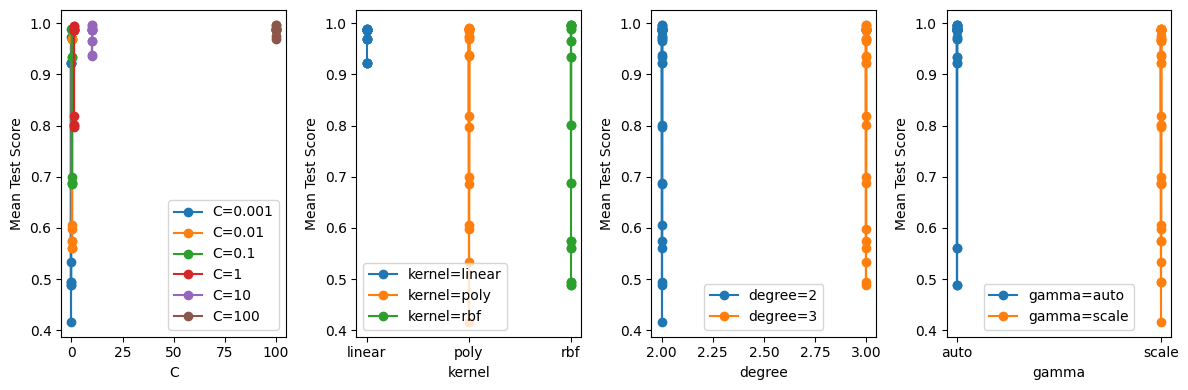

In [32]:
# create a list of hyperparameters
svc_hyperparameters = {
    'C': [1e-3,1e-2,0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3],
    'gamma': ['scale', 'auto']
}

# create an SVC object
svc = SVC(random_state=42)

best_blsmote_bmi_svc, svc_blsmote_bmi_params, svc_blsmote_bmi_scores,svc_grid_blsmote_bmi = complete_pass(svc,svc_hyperparameters,X_train_blsmote_BMI,y_train_blsmote_BMI,'best_blsmote_bmi_svc')

In [ ]:
best_blsmote_bmi_svc

SVC(C=10, degree=2, gamma='auto', random_state=42)

In [ ]:

# create a list of models
models = [
    best_bagging_classifier_blsmote_data_with_bmi,
    best_blsmote_bmi_svc,
    best_logistic_regression_blsmote_data_with_bmi,  
]
df_scores_bmi = run(X_train_blsmote_BMI, y_train_blsmote_BMI, X_test_BMI, y_test_BMI, models)

# find the index of the Bagging Classifier and Logistic Regression rows in df_scores
bc_index = df_scores_bmi[(df_scores_bmi['Model'] == best_bagging_classifier_blsmote_data_with_bmi)].index[0]
bg_bmi_ros_scores = bg_grid_blsmote.cv_results_['mean_test_score']
best_bg_index = np.argmax(bg_bmi_ros_scores)
best_bg_cv_score = bg_bmi_ros_scores[best_bg_index]
df_scores_bmi.loc[bc_index, ['CV Accuracy']] = best_bg_cv_score

lr_index = df_scores_bmi[(df_scores_bmi['Model'] == best_logistic_regression_blsmote_data_with_bmi) ].index[0]
lg_bmi_ros_scores = np.nan_to_num(lg_bmi_ros_scores)
best_lg_index = np.argmax(lg_bmi_ros_scores)
best_lg_cv_score = lg_bmi_ros_scores[best_lg_index]
df_scores_bmi.loc[lr_index, ['CV Accuracy']] = best_lg_cv_score

svc_index = df_scores_bmi[(df_scores_bmi['Model'] == best_blsmote_bmi_svc) ].index[0]
best_svc_index = np.argmax(svc_blsmote_bmi_scores)
best_svc_cv_score = svc_blsmote_bmi_scores[best_svc_index]
df_scores_bmi.loc[svc_index, ['CV Accuracy']] = best_svc_cv_score


df_scores_bmi.head()

Model  Train Accuracy  \
0  (DecisionTreeClassifier(random_state=195292617...        1.000000   
2  LogisticRegression(C=100.0, random_state=42, s...        0.997141   
1  SVC(C=10, degree=2, gamma='auto', random_state...        1.000000   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
0       0.993243         1.000000        0.993404      1.000000     0.993243   
2       0.979730         0.997146        0.980696      0.997141     0.979730   
1       0.972973         1.000000        0.973509      1.000000     0.972973   

   Train F1   Test F1  CV Accuracy  
0  1.000000  0.993259     0.980403  
2  0.997141  0.979597     0.988567  
1  1.000000  0.972600     0.996734

## Adasyn BMI Data

Fitting 5 folds for each of 125 candidates, totalling 625 fits


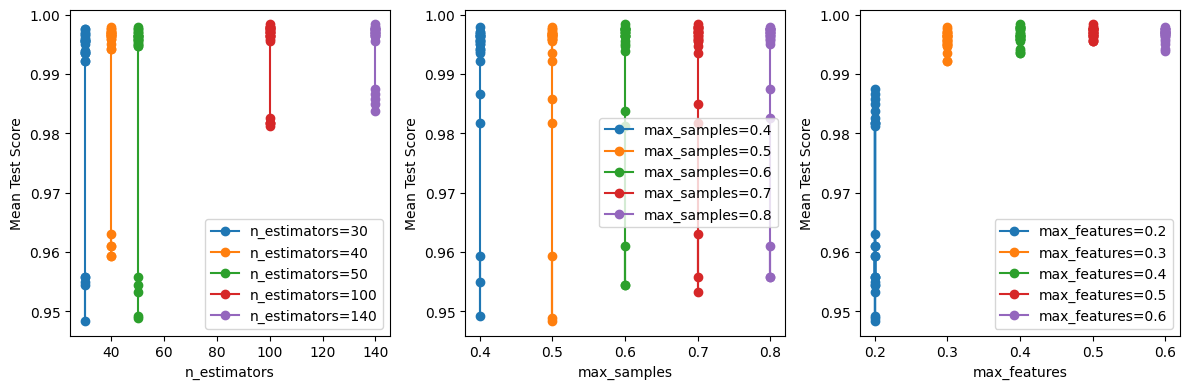

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


200 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: So

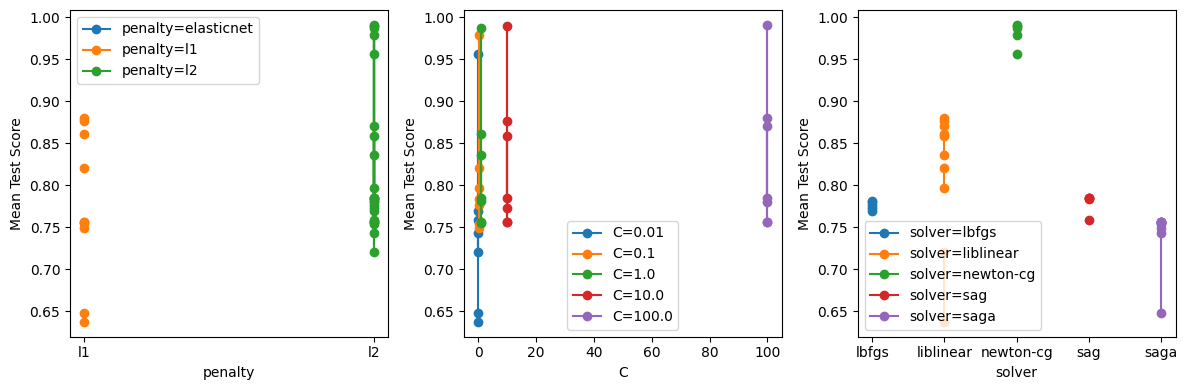

In [ ]:
# create a list of hyperparameters
bg_hyperparameters = {
    'n_estimators': [30, 40, 50,100,140],
    'max_samples': [0.4,0.5, 0.6, 0.7, 0.8],
    'max_features': [0.2,0.3,0.4,0.5, 0.6]
}
bagging = BaggingClassifier(random_state=42)
best_bagging_classifier_adasyn_data_with_bmi,bg_bmi_adasyn_params,bg_bmi_adasyn_scores,bg_grid_adasyn_bmi = complete_pass(bagging,bg_hyperparameters,X_train_adasyn_BMI,y_train_adasyn_BMI,'best_bagging_classifier_adasyn_bmi_data')

lg_hyperparameters = {'penalty': ['l1', 'l2', 'elasticnet'], 
                   'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                   'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lg = LogisticRegression(random_state=42)
best_logistic_regression_adasyn_data_with_bmi,lg_bmi_adasyn_params,lg_bmi_adasyn_scores,lg_grid_adasyn_bmi = complete_pass(lg,lg_hyperparameters,X_train_adasyn_BMI,y_train_adasyn_BMI,'best_logistic_regression_adasyn_bmi_data')

Fitting 5 folds for each of 63 candidates, totalling 315 fits


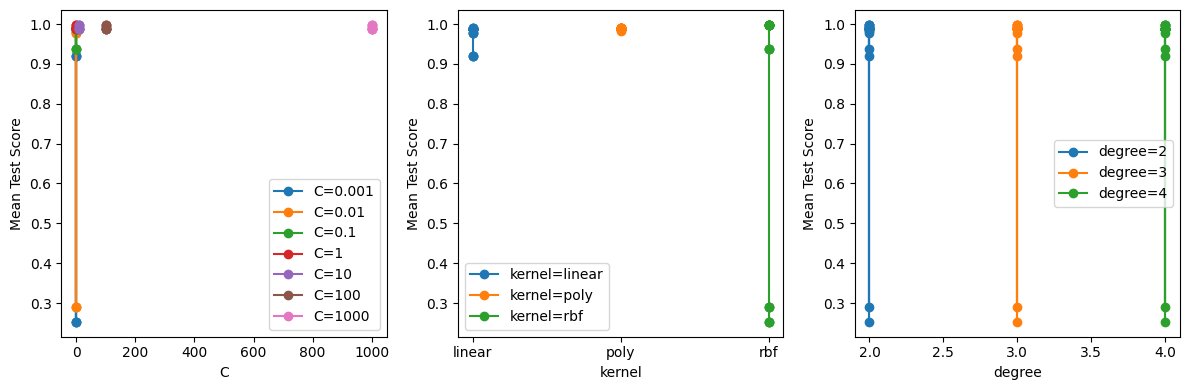

In [ ]:
# create a list of hyperparameters
svc_hyperparameters = {
    'C': [10**i for i in range(-3, 4)],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3,4],
}

# create an SVC object
svc = SVC(random_state=42,gamma='auto')

best_adasyn_bmi_svc, svc_adasyn_bmi_params, svc_adasyn_bmi_scores,svc_grid_adasyn_bmi = complete_pass(svc,svc_hyperparameters,X_train_adasyn_BMI,y_train_adasyn_BMI,'best_adasyn_bmi_svc')

In [ ]:

# create a list of models
models = [
    best_bagging_classifier_adasyn_data_with_bmi,
    best_adasyn_bmi_svc,
    best_logistic_regression_adasyn_data_with_bmi,  
]
df_scores_bmi = run(X_train_adasyn_BMI, y_train_adasyn_BMI, X_test_BMI, y_test_BMI, models)

# find the index of the Bagging Classifier and Logistic Regression rows in df_scores
bc_index = df_scores_bmi[(df_scores_bmi['Model'] == best_bagging_classifier_adasyn_data_with_bmi)].index[0]
bg_bmi_adasyn_scores = bg_grid_adasyn_bmi.cv_results_['mean_test_score']
best_bg_index = np.argmax(bg_bmi_adasyn_scores)
best_bg_cv_score = bg_bmi_adasyn_scores[best_bg_index]
df_scores_bmi.loc[bc_index, ['CV Accuracy']] = best_bg_cv_score

lr_index = df_scores_bmi[(df_scores_bmi['Model'] == best_logistic_regression_adasyn_data_with_bmi) ].index[0]
lg_bmi_adasyn_scores = np.nan_to_num(lg_bmi_adasyn_scores)
best_lg_index = np.argmax(lg_bmi_adasyn_scores)
best_lg_cv_score = lg_bmi_adasyn_scores[best_lg_index]
df_scores_bmi.loc[lr_index, ['CV Accuracy']] = best_lg_cv_score


svc_index = df_scores_bmi[(df_scores_bmi['Model'] == best_adasyn_bmi_svc) ].index[0]
best_svc_index = np.argmax(svc_adasyn_bmi_scores)
best_svc_cv_score = svc_adasyn_bmi_scores[best_svc_index]
df_scores_bmi.loc[svc_index, ['CV Accuracy']] = best_svc_cv_score


df_scores_bmi.head()

Model  Train Accuracy  \
0  (DecisionTreeClassifier(random_state=195292617...        1.000000   
2  LogisticRegression(C=100.0, random_state=42, s...        0.995937   
1  SVC(C=10, degree=2, gamma='auto', random_state...        1.000000   

   Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  \
0       1.000000         1.000000        1.000000      1.000000     1.000000   
2       0.979730         0.995939        0.980696      0.995937     0.979730   
1       0.966216         1.000000        0.966181      1.000000     0.966216   

   Train F1   Test F1  CV Accuracy  
0  1.000000  1.000000     0.998376  
2  0.995937  0.979597     0.991063  
1  1.000000  0.966043     0.997968

# Regularization & Overfitting analysis

## Logistic Regression Models Analysis 

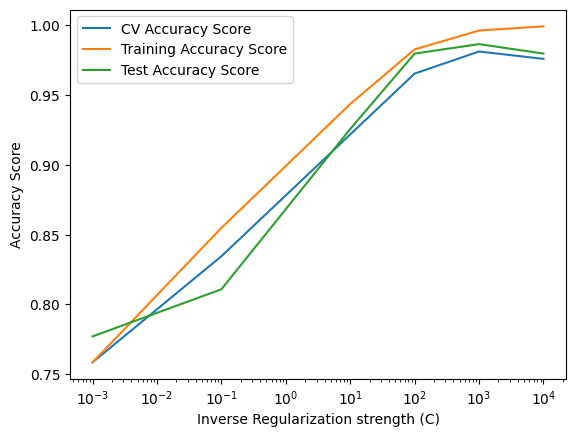

<Figure size 640x480 with 0 Axes>

In [ ]:
c_values = [1e-3, 0.1, 10, 100, 1000,1e4]
train_accuracy_scores = []
test_accuracy_scores = []
cv_accuracy_scores = []

for c in c_values:
    lg = LogisticRegression(random_state=42, solver='newton-cg', C=c)
    scores = cross_val_score(lg, X_train, y_train, cv=5, scoring='accuracy')
    cv_accuracy_scores.append(scores.mean())
    
    trained_lg = train_model(lg, X_train, y_train)
    y_train_pred = predict(trained_lg, X_train, y_train)
    accuracy_train, _, _, _ = evaluate_model(y_train, y_train_pred)
    train_accuracy_scores.append(accuracy_train)

    y_test_pred = predict(trained_lg, X_test, y_test)
    accuracy_test, _, _, _ = evaluate_model(y_test, y_test_pred)
    test_accuracy_scores.append(accuracy_test)

plt.plot(c_values, cv_accuracy_scores, label='CV Accuracy Score')
plt.plot(c_values, train_accuracy_scores, label='Training Accuracy Score')
plt.plot(c_values, test_accuracy_scores, label='Test Accuracy Score')
plt.xscale('log')
plt.xlabel('Inverse Regularization strength (C)')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()
plt.savefig('lg_normal_Accuracy.png')

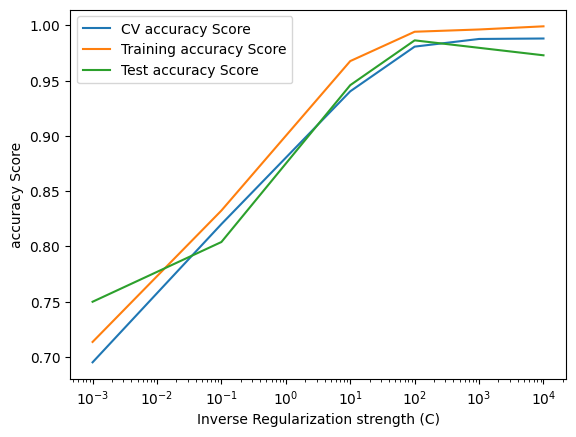

<Figure size 640x480 with 0 Axes>

In [ ]:
c_values = [1e-3, 0.1, 10, 100, 1000,1e4]
train_accuracy_scores = []
test_accuracy_scores = []
cv_accuracy_scores = []

for c in c_values:
    lg = LogisticRegression(random_state=42, solver='newton-cg', C=c)
    scores = cross_val_score(lg, X_train_blsmote, y_train_blsmote, cv=5, scoring='accuracy')
    cv_accuracy_scores.append(scores.mean())
    
    trained_lg = train_model(lg, X_train_blsmote, y_train_blsmote)
    y_train_pred = predict(trained_lg, X_train_blsmote, y_train_blsmote)
    accuracy_train, _, _, _ = evaluate_model(y_train_blsmote, y_train_pred)
    train_accuracy_scores.append(accuracy_train)

    y_test_pred = predict(trained_lg, X_test, y_test)
    accuracy_test, _, _, _ = evaluate_model(y_test, y_test_pred)
    test_accuracy_scores.append(accuracy_test)

plt.plot(c_values, cv_accuracy_scores, label='CV accuracy Score')
plt.plot(c_values, train_accuracy_scores, label='Training accuracy Score')
plt.plot(c_values, test_accuracy_scores, label='Test accuracy Score')
plt.xscale('log')
plt.xlabel('Inverse Regularization strength (C)')
plt.ylabel('accuracy Score')
plt.legend()
plt.show()
plt.savefig('lg_blsmote_accuracy.png')

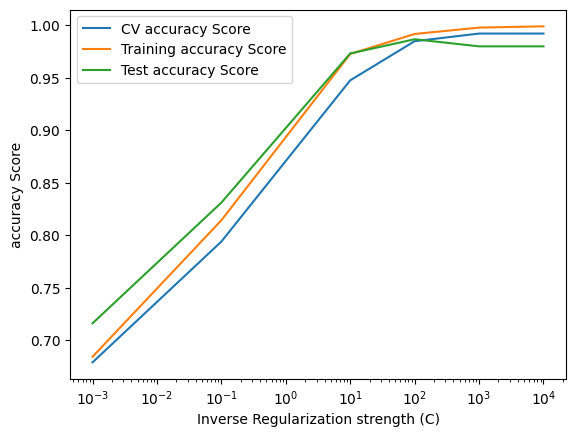

<Figure size 640x480 with 0 Axes>

In [ ]:

c_values = [1e-3, 0.1, 10, 100, 1000,1e4]
train_accuracy_scores = []
test_accuracy_scores = []
cv_accuracy_scores = []

for c in c_values:
    lg = LogisticRegression(random_state=42, solver='newton-cg', C=c)
    scores = cross_val_score(lg, X_train_adasyn, y_train_adasyn, cv=5, scoring='accuracy')
    cv_accuracy_scores.append(scores.mean())
    
    trained_lg = train_model(lg, X_train_adasyn, y_train_adasyn)
    y_train_pred = predict(trained_lg, X_train_adasyn, y_train_adasyn)
    accuracy_train, _, _, _ = evaluate_model(y_train_adasyn, y_train_pred)
    train_accuracy_scores.append(accuracy_train)

    y_test_pred = predict(trained_lg, X_test, y_test)
    accuracy_test, _, _, _ = evaluate_model(y_test, y_test_pred)
    test_accuracy_scores.append(accuracy_test)

plt.plot(c_values, cv_accuracy_scores, label='CV accuracy Score')
plt.plot(c_values, train_accuracy_scores, label='Training accuracy Score')
plt.plot(c_values, test_accuracy_scores, label='Test accuracy Score')
plt.xscale('log')
plt.xlabel('Inverse Regularization strength (C)')
plt.ylabel('accuracy Score')
plt.legend()
plt.show()
plt.savefig('lg_adasyn_accuracy.png')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.



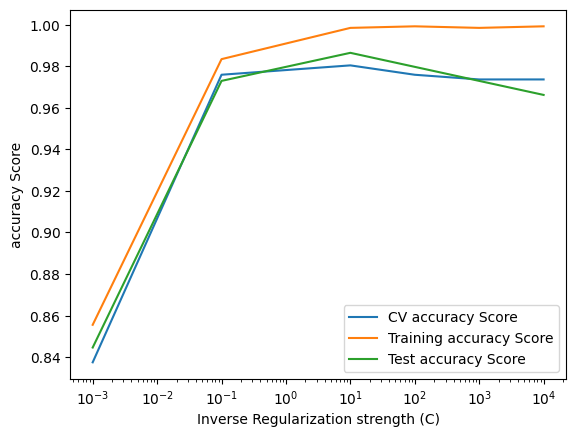

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/util

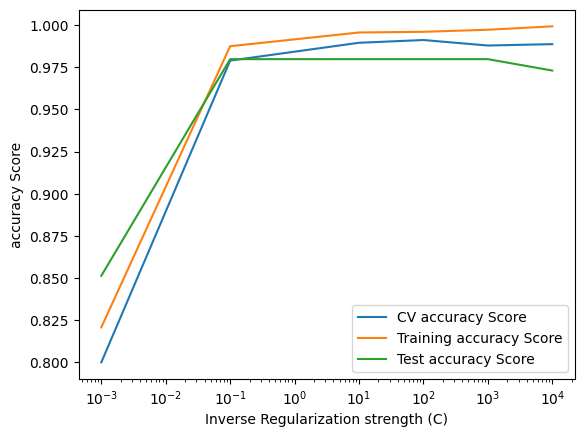

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/util

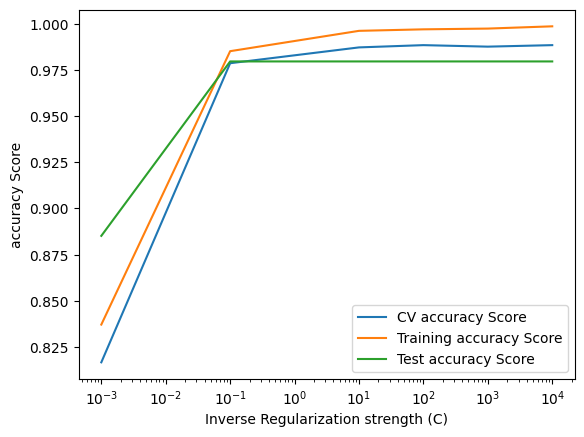

<Figure size 640x480 with 0 Axes>

In [ ]:

c_values = [1e-3, 0.1, 10, 100, 1000,1e4]
train_accuracy_scores = []
test_accuracy_scores = []
cv_accuracy_scores = []

for c in c_values:
    lg = LogisticRegression(random_state=42, solver='newton-cg', C=c)
    scores = cross_val_score(lg, X_train_BMI, y_train_BMI, cv=5, scoring='accuracy')
    cv_accuracy_scores.append(scores.mean())
    
    trained_lg = train_model(lg, X_train_BMI, y_train_BMI)
    y_train_pred = predict(trained_lg, X_train_BMI, y_train_BMI)
    accuracy_train, _, _, _ = evaluate_model(y_train_BMI, y_train_pred)
    train_accuracy_scores.append(accuracy_train)

    y_test_pred = predict(trained_lg, X_test_BMI, y_test_BMI)
    accuracy_test, _, _, _ = evaluate_model(y_test_BMI, y_test_pred)
    test_accuracy_scores.append(accuracy_test)

plt.plot(c_values, cv_accuracy_scores, label='CV accuracy Score')
plt.plot(c_values, train_accuracy_scores, label='Training accuracy Score')
plt.plot(c_values, test_accuracy_scores, label='Test accuracy Score')
plt.xscale('log')
plt.xlabel('Inverse Regularization strength (C)')
plt.ylabel('accuracy Score')
plt.legend()
plt.show()

# #######################################################################################################################
c_values = [1e-3, 0.1, 10, 100, 1000,1e4]
train_accuracy_scores = []
test_accuracy_scores = []
cv_accuracy_scores = []

for c in c_values:
    lg = LogisticRegression(random_state=42, solver='newton-cg', C=c)
    scores = cross_val_score(lg, X_train_adasyn_BMI, y_train_adasyn_BMI, cv=5, scoring='accuracy')
    cv_accuracy_scores.append(scores.mean())
    
    trained_lg = train_model(lg, X_train_adasyn_BMI, y_train_adasyn_BMI)
    y_train_pred = predict(trained_lg, X_train_adasyn_BMI, y_train_adasyn_BMI)
    accuracy_train, _, _, _ = evaluate_model(y_train_adasyn_BMI, y_train_pred)
    train_accuracy_scores.append(accuracy_train)

    y_test_pred = predict(trained_lg, X_test_BMI, y_test_BMI)
    accuracy_test, _, _, _ = evaluate_model(y_test_BMI, y_test_pred)
    test_accuracy_scores.append(accuracy_test)

plt.plot(c_values, cv_accuracy_scores, label='CV accuracy Score')
plt.plot(c_values, train_accuracy_scores, label='Training accuracy Score')
plt.plot(c_values, test_accuracy_scores, label='Test accuracy Score')
plt.xscale('log')
plt.xlabel('Inverse Regularization strength (C)')
plt.ylabel('accuracy Score')
plt.legend()
plt.show()
plt.savefig('lg_adasyn_accuracy.png')


c_values = [1e-3, 0.1, 10, 100, 1000,1e4]
train_accuracy_scores = []
test_accuracy_scores = []
cv_accuracy_scores = []

for c in c_values:
    lg = LogisticRegression(random_state=42, solver='newton-cg', C=c)
    scores = cross_val_score(lg, X_train_blsmote_BMI, y_train_blsmote_BMI, cv=5, scoring='accuracy')
    cv_accuracy_scores.append(scores.mean())
    
    trained_lg = train_model(lg, X_train_blsmote_BMI, y_train_blsmote_BMI)
    y_train_pred = predict(trained_lg, X_train_blsmote_BMI, y_train_blsmote_BMI)
    accuracy_train, _, _, _ = evaluate_model(y_train_blsmote_BMI, y_train_pred)
    train_accuracy_scores.append(accuracy_train)

    y_test_pred = predict(trained_lg, X_test_BMI, y_test_BMI)
    accuracy_test, _, _, _ = evaluate_model(y_test_BMI, y_test_pred)
    test_accuracy_scores.append(accuracy_test)

plt.plot(c_values, cv_accuracy_scores, label='CV accuracy Score')
plt.plot(c_values, train_accuracy_scores, label='Training accuracy Score')
plt.plot(c_values, test_accuracy_scores, label='Test accuracy Score')
plt.xscale('log')
plt.xlabel('Inverse Regularization strength (C)')
plt.ylabel('accuracy Score')
plt.legend()
plt.show()
plt.savefig('lg_adasyn_accuracy.png')

## Bagging Classifier

In [ ]:
def train_cv_test_analysis(grid_search,param_grid,X_train,y_train,title):
  train_scores_normal = grid_search.cv_results_['mean_train_score']
  cv_scores_normal = grid_search.cv_results_['mean_test_score']
  train_scores_normal = np.array(train_scores_normal).reshape(len(param_grid['max_features']), len(param_grid['max_samples']), len(param_grid['n_estimators']))
  cv_scores_normal = np.array(cv_scores_normal).reshape(len(param_grid['max_features']), len(param_grid['max_samples']), len(param_grid['n_estimators']))

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
  
  # plot the effect of max_features on train and CV scores
  axes[0].plot(param_grid['max_features'], train_scores_normal.mean(axis=(1,2)), '-o', label='train')
  axes[0].plot(param_grid['max_features'], cv_scores_normal.mean(axis=(1,2)), '-o', label='CV')
  axes[0].set_xlabel('max_features')
  axes[0].set_ylabel('Accuracy score')
  axes[0].set_title('Effect of max_features on train and CV scores ('+title+')')
  axes[0].legend()

  # plot the effect of max_samples on train and CV scores
  axes[1].plot(param_grid['max_samples'], train_scores_normal.mean(axis=(0,2)), '-o', label='train')
  axes[1].plot(param_grid['max_samples'], cv_scores_normal.mean(axis=(0,2)), '-o', label='CV')
  axes[1].set_xlabel('max_samples')
  axes[1].set_ylabel('Accuracy score')
  axes[1].set_title('Effect of max_samples on train and CV scores ('+title+')')
  axes[1].legend()

  # plot the effect of n_estimators on train and CV scores
  axes[2].plot(param_grid['n_estimators'], train_scores_normal.mean(axis=(0,1)), '-o', label='train')
  axes[2].plot(param_grid['n_estimators'], cv_scores_normal.mean(axis=(0,1)), '-o', label='CV')
  axes[2].set_xlabel('n_estimators')
  axes[2].set_ylabel('Accuracy score')
  axes[2].set_title('Effect of n_estimators on train and CV scores ('+title+')')
  axes[2].legend()
  plt.tight_layout()
  plt.show()
  # return train_scores_normal,cv_scores_normal

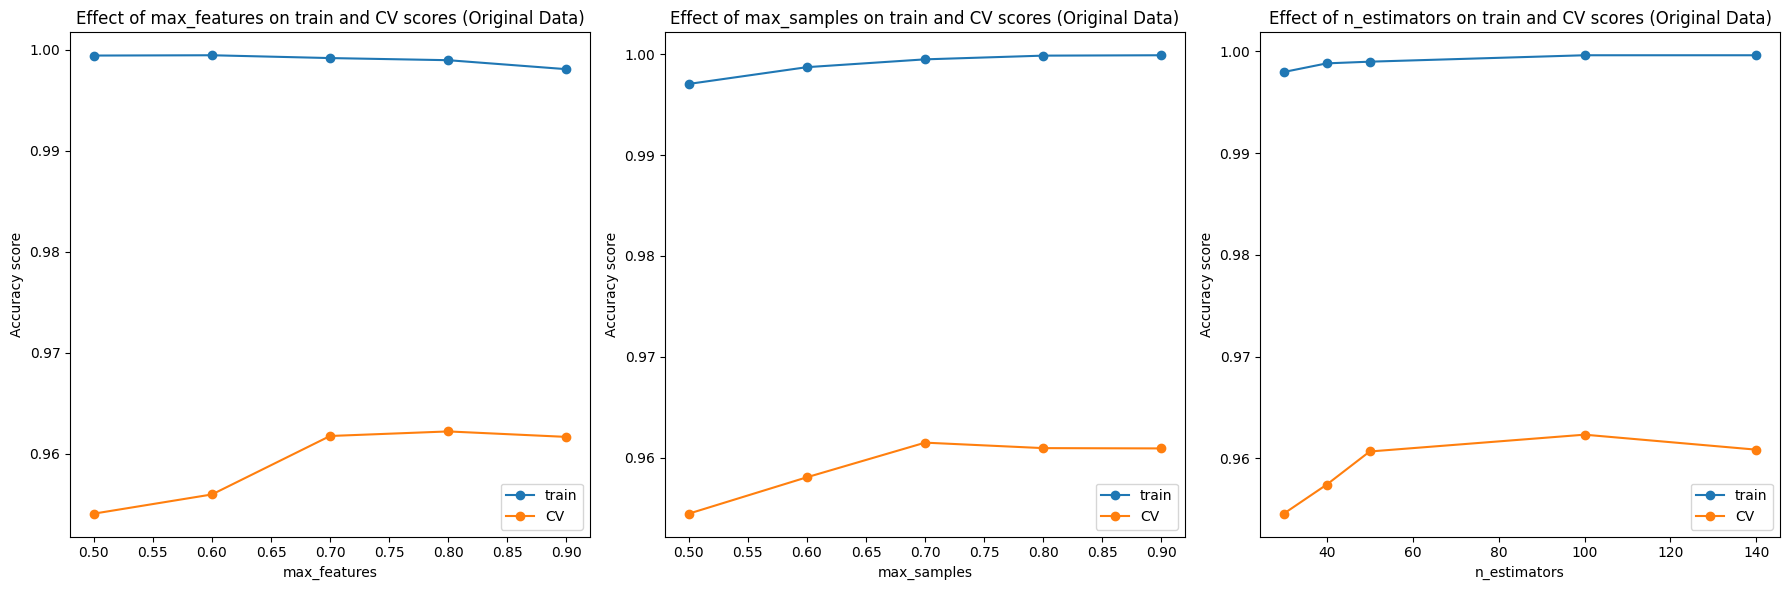

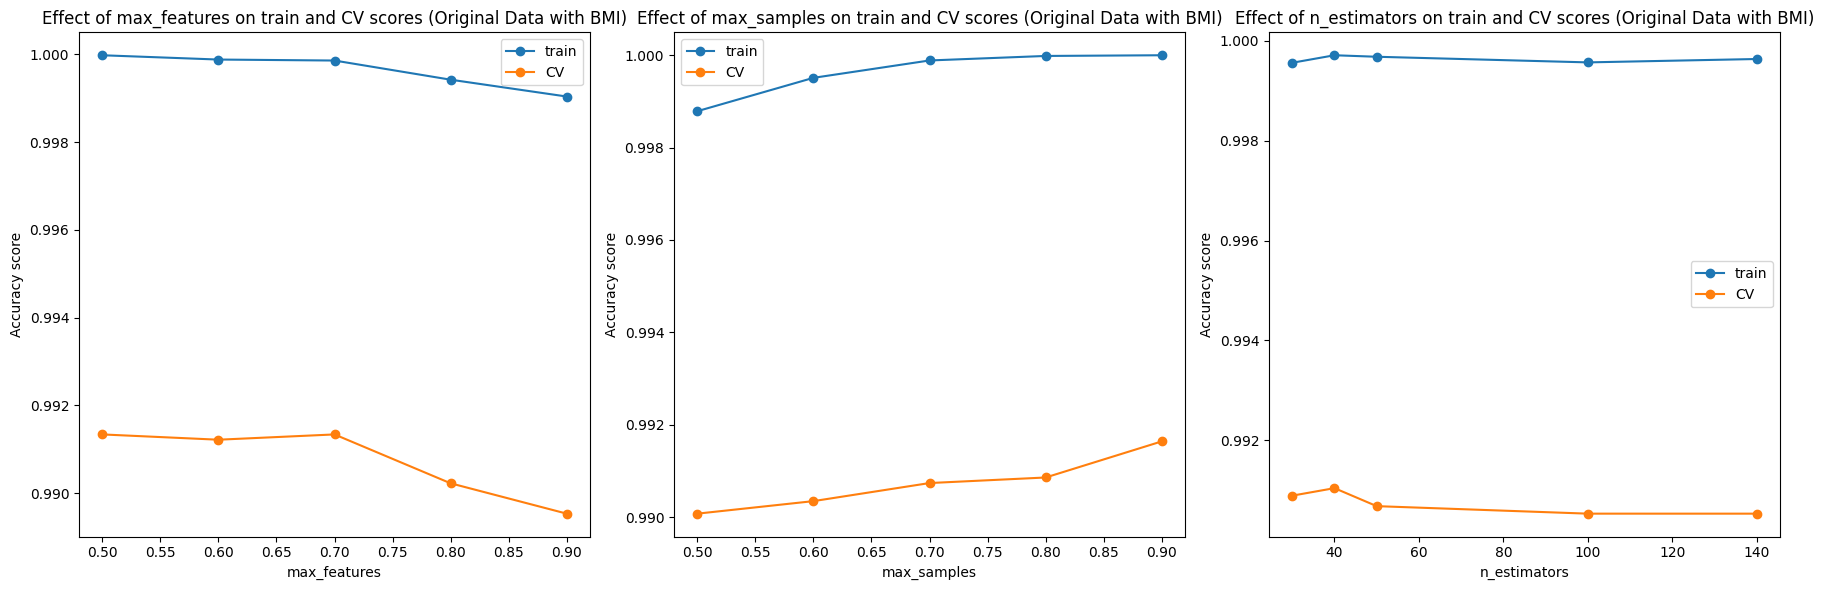

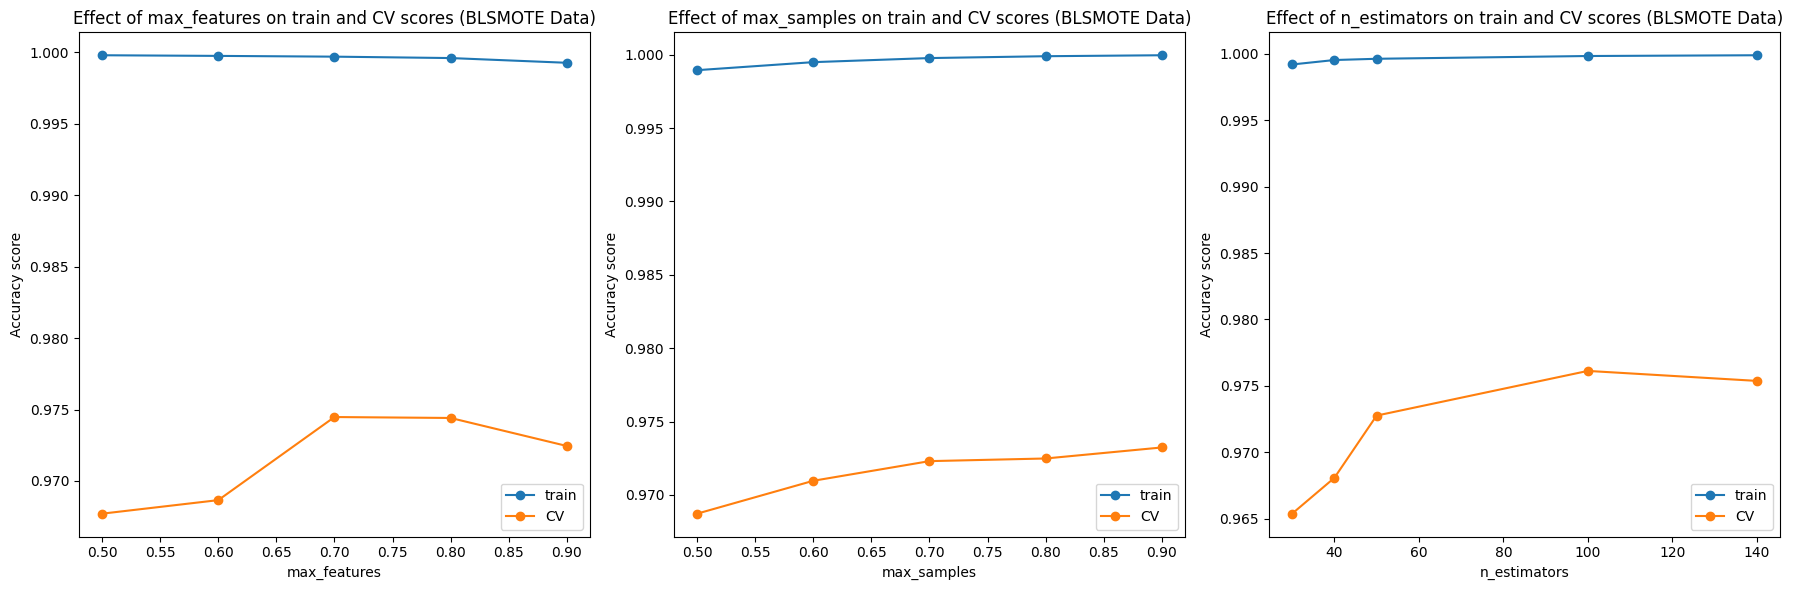

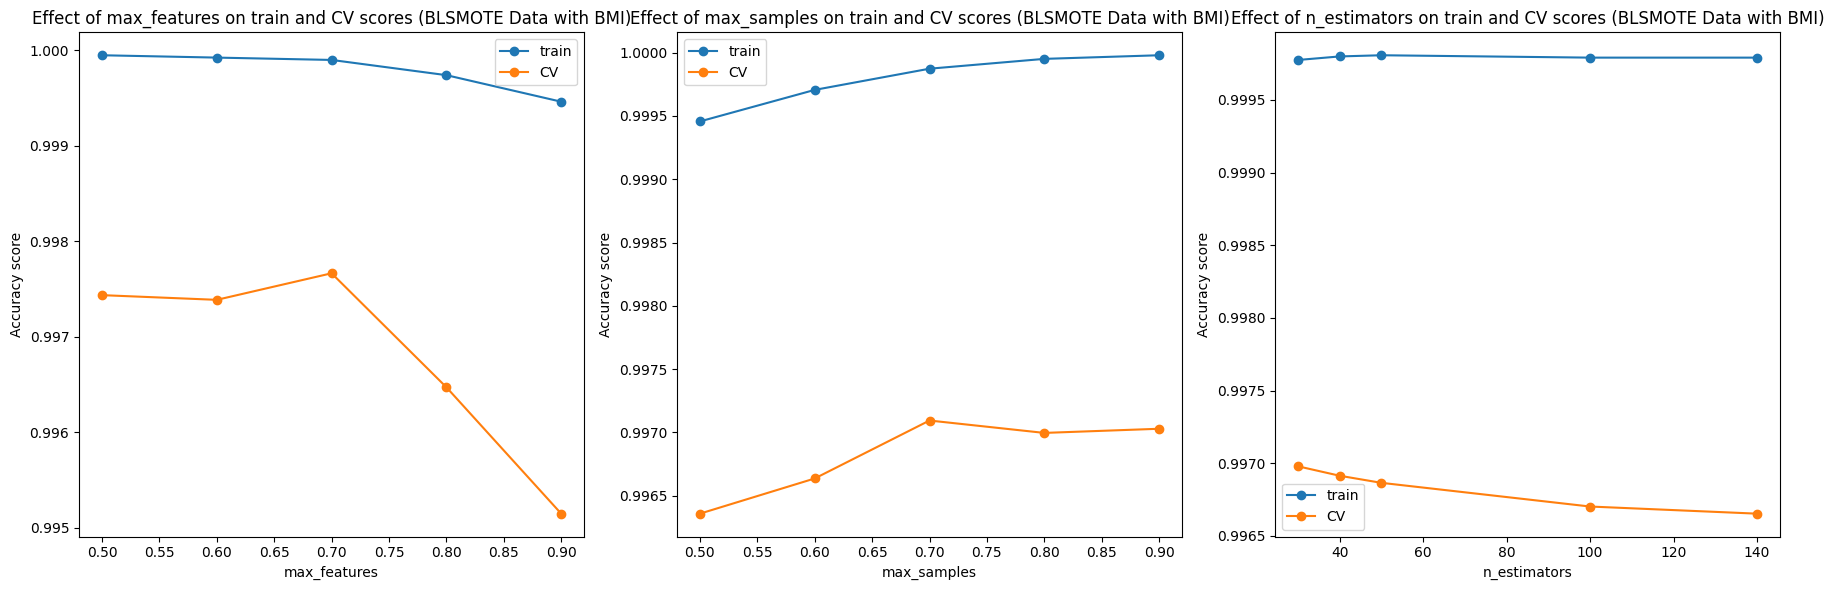

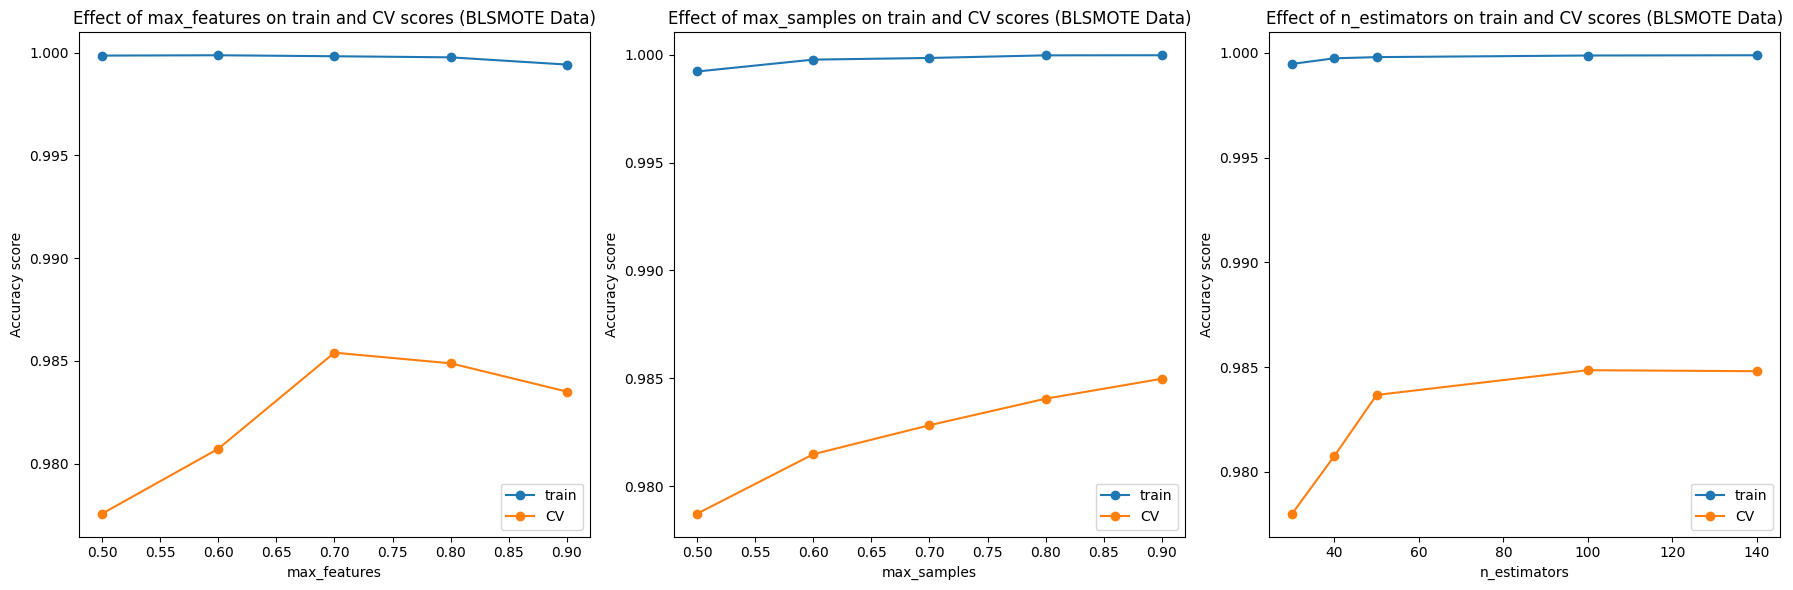

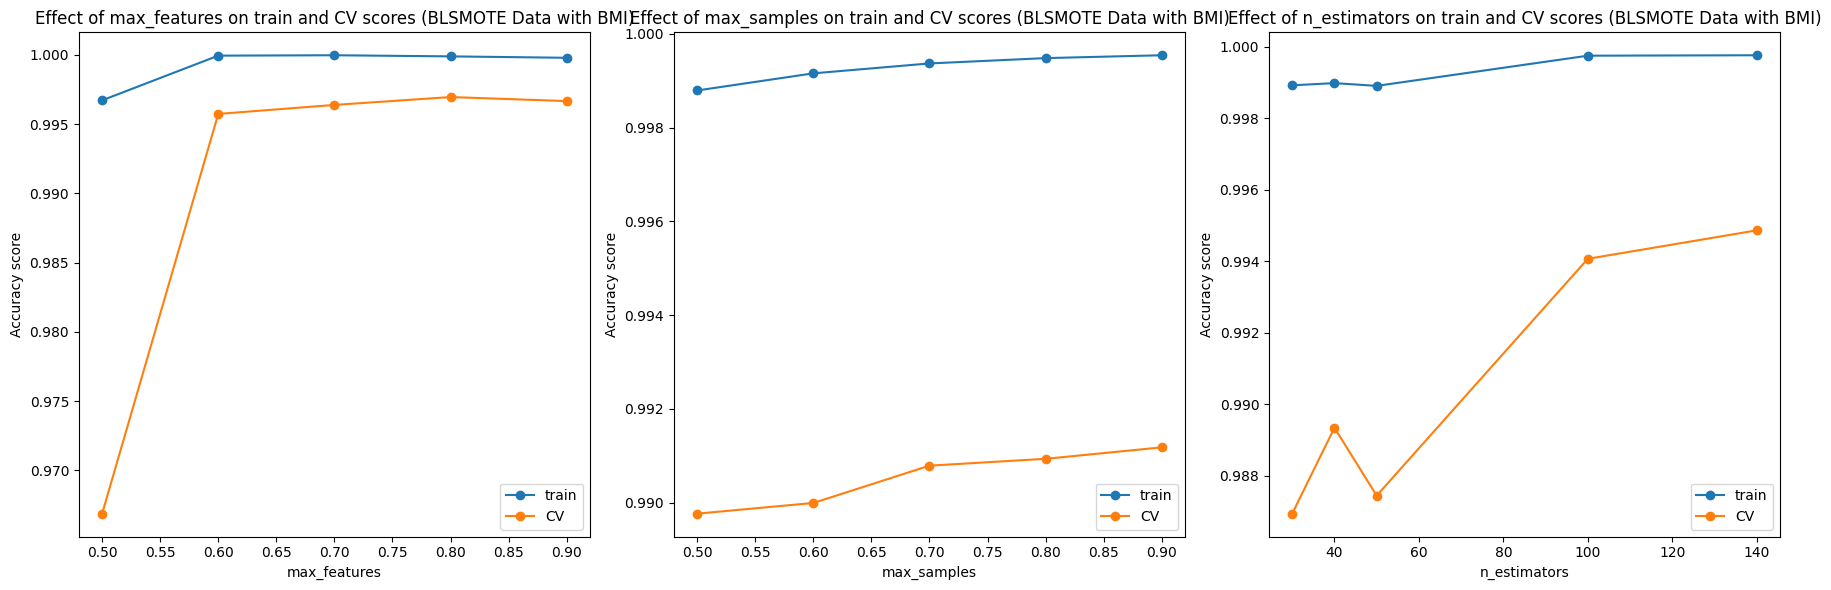

In [ ]:
param_grid = {
    'n_estimators': [30, 40, 50,100,140],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9]
}
train_cv_test_analysis(bg_grid_normal,param_grid,X_train,y_train,'Original Data')
train_cv_test_analysis(bg_grid_normal_bmi,param_grid,X_train_BMI,y_train_BMI,'Original Data with BMI')
train_cv_test_analysis(bg_grid_blsmote,param_grid,X_train_blsmote,y_train_blsmote,'BLSMOTE Data')
train_cv_test_analysis(bg_grid_blsmote_bmi,param_grid,X_train_blsmote_BMI,y_train_blsmote_BMI,'BLSMOTE Data with BMI')
train_cv_test_analysis(bg_grid_adasyn,param_grid,X_train_adasyn,y_train_adasyn,'BLSMOTE Data')
train_cv_test_analysis(bg_grid_adasyn_bmi,param_grid,X_train_adasyn_BMI,y_train_adasyn_BMI,'BLSMOTE Data with BMI')


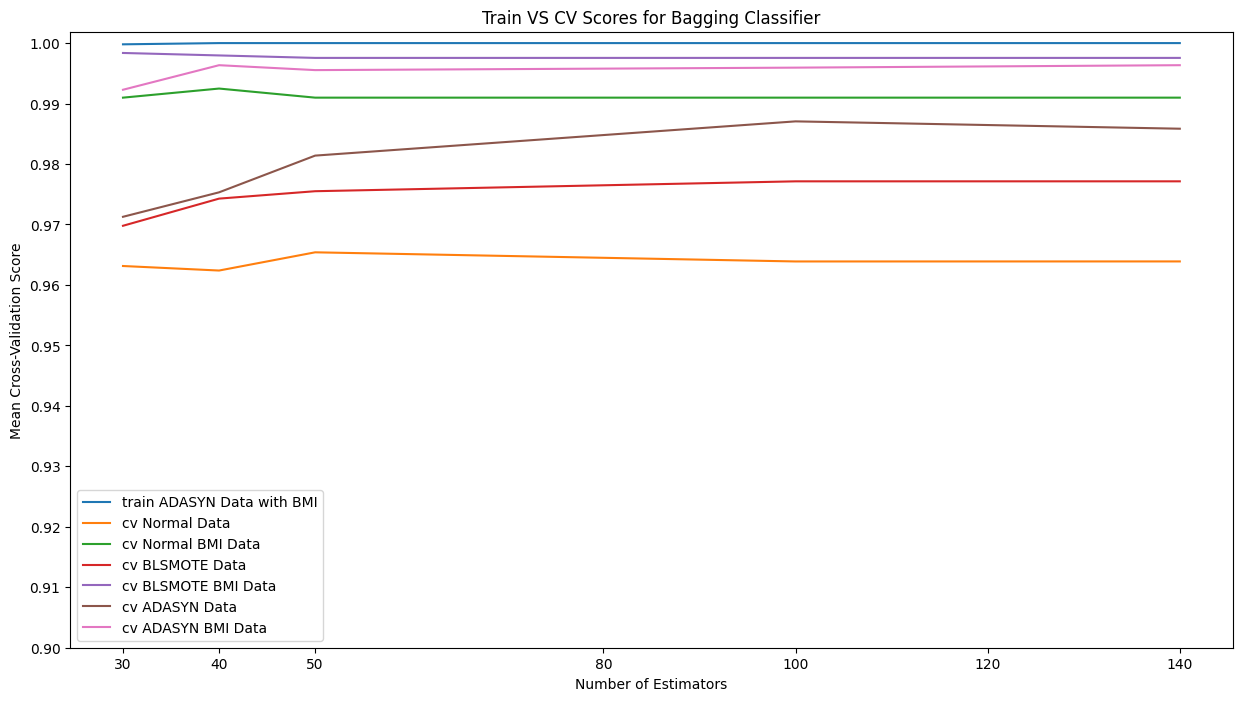

In [ ]:
# Define the hyperparameter values for each experiment
param_grid_normal = {'max_features': [0.5, 0.6, 0.7, 0.8, 0.9], 'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9], 'n_estimators': [30,40,50, 100,140]}
param_grid_blsmote = {'max_features': [0.5, 0.6, 0.7, 0.8, 0.9], 'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9],  'n_estimators': [30,40,50, 100,140]}
param_grid_adasyn_bmi = {'max_features': [0.5, 0.6, 0.9], 'max_samples': [0.5, 0.6, 0.9], 'n_estimators': [30,40,50, 100,140]}


# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the mean training and cross-validation scores for each experiment
train_scores_normal = bg_grid_adasyn_bmi.cv_results_['mean_train_score']

train_scores_normal = np.array(train_scores_normal).reshape(len(param_grid['max_features']), len(param_grid['max_samples']), len(param_grid['n_estimators']))

ax.plot(param_grid_adasyn_bmi['n_estimators'], train_scores_normal[1, 1, :], label='train ADASYN Data with BMI')


bg_normal_scores = np.array(bg_normal_scores).reshape(len(param_grid['max_features']), len(param_grid['max_samples']), len(param_grid['n_estimators']))
bg_bmi_scores = np.array(bg_bmi_scores).reshape(len(param_grid['max_features']), len(param_grid['max_samples']), len(param_grid['n_estimators']))
bg_adasyn_scores = np.array(bg_adasyn_scores).reshape(len(param_grid['max_features']), len(param_grid['max_samples']), len(param_grid['n_estimators']))
bg_blsmote_scores = np.array(bg_blsmote_scores).reshape(len(param_grid['max_features']), len(param_grid['max_samples']), len(param_grid['n_estimators']))
bg_bmi_ros_scores = np.array(bg_bmi_ros_scores).reshape(len(param_grid['max_features']), len(param_grid['max_samples']), len(param_grid['n_estimators']))
bg_bmi_adasyn_scores = np.array(bg_bmi_adasyn_scores).reshape(len(param_grid['max_features']), len(param_grid['max_samples']), len(param_grid['n_estimators']))

ax.plot(param_grid_normal['n_estimators'], bg_normal_scores[2, 2, :], label='cv Normal Data')
ax.plot(param_grid_normal['n_estimators'], bg_bmi_scores[2, 2, :], label='cv Normal BMI Data')
ax.plot(param_grid_blsmote['n_estimators'], bg_blsmote_scores[2, 2, :], label='cv BLSMOTE Data')
ax.plot(param_grid_blsmote['n_estimators'], bg_bmi_ros_scores[2, 2, :], label='cv BLSMOTE BMI Data')
ax.plot(param_grid_adasyn_bmi['n_estimators'], bg_adasyn_scores[1, 1, :], label='cv ADASYN Data')
ax.plot(param_grid_adasyn_bmi['n_estimators'], bg_bmi_adasyn_scores[1, 1, :], label='cv ADASYN BMI Data')

# Set the x and y labels and ticks
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Mean Cross-Validation Score')
ax.set_xticks([30, 40, 50, 80, 100, 120, 140])
ax.set_yticks(np.arange(.9,1.01,.01))

# Add a legend for the experiments
ax.legend(loc='best')

# Set the title for the plot
ax.set_title('Train VS CV Scores for Bagging Classifier')

# Show the plot
plt.show()

## SVC

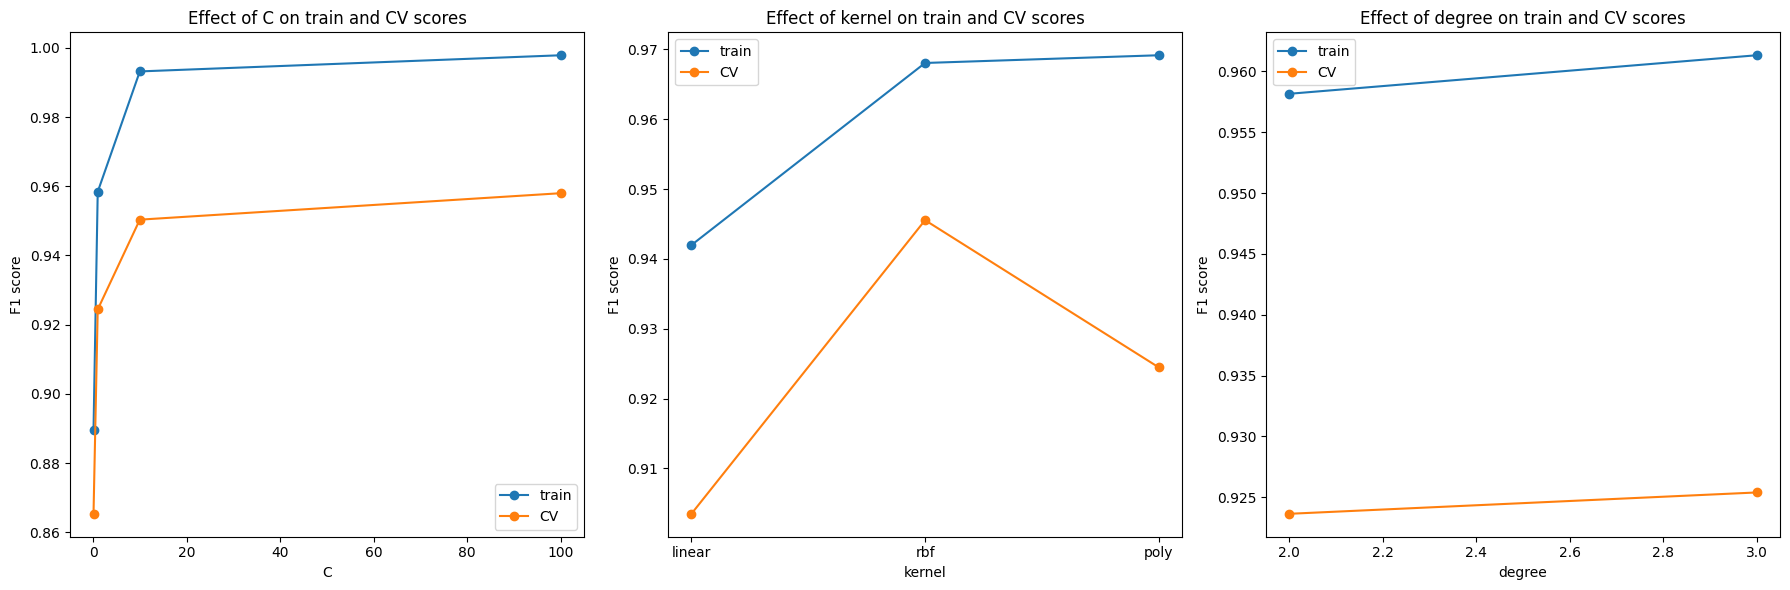

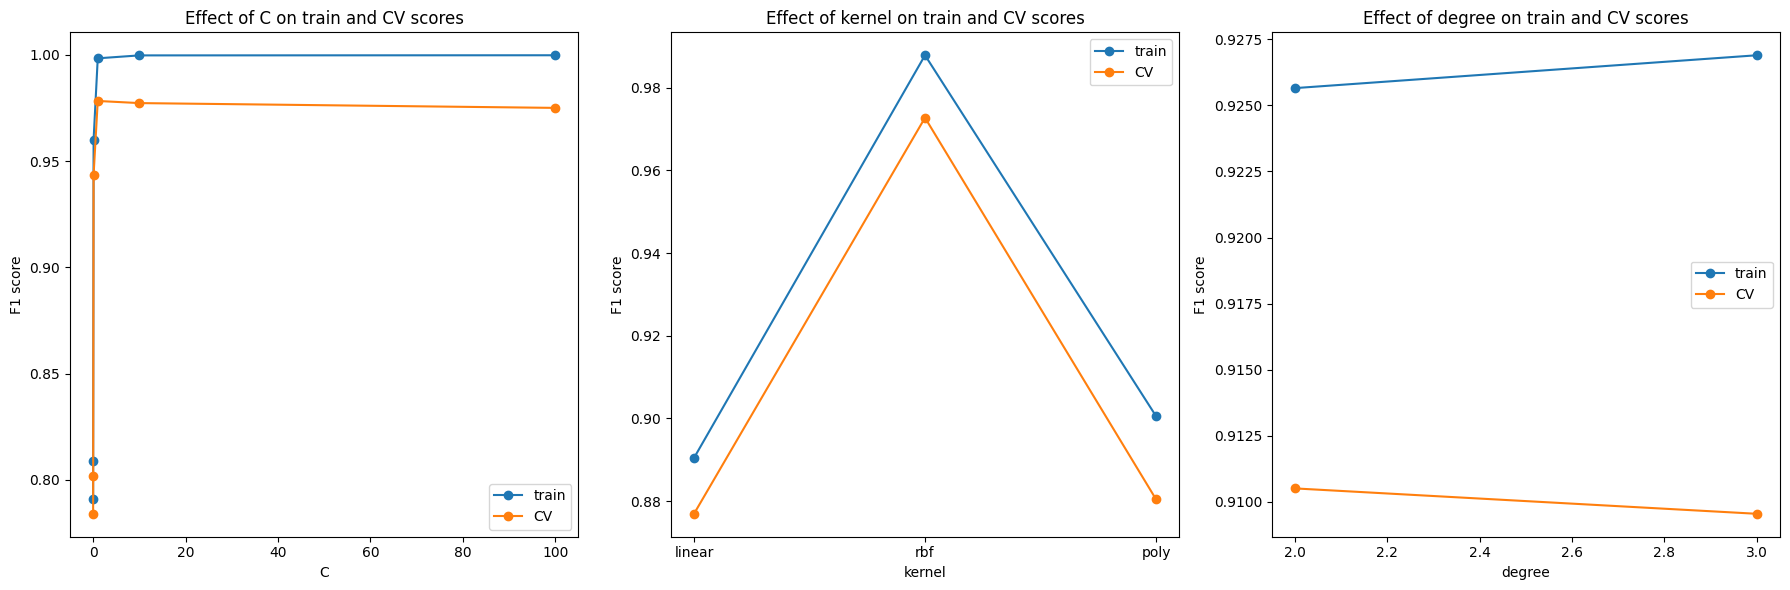

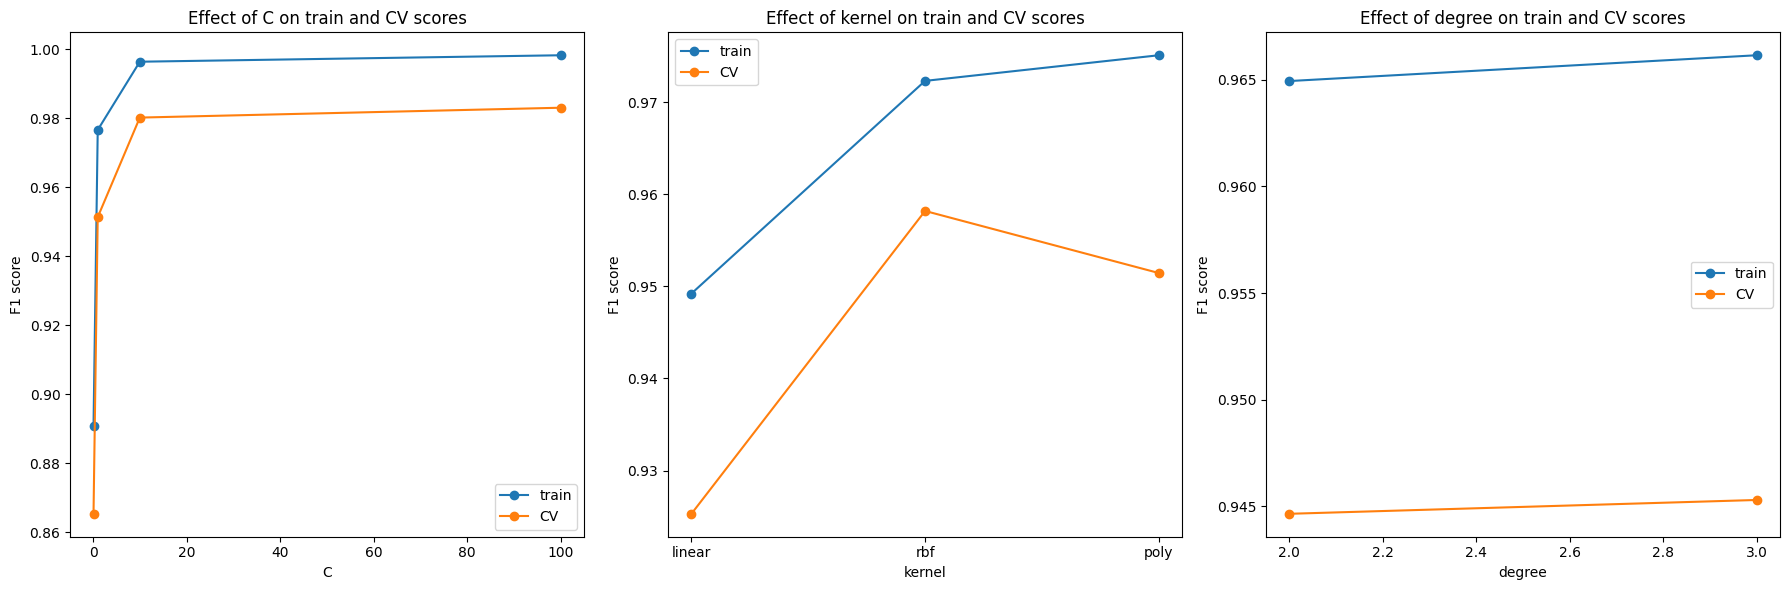

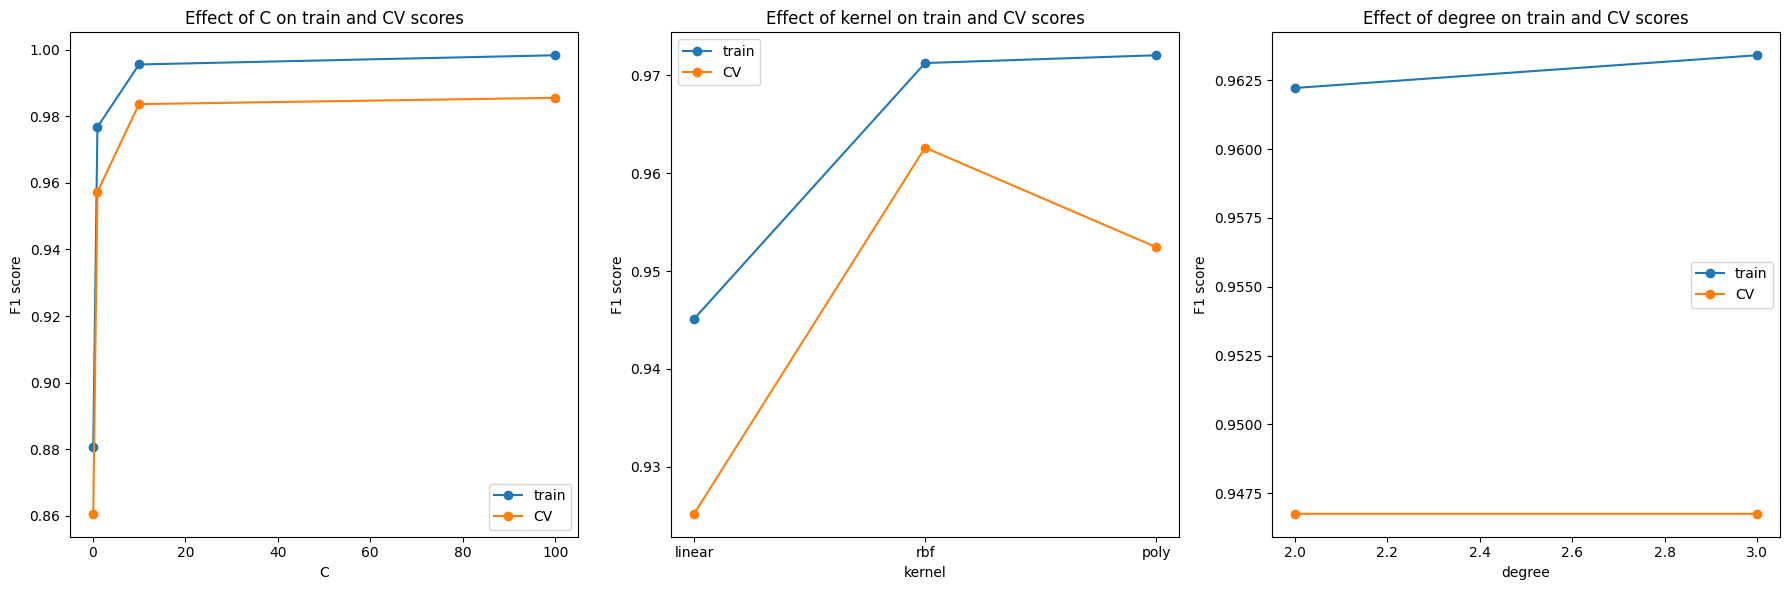

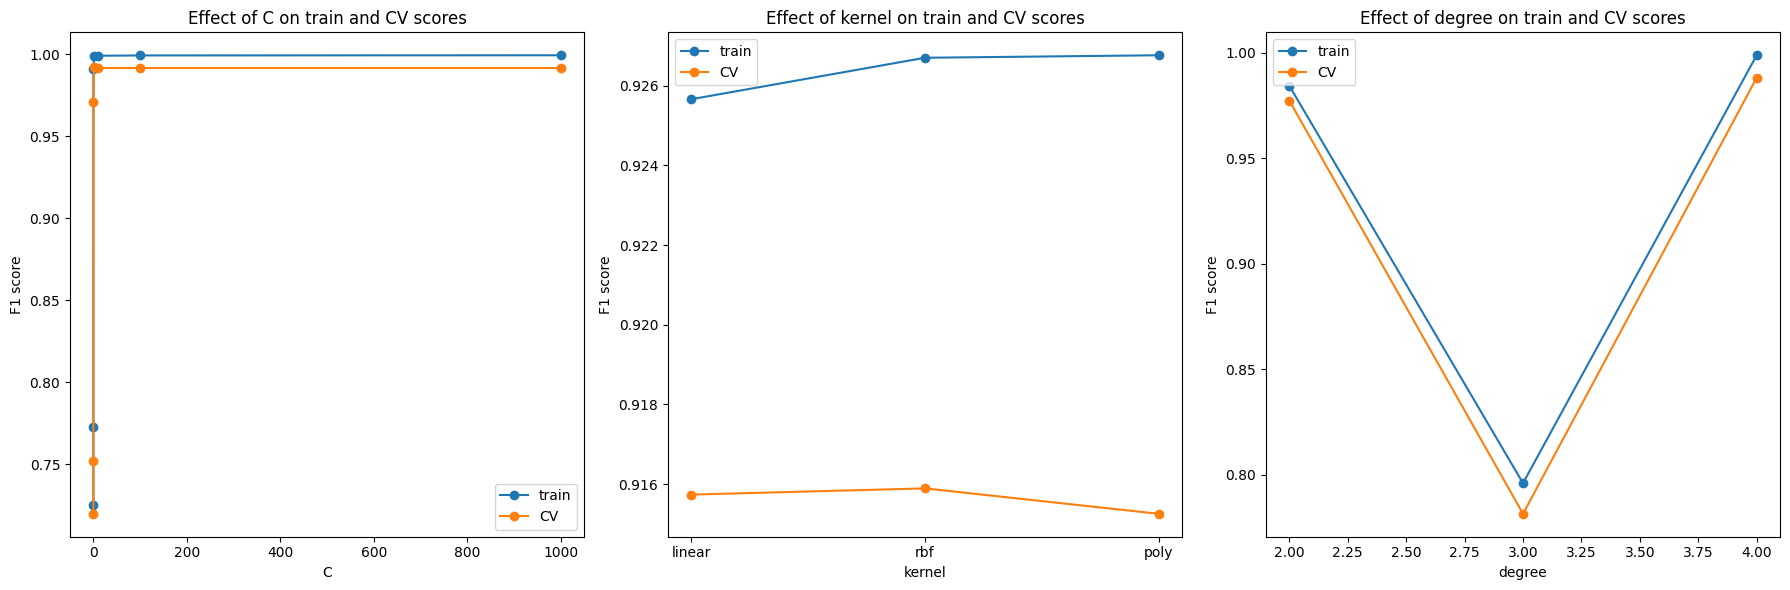

In [37]:
# create a list of hyperparameters
svc_hyperparameters = {
    'C': [0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3]
}

train_scores = best_normal_svc_grid_search.cv_results_['mean_train_score']
cv_scores = best_normal_svc_grid_search.cv_results_['mean_test_score']
train_scores = np.array(train_scores).reshape(len(svc_hyperparameters['C']), len(svc_hyperparameters['kernel']),
                                                                    len(svc_hyperparameters['degree']))
cv_scores = np.array(cv_scores).reshape(len(svc_hyperparameters['C']), len(svc_hyperparameters['kernel']),
                                                                    len(svc_hyperparameters['degree']))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# plot the effect of max_features on train and CV scores
axes[0].plot(svc_hyperparameters['C'], train_scores.mean(axis=(1,2)), '-o', label='train')
axes[0].plot(svc_hyperparameters['C'], cv_scores.mean(axis=(1,2)), '-o', label='CV')
axes[0].set_xlabel('C')
axes[0].set_ylabel('F1 score')
axes[0].set_title('Effect of C on train and CV scores')
axes[0].legend()

# plot the effect of max_samples on train and CV scores
axes[1].plot(svc_hyperparameters['kernel'], train_scores.mean(axis=(0,2)), '-o', label='train')
axes[1].plot(svc_hyperparameters['kernel'], cv_scores.mean(axis=(0,2)), '-o', label='CV')
axes[1].set_xlabel('kernel')
axes[1].set_ylabel('F1 score')
axes[1].set_title('Effect of kernel on train and CV scores')
axes[1].legend()

# plot the effect of n_estimators on train and CV scores
axes[2].plot(svc_hyperparameters['degree'], train_scores.mean(axis=(0,1)), '-o', label='train')
axes[2].plot(svc_hyperparameters['degree'], cv_scores.mean(axis=(0,1)), '-o', label='CV')
axes[2].set_xlabel('degree')
axes[2].set_ylabel('F1 score')
axes[2].set_title('Effect of degree on train and CV scores')
axes[2].legend()

plt.tight_layout()
plt.show()

##########################################################################
# create a list of hyperparameters
svc_hyperparameters = {
    'C': [1e-3,1e-2,0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3]
}
train_scores = best_normal_bmi_svc_grid_search.cv_results_['mean_train_score']
cv_scores = best_normal_bmi_svc_grid_search.cv_results_['mean_test_score']
train_scores = np.array(train_scores).reshape(len(svc_hyperparameters['C']), len(svc_hyperparameters['kernel']),
                                                                    len(svc_hyperparameters['degree']))
cv_scores = np.array(cv_scores).reshape(len(svc_hyperparameters['C']), len(svc_hyperparameters['kernel']),
                                                                    len(svc_hyperparameters['degree']))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# plot the effect of max_features on train and CV scores
axes[0].plot(svc_hyperparameters['C'], train_scores.mean(axis=(1,2)), '-o', label='train')
axes[0].plot(svc_hyperparameters['C'], cv_scores.mean(axis=(1,2)), '-o', label='CV')
axes[0].set_xlabel('C')
axes[0].set_ylabel('F1 score')
axes[0].set_title('Effect of C on train and CV scores')
axes[0].legend()

# plot the effect of max_samples on train and CV scores
axes[1].plot(svc_hyperparameters['kernel'], train_scores.mean(axis=(0,2)), '-o', label='train')
axes[1].plot(svc_hyperparameters['kernel'], cv_scores.mean(axis=(0,2)), '-o', label='CV')
axes[1].set_xlabel('kernel')
axes[1].set_ylabel('F1 score')
axes[1].set_title('Effect of kernel on train and CV scores')
axes[1].legend()

# plot the effect of n_estimators on train and CV scores
axes[2].plot(svc_hyperparameters['degree'], train_scores.mean(axis=(0,1)), '-o', label='train')
axes[2].plot(svc_hyperparameters['degree'], cv_scores.mean(axis=(0,1)), '-o', label='CV')
axes[2].set_xlabel('degree')
axes[2].set_ylabel('F1 score')
axes[2].set_title('Effect of degree on train and CV scores')
axes[2].legend()

plt.tight_layout()
plt.show()



##########################################################################
# create a list of hyperparameters
svc_hyperparameters = {
    'C': [0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3]
}
train_scores = best_blsmote_svc_grid_search.cv_results_['mean_train_score']
cv_scores = best_blsmote_svc_grid_search.cv_results_['mean_test_score']
train_scores = np.array(train_scores).reshape(len(svc_hyperparameters['C']), len(svc_hyperparameters['kernel']),
                                                                    len(svc_hyperparameters['degree']))
cv_scores = np.array(cv_scores).reshape(len(svc_hyperparameters['C']), len(svc_hyperparameters['kernel']),
                                                                    len(svc_hyperparameters['degree']))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# plot the effect of max_features on train and CV scores
axes[0].plot(svc_hyperparameters['C'], train_scores.mean(axis=(1,2)), '-o', label='train')
axes[0].plot(svc_hyperparameters['C'], cv_scores.mean(axis=(1,2)), '-o', label='CV')
axes[0].set_xlabel('C')
axes[0].set_ylabel('F1 score')
axes[0].set_title('Effect of C on train and CV scores')
axes[0].legend()

# plot the effect of max_samples on train and CV scores
axes[1].plot(svc_hyperparameters['kernel'], train_scores.mean(axis=(0,2)), '-o', label='train')
axes[1].plot(svc_hyperparameters['kernel'], cv_scores.mean(axis=(0,2)), '-o', label='CV')
axes[1].set_xlabel('kernel')
axes[1].set_ylabel('F1 score')
axes[1].set_title('Effect of kernel on train and CV scores')
axes[1].legend()

# plot the effect of n_estimators on train and CV scores
axes[2].plot(svc_hyperparameters['degree'], train_scores.mean(axis=(0,1)), '-o', label='train')
axes[2].plot(svc_hyperparameters['degree'], cv_scores.mean(axis=(0,1)), '-o', label='CV')
axes[2].set_xlabel('degree')
axes[2].set_ylabel('F1 score')
axes[2].set_title('Effect of degree on train and CV scores')
axes[2].legend()

plt.tight_layout()
plt.show()



##########################################################################
# create a list of hyperparameters
svc_hyperparameters = {
    'C': [0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3]
}

train_scores = best_adasyn_svc_grid_search.cv_results_['mean_train_score']
cv_scores = best_adasyn_svc_grid_search.cv_results_['mean_test_score']
train_scores = np.array(train_scores).reshape(len(svc_hyperparameters['C']), len(svc_hyperparameters['kernel']),
                                                                    len(svc_hyperparameters['degree']))
cv_scores = np.array(cv_scores).reshape(len(svc_hyperparameters['C']), len(svc_hyperparameters['kernel']),
                                                                    len(svc_hyperparameters['degree']))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# plot the effect of max_features on train and CV scores
axes[0].plot(svc_hyperparameters['C'], train_scores.mean(axis=(1,2)), '-o', label='train')
axes[0].plot(svc_hyperparameters['C'], cv_scores.mean(axis=(1,2)), '-o', label='CV')
axes[0].set_xlabel('C')
axes[0].set_ylabel('F1 score')
axes[0].set_title('Effect of C on train and CV scores')
axes[0].legend()

# plot the effect of max_samples on train and CV scores
axes[1].plot(svc_hyperparameters['kernel'], train_scores.mean(axis=(0,2)), '-o', label='train')
axes[1].plot(svc_hyperparameters['kernel'], cv_scores.mean(axis=(0,2)), '-o', label='CV')
axes[1].set_xlabel('kernel')
axes[1].set_ylabel('F1 score')
axes[1].set_title('Effect of kernel on train and CV scores')
axes[1].legend()

# plot the effect of n_estimators on train and CV scores
axes[2].plot(svc_hyperparameters['degree'], train_scores.mean(axis=(0,1)), '-o', label='train')
axes[2].plot(svc_hyperparameters['degree'], cv_scores.mean(axis=(0,1)), '-o', label='CV')
axes[2].set_xlabel('degree')
axes[2].set_ylabel('F1 score')
axes[2].set_title('Effect of degree on train and CV scores')
axes[2].legend()

plt.tight_layout()
plt.show()

##########################################################################
# create a list of hyperparameters
svc_hyperparameters = {
    'C': [10**i for i in range(-3, 4)],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3,4],
}


train_scores = best_adasyn_bmi_svc_grid_search.cv_results_['mean_train_score']
cv_scores = best_adasyn_bmi_svc_grid_search.cv_results_['mean_test_score']
train_scores = np.array(train_scores).reshape(len(svc_hyperparameters['C']), len(svc_hyperparameters['kernel']),
                                                                    len(svc_hyperparameters['degree']))
cv_scores = np.array(cv_scores).reshape(len(svc_hyperparameters['C']), len(svc_hyperparameters['kernel']),
                                                                    len(svc_hyperparameters['degree']))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# plot the effect of max_features on train and CV scores
axes[0].plot(svc_hyperparameters['C'], train_scores.mean(axis=(1,2)), '-o', label='train')
axes[0].plot(svc_hyperparameters['C'], cv_scores.mean(axis=(1,2)), '-o', label='CV')
axes[0].set_xlabel('C')
axes[0].set_ylabel('F1 score')
axes[0].set_title('Effect of C on train and CV scores')
axes[0].legend()

# plot the effect of max_samples on train and CV scores
axes[1].plot(svc_hyperparameters['kernel'], train_scores.mean(axis=(0,2)), '-o', label='train')
axes[1].plot(svc_hyperparameters['kernel'], cv_scores.mean(axis=(0,2)), '-o', label='CV')
axes[1].set_xlabel('kernel')
axes[1].set_ylabel('F1 score')
axes[1].set_title('Effect of kernel on train and CV scores')
axes[1].legend()

# plot the effect of n_estimators on train and CV scores
axes[2].plot(svc_hyperparameters['degree'], train_scores.mean(axis=(0,1)), '-o', label='train')
axes[2].plot(svc_hyperparameters['degree'], cv_scores.mean(axis=(0,1)), '-o', label='CV')
axes[2].set_xlabel('degree')
axes[2].set_ylabel('F1 score')
axes[2].set_title('Effect of degree on train and CV scores')
axes[2].legend()

plt.tight_layout()
plt.show()





# Learning Curve 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

def learning_curve_plot(grid,X,y,plot_title):
  # create a scorer for accuracy
  scorer = make_scorer(accuracy_score)
  train_sizes, train_scores, test_scores = learning_curve(
      grid.best_estimator_, X, y, cv=5, scoring=scorer, n_jobs=-1)

  # calculate the mean and standard deviation of the training and validation scores
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  # plot the learning curve for training and validation scores
  fig, ax1 = plt.subplots(1, 1, figsize=(8, 8)) # set the figure size and subplots

  ax1.plot(train_sizes, train_mean, label='Training score')
  ax1.plot(train_sizes, test_mean, label='Validation score')
  ax1.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
  ax1.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
  ax1.set_xlabel('Training set size')
  ax1.set_ylabel('Accuracy')
  ax1.set_title(plot_title + ' Learning Curve')
  ax1.legend()
  ax1.set_yticks(np.arange(0.5, 1.01, 0.01)) # set the y-tick labels

  plt.show()

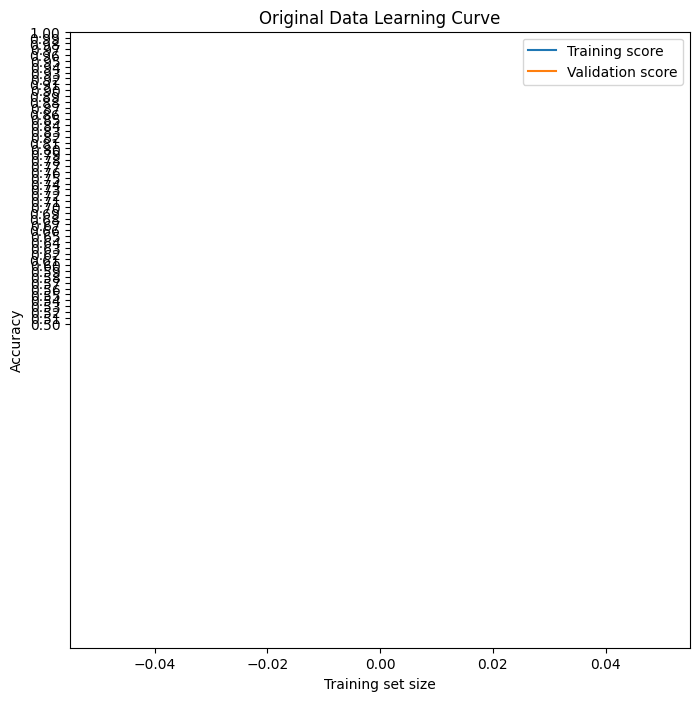

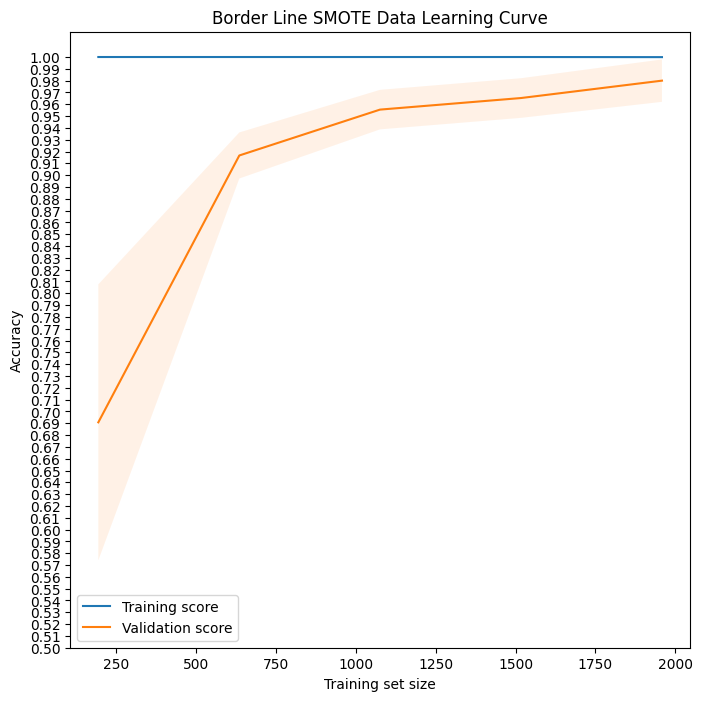

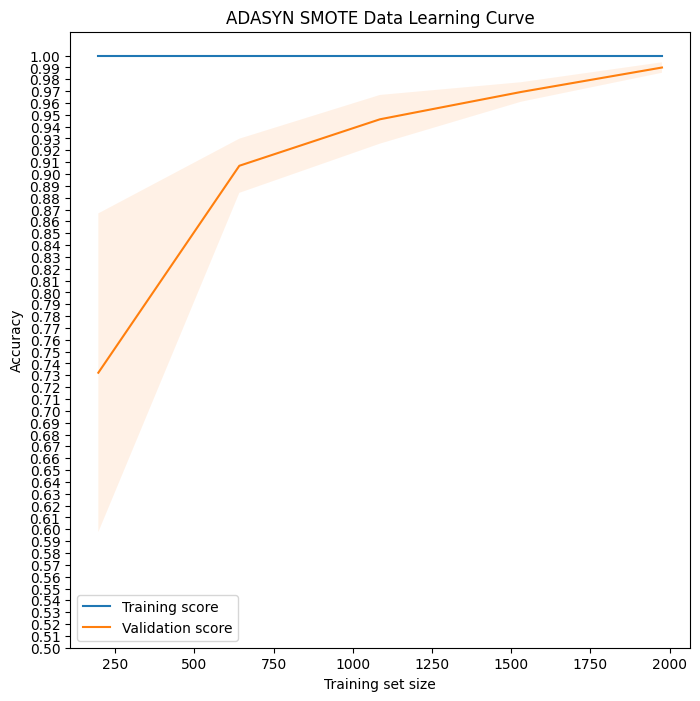

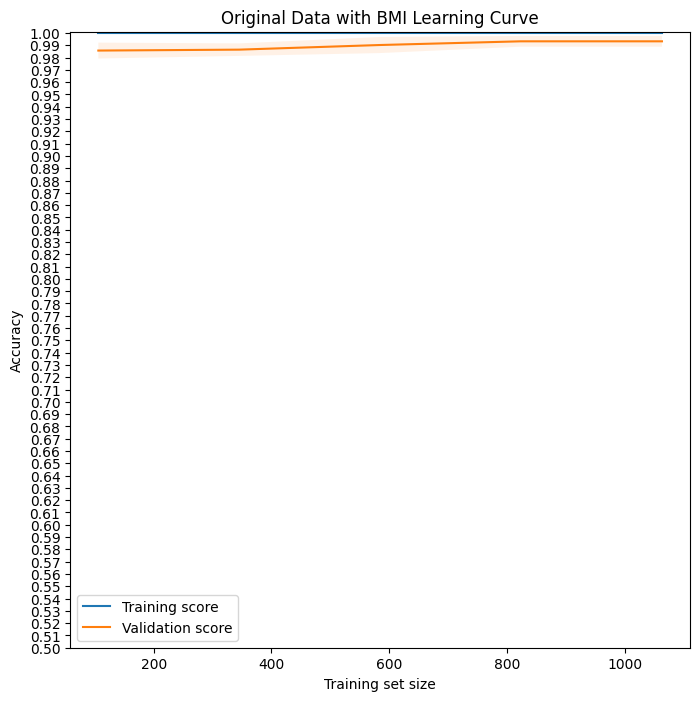

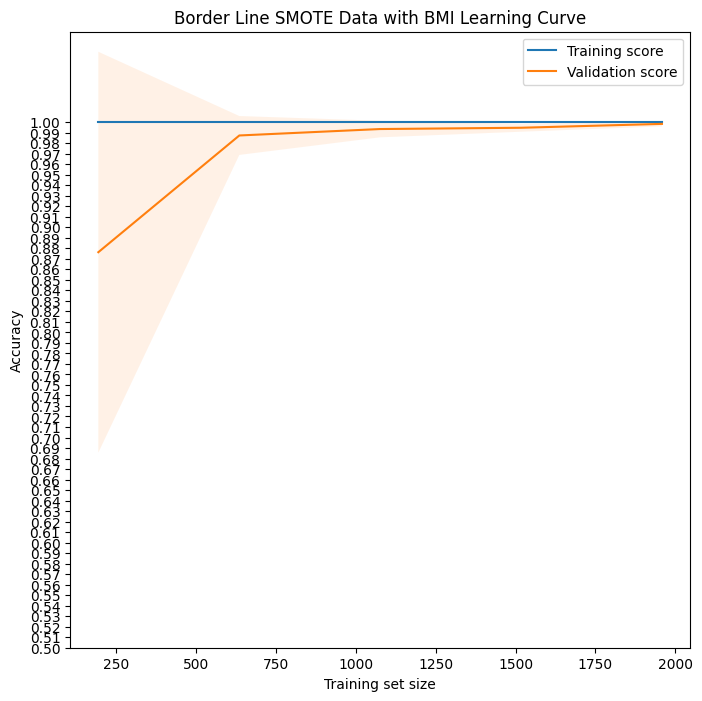

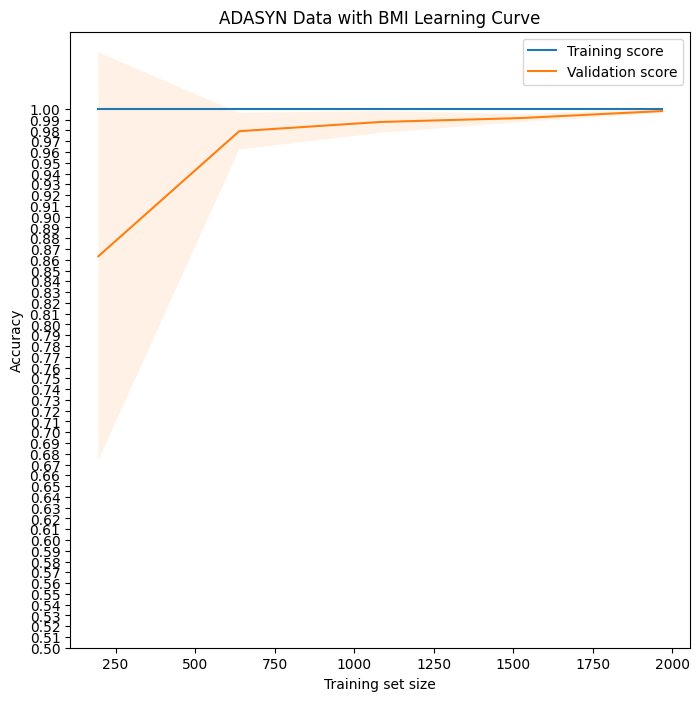

In [ ]:
learning_curve_plot(best_bagging_classifier_normal_data_grid_search,X_train,y_train,'Original Data')
learning_curve_plot(best_bagging_classifier_blsmote_data_grid_search,X_train_blsmote,y_train_blsmote,'Border Line SMOTE Data')
learning_curve_plot(best_bagging_classifier_adasyn_data_grid_search,X_train_adasyn,y_train_adasyn,'ADASYN SMOTE Data')
learning_curve_plot(best_bagging_classifier_normal_bmi_data_grid_search,X_train_BMI,y_train_BMI,'Original Data with BMI')
learning_curve_plot(best_bagging_classifier_blsmote_bmi_data_grid_search,X_train_blsmote_BMI,y_train_blsmote_BMI,'Border Line SMOTE Data with BMI')
learning_curve_plot(best_bagging_classifier_adasyn_bmi_data_grid_search,X_train_adasyn_BMI,y_train_adasyn_BMI,'ADASYN Data with BMI')

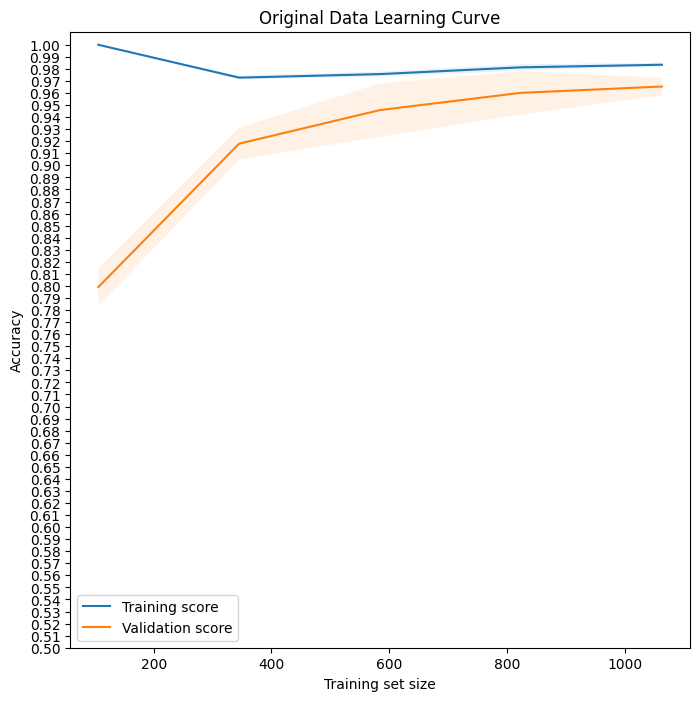

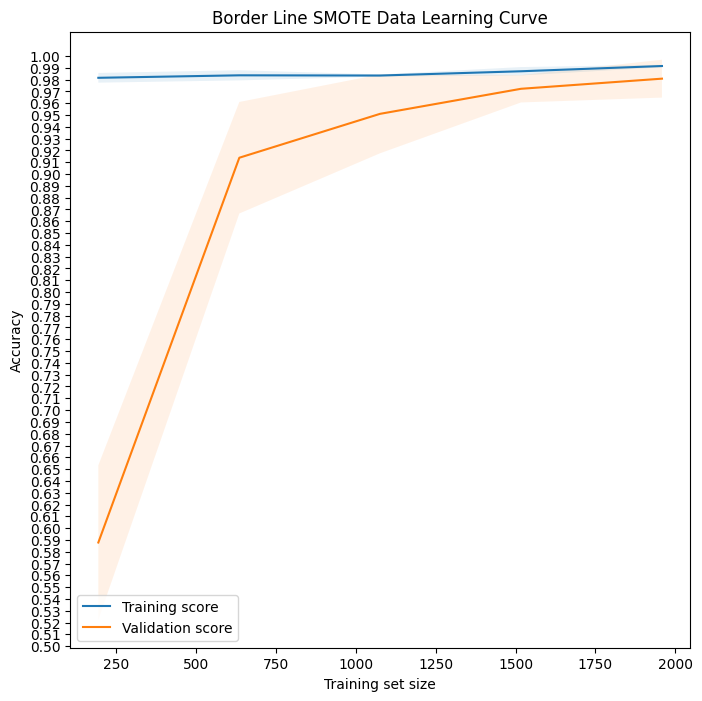

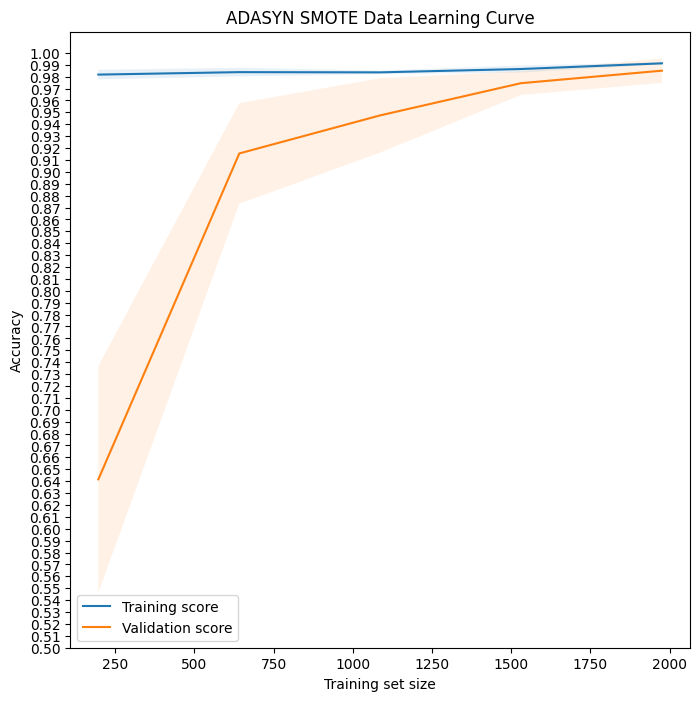

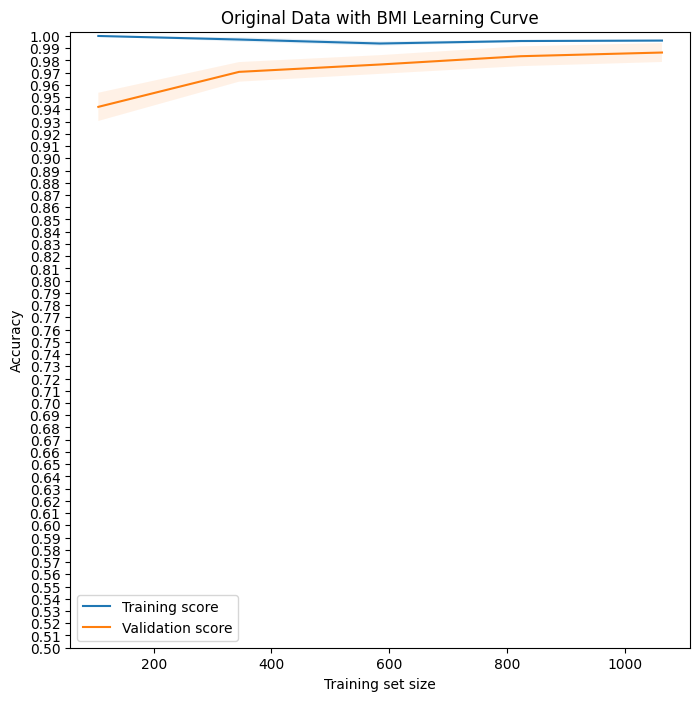

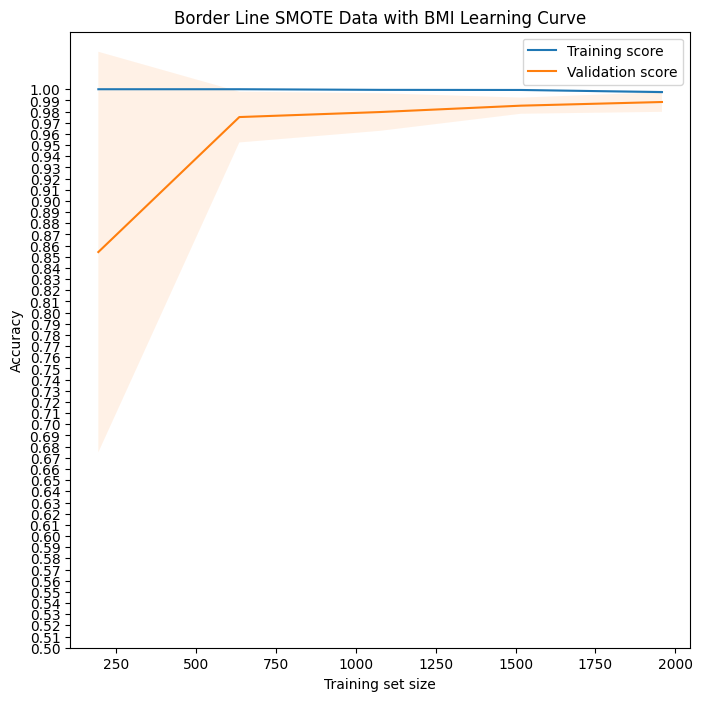

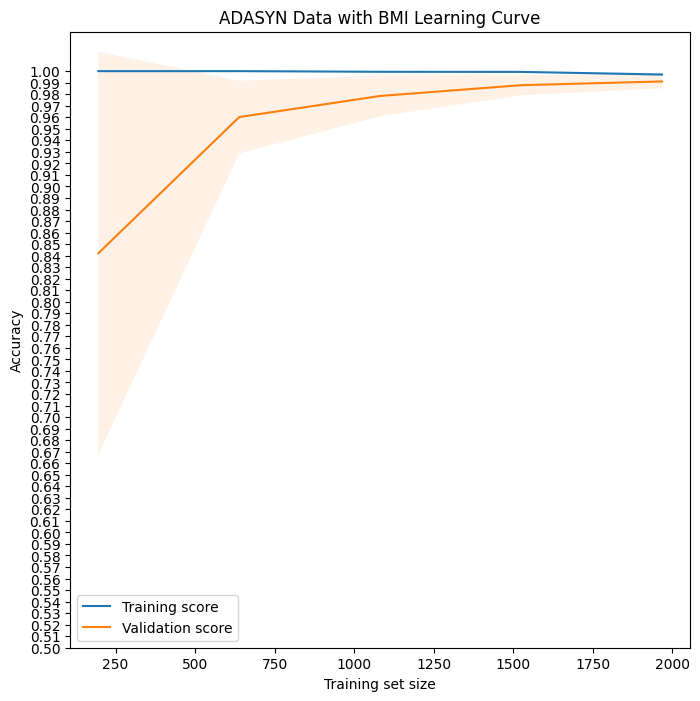

In [ ]:
learning_curve_plot(best_logistic_regression_normal_data_grid_search,X_train,y_train,'Original Data')
learning_curve_plot(best_logistic_regression_blsmote_data_grid_search,X_train_blsmote,y_train_blsmote,'Border Line SMOTE Data')
learning_curve_plot(best_logistic_regression_adasyn_data_grid_search,X_train_adasyn,y_train_adasyn,'ADASYN SMOTE Data')
learning_curve_plot(best_logistic_regression_normal_bmi_data_grid_search,X_train_BMI,y_train_BMI,'Original Data with BMI')
learning_curve_plot(best_logistic_regression_blsmote_bmi_data_grid_search,X_train_blsmote_BMI,y_train_blsmote_BMI,'Border Line SMOTE Data with BMI')
learning_curve_plot(best_logistic_regression_adasyn_bmi_data_grid_search,X_train_adasyn_BMI,y_train_adasyn_BMI,'ADASYN Data with BMI')

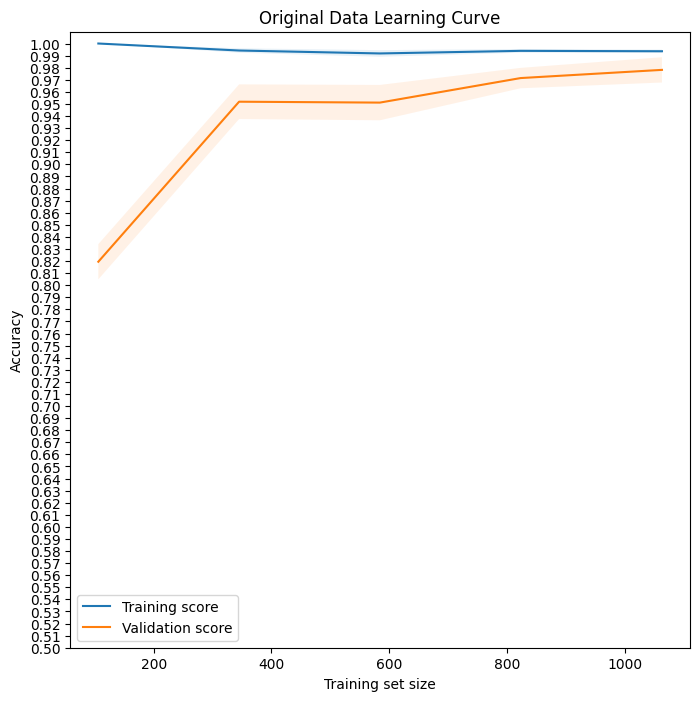

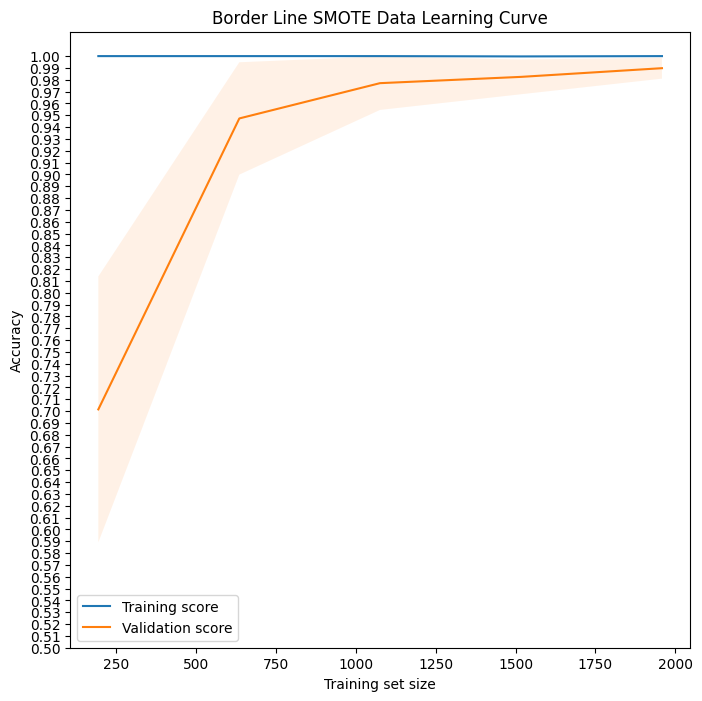

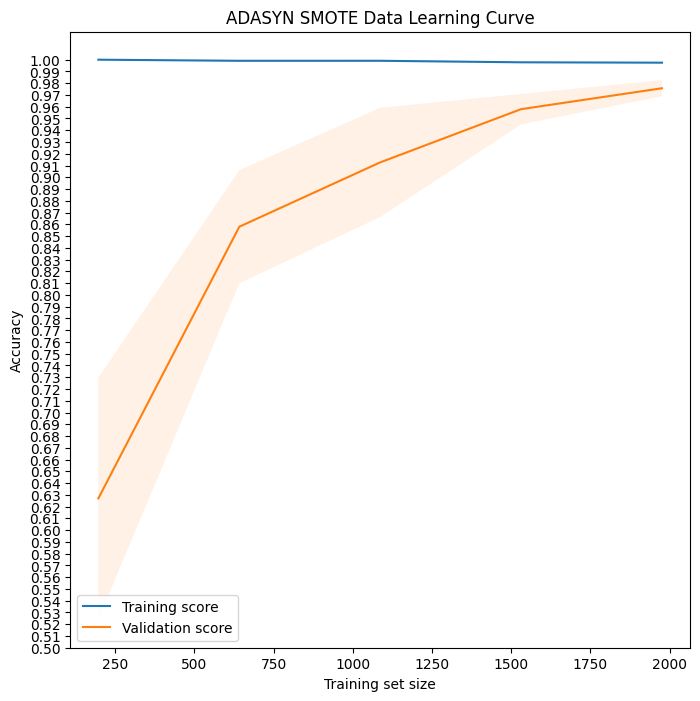

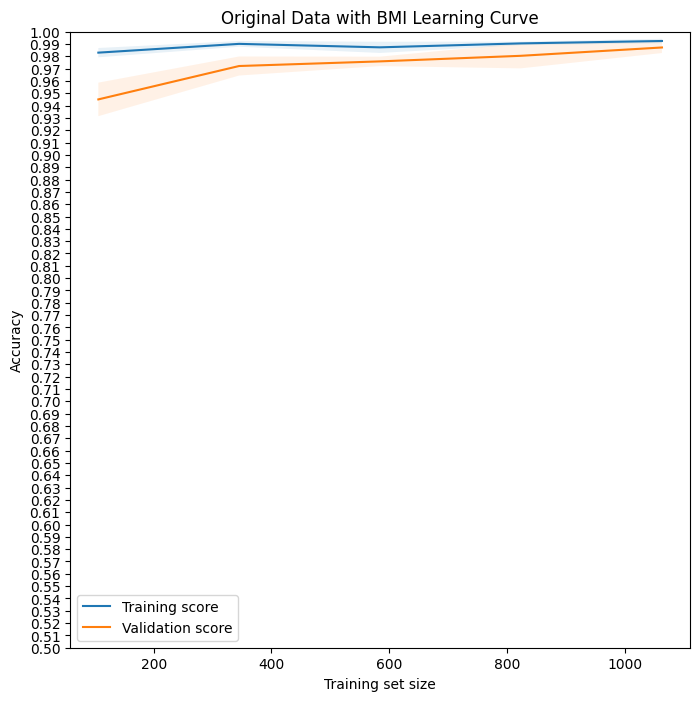

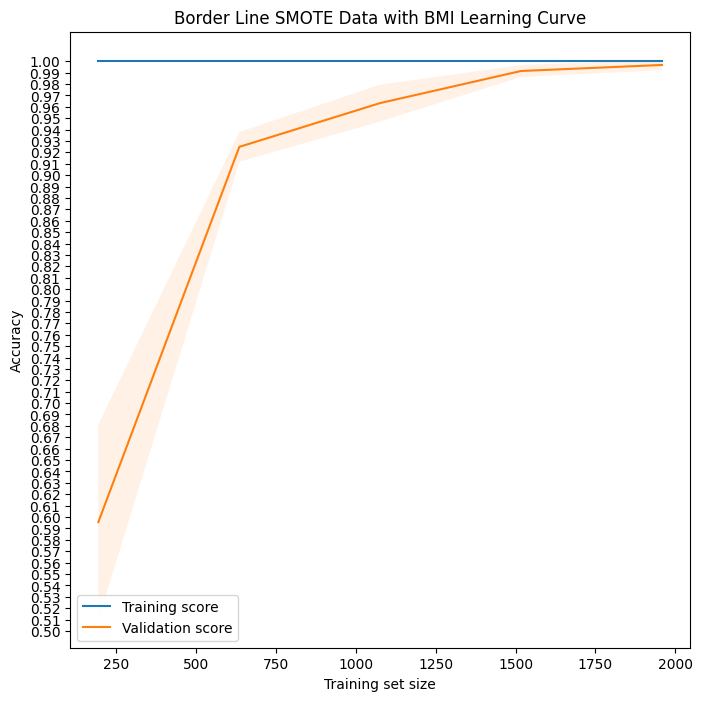

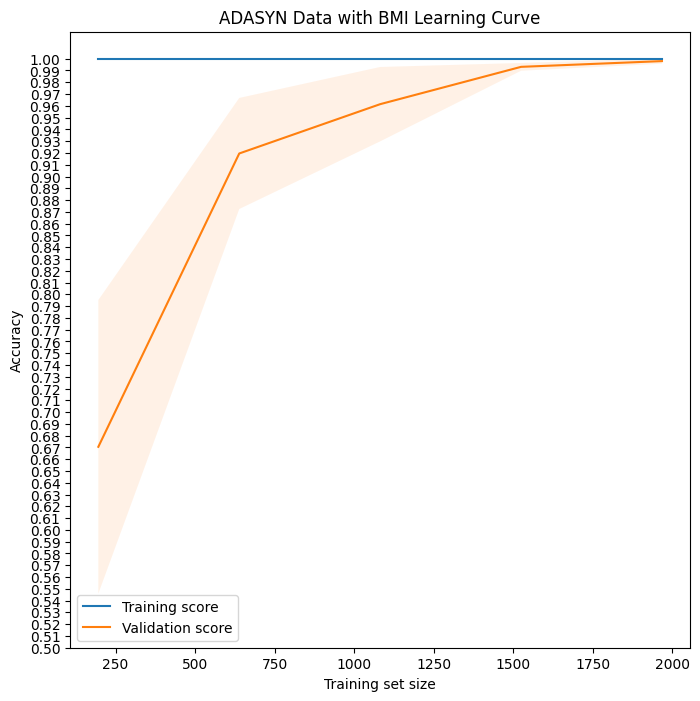

In [ ]:
learning_curve_plot(best_normal_svc_grid_search,X_train,y_train,'Original Data')
learning_curve_plot(best_blsmote_svc_grid_search,X_train_blsmote,y_train_blsmote,'Border Line SMOTE Data')
learning_curve_plot(best_adasyn_bmi_svc_grid_search,X_train_adasyn,y_train_adasyn,'ADASYN SMOTE Data')
learning_curve_plot(best_normal_bmi_svc_grid_search,X_train_BMI,y_train_BMI,'Original Data with BMI')
learning_curve_plot(best_blsmote_bmi_svc_grid_search,X_train_blsmote_BMI,y_train_blsmote_BMI,'Border Line SMOTE Data with BMI')
learning_curve_plot(best_adasyn_bmi_svc_grid_search,X_train_adasyn_BMI,y_train_adasyn_BMI,'ADASYN Data with BMI')

In [ ]:
from mlxtend.evaluate.bias_variance_decomp import bias_variance_decomp
# create a BiasVarianceDecomposition object with your model and the desired parameters
bv = bias_variance_decomp(best_bagging_classifier_adasyn_bmi_data_grid_search.best_estimator_, X_train_adasyn_BMI.values, y_train_adasyn_BMI.values, X_test_BMI.values, y_test_BMI.values, loss='mse', random_seed=42)


(0.004087837837837839, 0.00146097972972973, 0.0026268581081081085)


In [ ]:
print('*****************BIAS VARIANCE DECOMPOSITION**************************')
print("average MSE Error",bv[0])
print("average bias",bv[1])
print("average variance",bv[2])

*****************BIAS VARIANCE DECOMPOSITION**************************
average MSE Error 0.004087837837837839
average bias 0.004087837837837839
average variance 0.004087837837837839


# Downloading Models

In [ ]:
import os
import zipfile
from google.colab import files

# set the directory path
dir_path = '/content'

# create a compressed archive of the directory
zip_name = 'models.zip'
zip_path = os.path.join('/', 'content', zip_name)
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.joblib'):
                zipf.write(os.path.join(root, file))